In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import random
import os
import math
from scipy import signal

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import precision_recall_curve, auc, roc_curve, f1_score
from sklearn.decomposition import PCA
from sklearn.covariance import LedoitWolf
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.autograd import Variable
from fastai.layers import Embedding
from fastai.torch_core import Module
from typing import List, Tuple
import torch.utils.data as data_utils

In [2]:
# random_seed = 41

# torch.manual_seed(random_seed)
# torch.cuda.manual_seed(random_seed)
# torch.cuda.manual_seed_all(random_seed)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
# np.random.seed(random_seed)
# random.seed(random_seed)

SEED = 41

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [3]:
data_dir = '/kaggle/input/dataset/'
train_data = pd.read_csv(data_dir + 'train_data.csv')
test_data = pd.read_csv(data_dir + 'test_data.csv')
answer_sample = pd.read_csv(data_dir + 'answer_sample.csv')

In [4]:
# train_data['motor_f'] = train_data['motor_rpm'] / 60
# test_data['motor_f'] = test_data['motor_rpm'] / 60

# train_data['motor_rads'] = (2 * np.pi) * train_data['motor_f']
# test_data['motor_rads'] = (2 * np.pi) * test_data['motor_f']

# train_data['motor_period'] = 1 / train_data['motor_f']
# test_data['motor_period'] = 1 / test_data['motor_f']

In [5]:
train_data.columns

Index(['air_inflow', 'air_end_temp', 'out_pressure', 'motor_current',
       'motor_rpm', 'motor_temp', 'motor_vibe', 'type'],
      dtype='object')

In [6]:
# 푸리에 변환
def fft_transform(df, columns):
    temp = df.copy()
    for col in columns:
        temp[f'{col}_magnitude'] = np.abs(np.fft.fftshift(temp[col]) / len(temp[col]))
        
    return temp

# low pass filter
def lowpass_filter(df, columns, lowpass):
    temp = df.copy()
    b, a = signal.butter(1, lowpass, btype = 'lowpass')
    for col in columns:
        temp[col] = signal.filtfilt(b, a, temp[col])
    
    return temp

In [7]:
#train_data = fft_transform(train_data, ['motor_current','motor_rpm', 'motor_temp', 'motor_vibe'])
#test_data = fft_transform(test_data, ['motor_current','motor_rpm', 'motor_temp', 'motor_vibe'])

In [8]:
# lowpass = 0.1 #0.08
# train_data = lowpass_filter(train_data, train_data.drop('type', axis = 1).columns, lowpass)
# test_data = lowpass_filter(test_data, test_data.drop('type', axis = 1).columns, lowpass)

### **EDA**

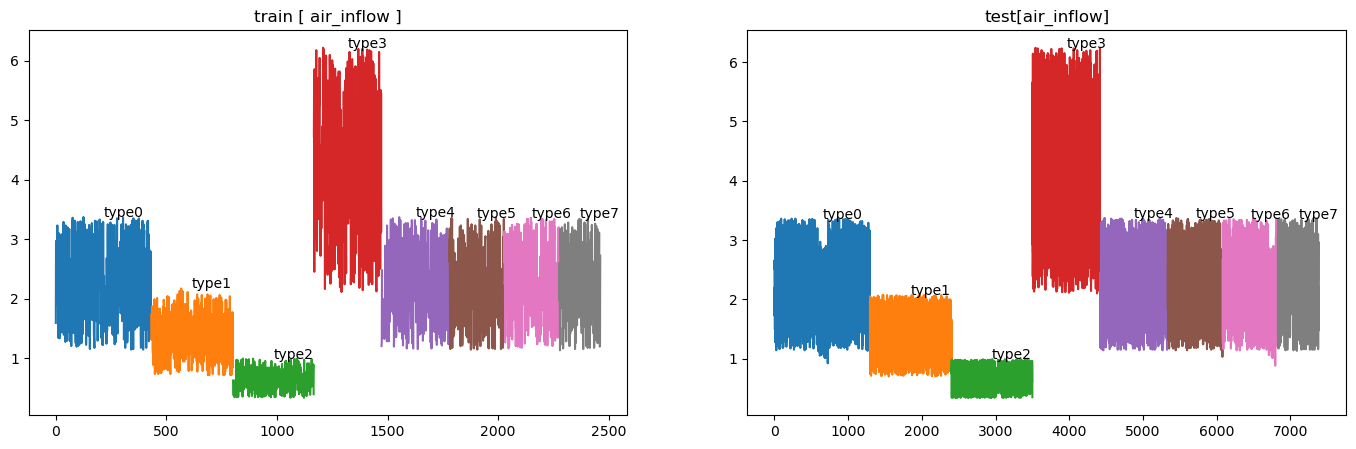

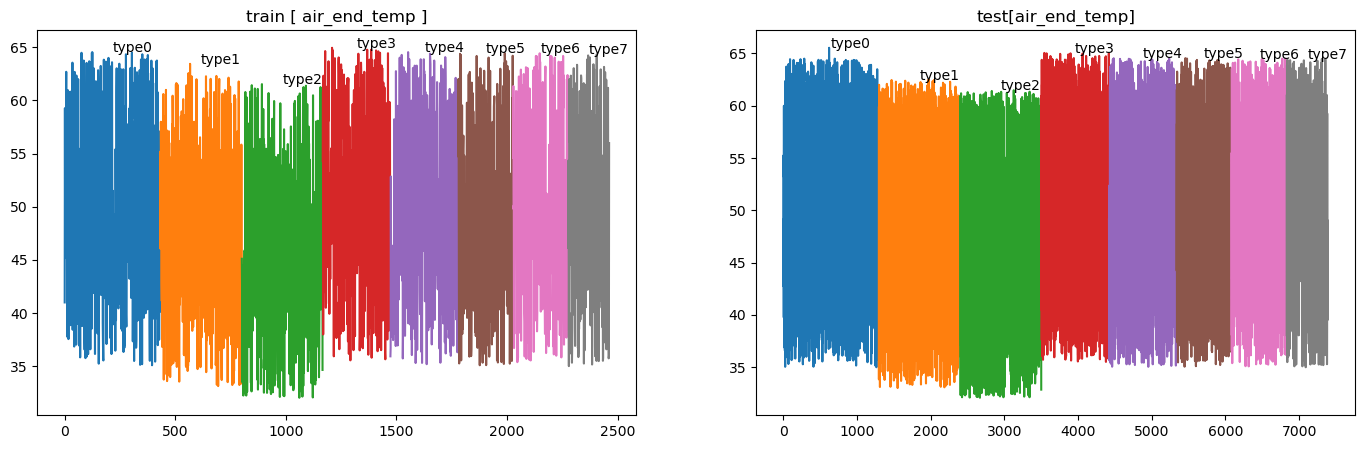

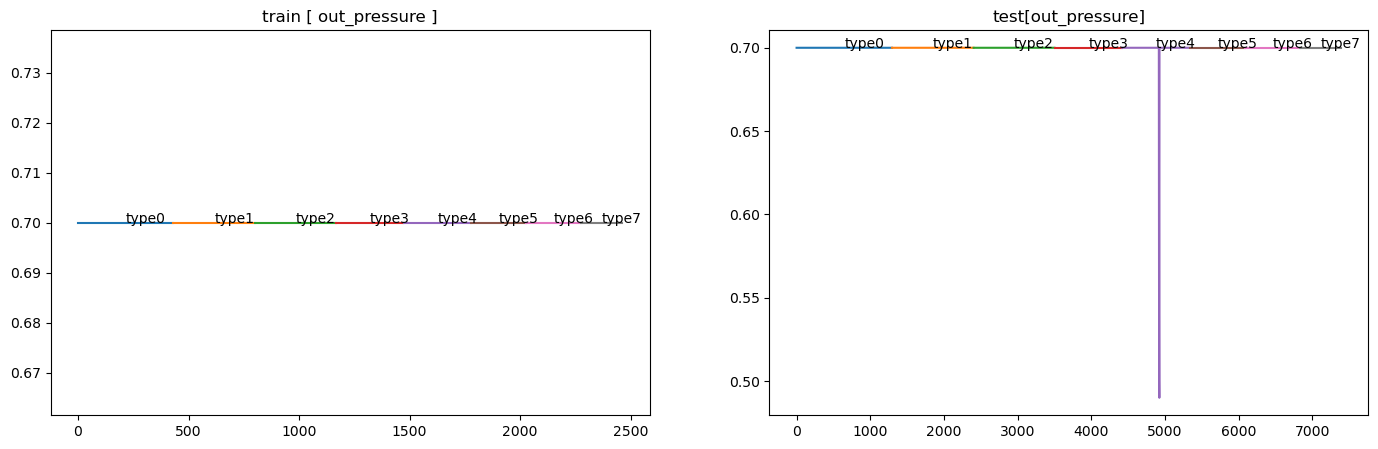

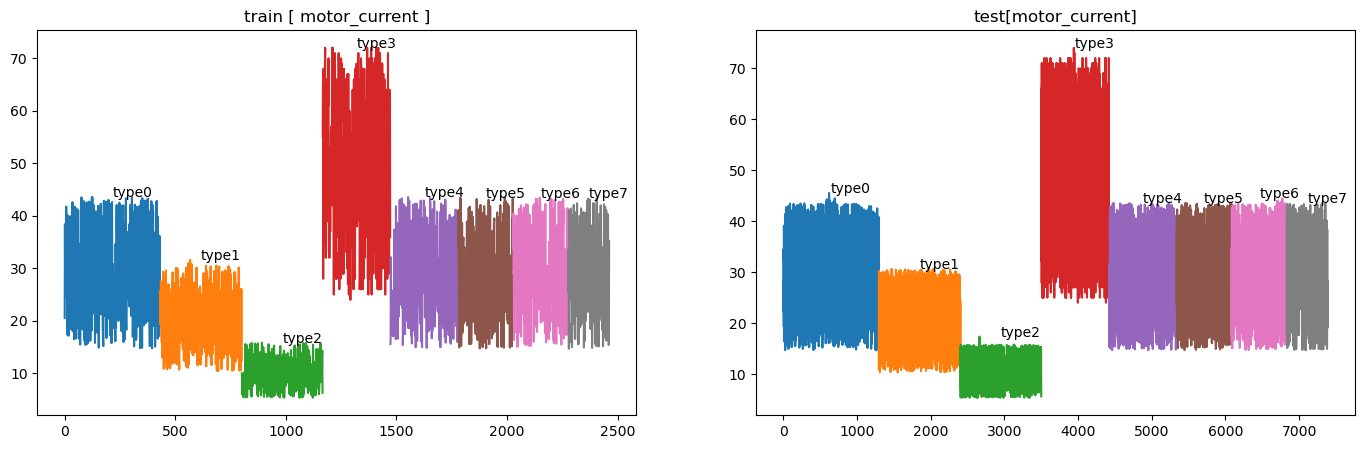

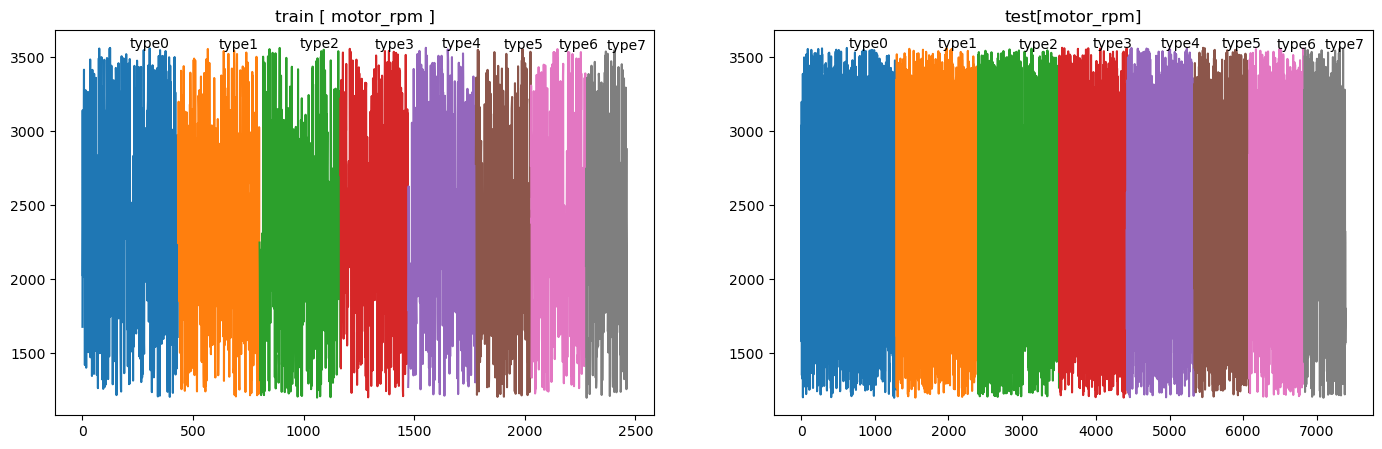

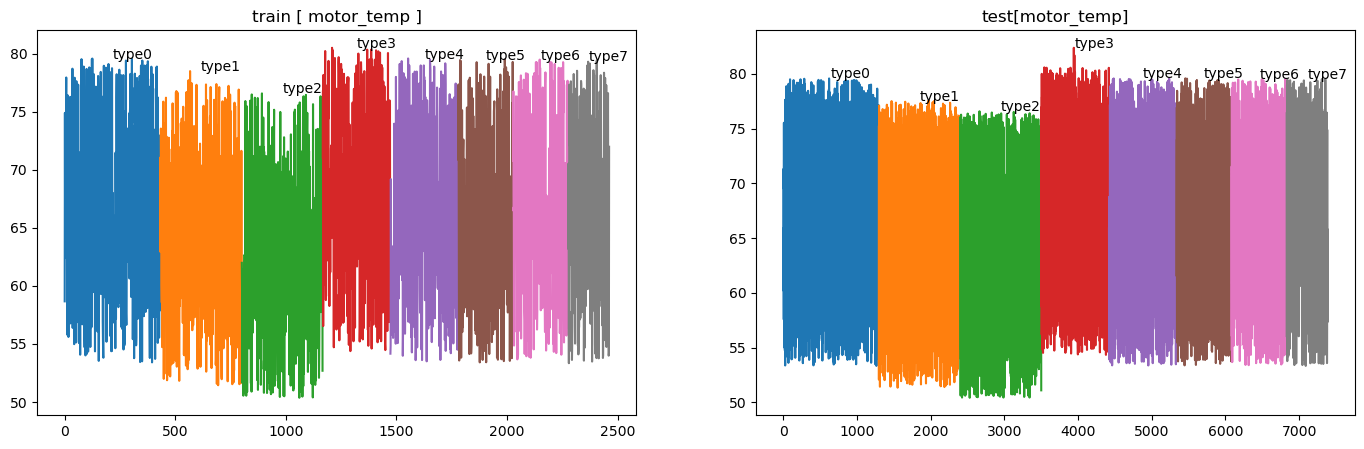

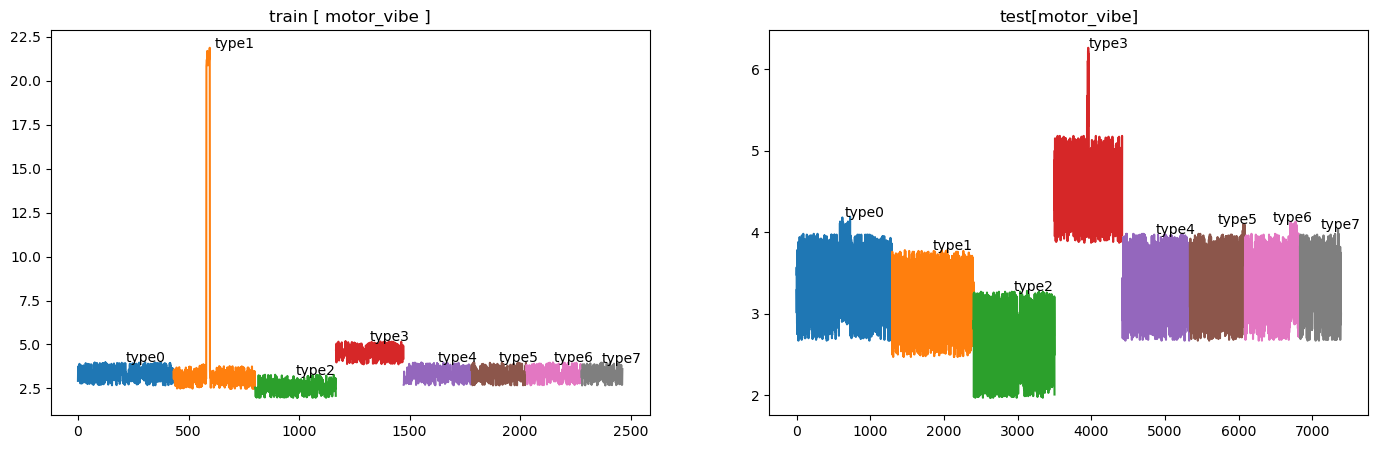

In [9]:
def plot():
    typs = train_data.type.unique()
    for col in train_data.columns[:-1].tolist():
        ax = plt.figure(figsize = (17, 5))
        for typ in typs:
            temp = train_data.loc[train_data.type == typ, col]
            temp_t = test_data.loc[test_data.type == typ, col]
            plt.subplot(1,2,1)
            plt.plot(temp)
            plt.text(np.median(temp.index), np.max(temp), f'type{typ}')
            plt.title(f'train [ {col} ]')
            plt.subplot(1,2,2)
            plt.plot(temp_t)
            plt.text(np.median(temp_t.index), np.max(temp_t), f'type{typ}')
            plt.title(f'test[{col}]')
        plt.show()
        
plot()

### **Outlier Processing**

In [10]:
def zscore_outlier(data, z):
    typs = train_data.type.unique()
    for col in data.columns[:-1].tolist():
        print(f'col: {col}')
        for typ in typs:
            print(f'type: {typ}')
            temp = data.loc[data.type == typ, col]
            outlier_temp = temp[abs(temp - np.mean(temp)) / np.std(temp) > z].index
            print(outlier_temp.index)
            temp_drop = temp.drop(outlier_temp.index, axis = 0)
            #print('mean: ', np.mean(temp_drop))
            data.loc[outlier_temp.index, col] = np.mean(temp_drop)
    return data
            
def iqr_outlier(data):
    typs = data.type.unique()
    for col in data.columns[:-1].tolist():
        print(f'col: {col}')
        for typ in typs:
            print(f'type: {typ}')
            temp = data.loc[data.type == typ, col]
            Q3, Q1 = np.percentile(temp, [75, 25])
            IQR = Q3 - Q1
            outlier_temp = temp[(Q1 - 1.5 * IQR > temp)|(Q3 + 1.5 * IQR < temp)]
            print(outlier_temp.index)
            #data = data.drop(outlier_temp.index, axis = 0)
            
            # transform mean
            #temp_drop = temp.drop(outlier_temp.index, axis = 0)
            #data.loc[outlier_temp.index, col] = np.mean(temp_drop)
            if len(outlier_temp.index) > 0:
                print(outlier_temp.index[0])
                data.loc[outlier_temp.index, col] = (data.loc[(outlier_temp.index[0]-1), col] + data.loc[(outlier_temp.index[-1]+1), col]) / 2
            
    return data

In [11]:
#train_data = zscore_outlier(train_data)
#test_data = zscore_outlier(test_data)
train_data = iqr_outlier(train_data)
#test_data = iqr_outlier(test_data)

col: air_inflow
type: 0
Int64Index([], dtype='int64')
type: 1
Int64Index([], dtype='int64')
type: 2
Int64Index([], dtype='int64')
type: 3
Int64Index([], dtype='int64')
type: 4
Int64Index([], dtype='int64')
type: 5
Int64Index([], dtype='int64')
type: 6
Int64Index([], dtype='int64')
type: 7
Int64Index([], dtype='int64')
col: air_end_temp
type: 0
Int64Index([], dtype='int64')
type: 1
Int64Index([], dtype='int64')
type: 2
Int64Index([], dtype='int64')
type: 3
Int64Index([], dtype='int64')
type: 4
Int64Index([], dtype='int64')
type: 5
Int64Index([], dtype='int64')
type: 6
Int64Index([], dtype='int64')
type: 7
Int64Index([], dtype='int64')
col: out_pressure
type: 0
Int64Index([], dtype='int64')
type: 1
Int64Index([], dtype='int64')
type: 2
Int64Index([], dtype='int64')
type: 3
Int64Index([], dtype='int64')
type: 4
Int64Index([], dtype='int64')
type: 5
Int64Index([], dtype='int64')
type: 6
Int64Index([], dtype='int64')
type: 7
Int64Index([], dtype='int64')
col: motor_current
type: 0
Int64Inde

In [12]:
all_data = pd.concat([train_data, test_data])

for column in all_data.columns.tolist():
    if all_data[column].dtype == 'float64':
        print(f'{column} apply scaling..')
        #scaler = StandardScaler()
        scaler = MinMaxScaler()
        scaler.fit(all_data[column].values.reshape(-1, 1))
        train_data[column] = scaler.transform(train_data[column].values.reshape(-1,1))
        test_data[column] = scaler.transform(test_data[column].values.reshape(-1,1))

air_inflow apply scaling..
air_end_temp apply scaling..
out_pressure apply scaling..
motor_current apply scaling..
motor_rpm apply scaling..
motor_temp apply scaling..
motor_vibe apply scaling..


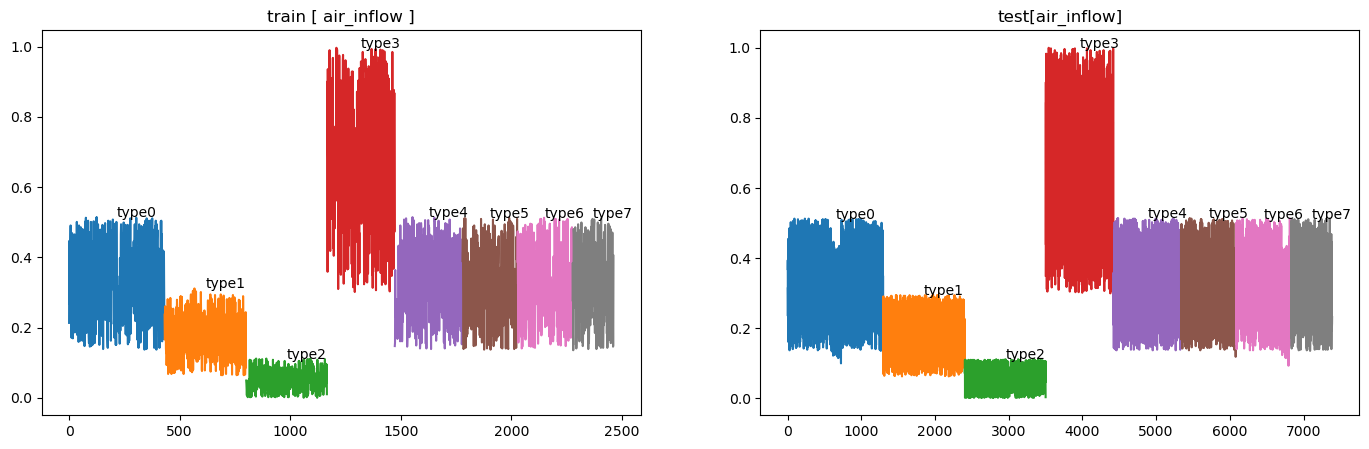

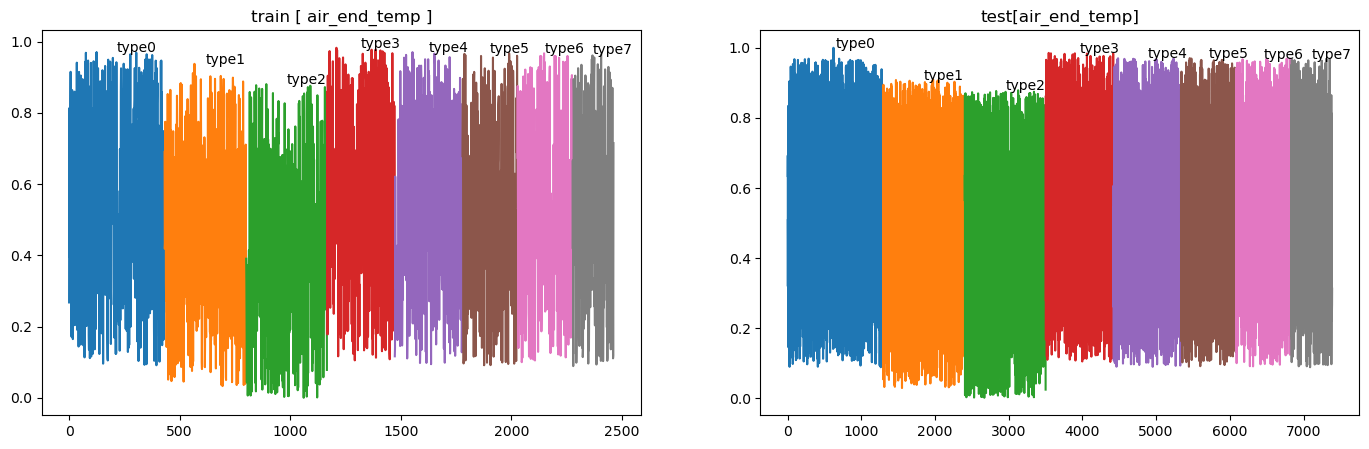

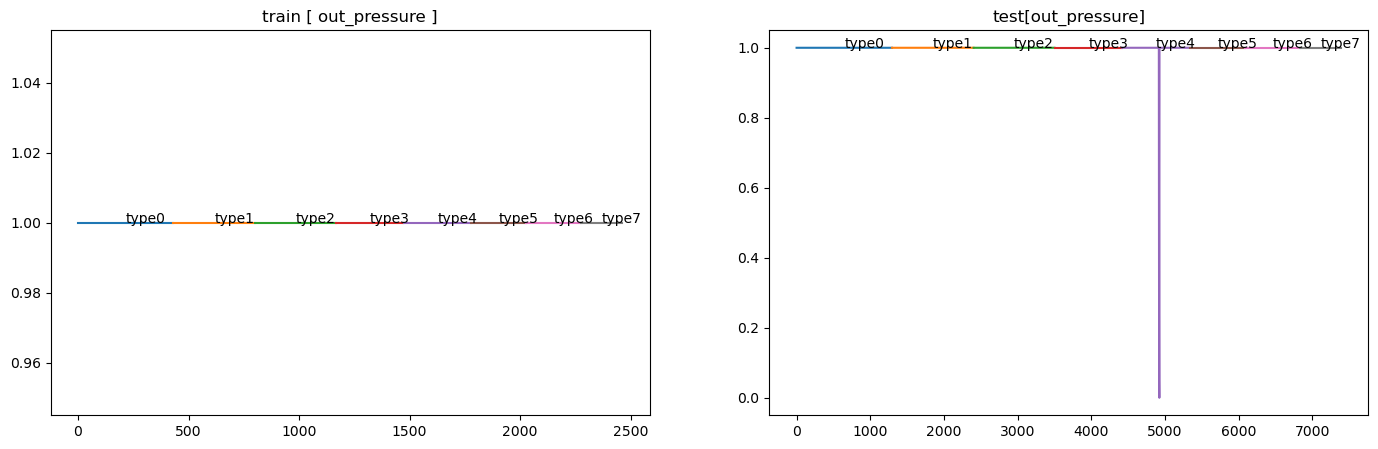

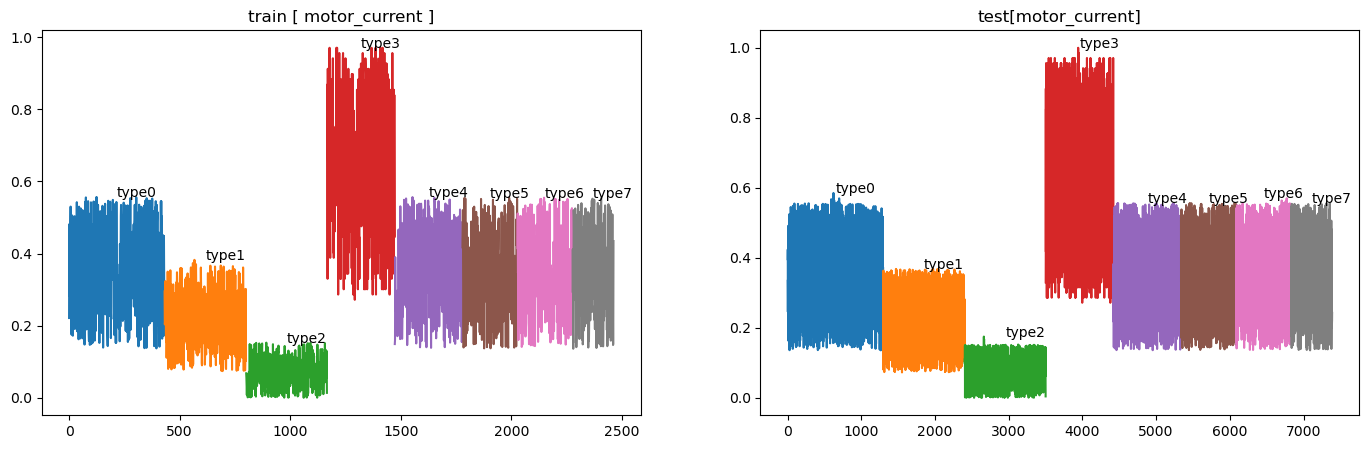

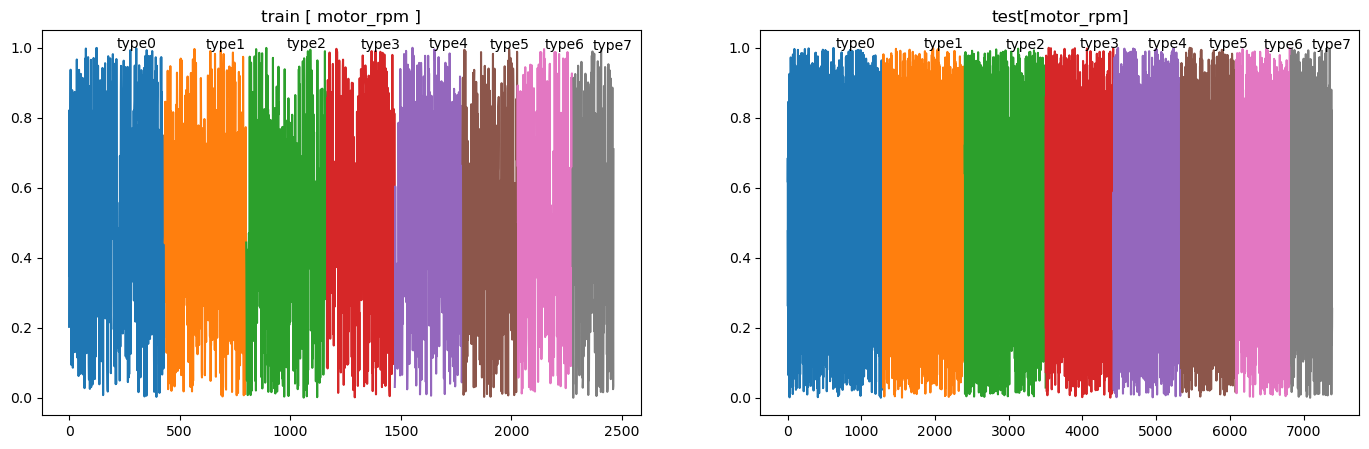

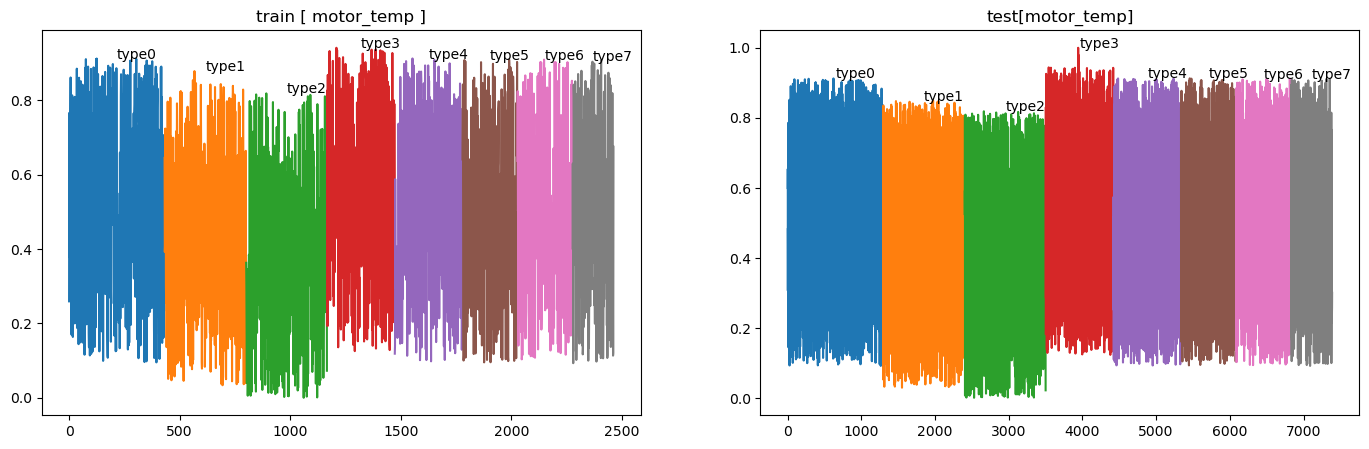

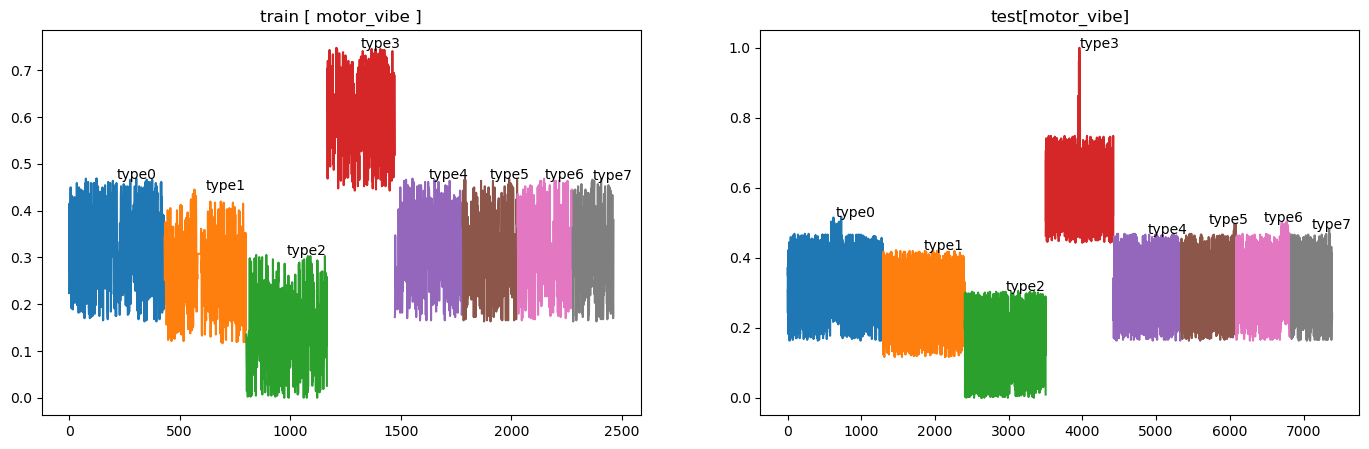

In [13]:
plot()

### **ChatGPT**

사기 검출과 같은 이상치 탐지 문제를 해결하기 위한 딥러닝 알고리즘 중에서는 다음과 같은 것들이 있습니다.

오토인코더(Autoencoder): 오토인코더는 입력 데이터를 압축한 후 다시 복원하는 방식으로 학습합니다. 이상치 데이터는 일반적인 패턴과 다르게 압축 및 복원이 이루어지므로, 이상치 검출에 활용됩니다.

변이형 오토인코더(Variational Autoencoder, VAE): VAE는 오토인코더의 변형으로, 잠재 변수(latent variable)를 이용하여 입력 데이터를 생성하는 모델입니다. 이상치는 잠재 변수 공간에서 일반적인 데이터와 다른 패턴을 보이므로, 이상치 검출에 활용됩니다.

GAN(Generative Adversarial Network): GAN은 생성 모델로, 경쟁하는 두 개의 네트워크로 구성됩니다. 이상치 검출을 위해, 입력 데이터가 진짜 데이터인지 가짜 데이터인지 판별하는 판별자 네트워크를 학습합니다. 진짜 데이터와 가짜 데이터 간의 차이가 크면 이상치로 판별할 수 있습니다.

LSTM(Long Short-Term Memory): LSTM은 순환 신경망(RNN)의 한 종류로, 시계열 데이터에 적용됩니다. 이상치는 일반적인 시계열 패턴과 다르게 나타나므로, LSTM을 이용하여 이상치를 검출할 수 있습니다.

이 중에서도 데이터 셋의 특성, 모델 구조, 하이퍼파라미터 등 다양한 요소를 고려하여 적절한 알고리즘을 선택하고 적용해야 합니다. 또한, 이상치 탐지의 결과를 해석하고 실제로 활용할 수 있도록 해석 가능한 모델을 선택하는 것이 중요합니다.

이상치 탐지는 일반적으로 데이터의 불균형(imbalanced) 문제가 발생하기 때문에, 교차 검증(cross-validation)은 이상치 탐지 모델의 성능을 평가하기에 적합하지 않습니다. 이는 정상 데이터와 이상치 데이터의 비율이 매우 작기 때문에, 일반적인 교차 검증 방법을 적용하면 정상 데이터만 선택되어 모델이 학습될 가능성이 높아지기 때문입니다.

이러한 문제를 해결하기 위해서는 샘플링 방법을 조정하거나, 다양한 이상치 검출 평가 지표를 사용하는 등의 다양한 방법을 고려해야 합니다.

따라서, 이상치 탐지 모델을 학습할 때는 교차 검증보다는 데이터를 분리하여 학습 및 검증을 진행하며, 이상치 탐지 평가 지표를 활용하여 성능을 평가하는 것이 더욱 적절합니다. 이를 통해 모델의 일반화 성능을 향상시키고, 실제 운영 환경에서의 성능을 예측할 수 있습니다.

Q1: 신용카드 사기검출 데이터셋 + 비지도 학습 문제를 GAN으로 해결하는 코드가 있을까?

Q2: train셋은 모두 정상인 데이터가 존재하지만, test셋은 정상 + 비정상 데이터가 존재한다. train셋을 가지고 test셋에 비정상 데이터를 탐지하기 위한 비지도학습 딥러닝 알고리즘이 어떤 것들이 있나요?

Q2-1: 그 알고리즘을 써서 비정상 데이터를 탐지하는 코드를 작성해주세요.

Autoencoder:

정상 데이터의 데이터를 잘 복원할 수 있도록 신경망을 훈련시키면 정상적인 패턴이 들어 왔을때는 복원율이 높을 것이고, 상대적으로 비정상 데이터가 들어왔을때는 복원율이 낮을 것이라는 가정을 기반으로 하고 있다.

정상 데이터와 복원 데이터와의 복원 오차(잔차)를 구하고

복원 오차(MSE) 기준으로 최적의 threshold로 정상/사기를 구분

적절한 threshold 를 구하기 위해서 Precision (True 라고 한것 중에서 진짜 True 인거) 와 Recall (전체 True 중에서 얼마나 찾아낸것인지) 두 가지 관점을 그래프로 그려보고 적당한 threshold 값을 구한다.

https://hugrypiggykim.com/2018/01/16/fds-fraud-detection-system-with-autoencoder/

In [14]:
from torch.optim.optimizer import Optimizer
class Lion(Optimizer):
    def __init__( self, params, lr: float = 1e-4, betas: tuple= (0.9, 0.99), weight_decay: float = 0.0):
        
        assert lr > 0.
        assert all([0. <= beta <= 1. for beta in betas])
        defaults = dict(lr = lr, betas = betas, weight_decay = weight_decay)
        super().__init__(params, defaults)

    @torch.no_grad()
    def step( self, closure= None):

        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in filter(lambda p: p.grad is not None, group['params']):
                #parameter
                grad, lr, wd, beta1, beta2, state = p.grad, group['lr'], group['weight_decay'], *group['betas'], self.state[p]
                if len(state) == 0: state['exp_avg'] = torch.zeros_like(p)
                exp_avg = state['exp_avg']
                
                 # Lion optimizer
                p.data.mul_(1 - lr * wd)
                update = exp_avg.clone().lerp_(grad, 1 - beta1)
                p.add_(torch.sign(update), alpha = -lr)
                exp_avg.lerp_(grad, 1 - beta2)
        return loss

In [15]:
# AutoEncoder
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout_rate):
        super(AutoEncoder, self).__init__()
        self.encoder_layers = nn.ModuleList()
        
        input_size = input_dim
        for idx, hidden_size in enumerate(hidden_dim):
            self.encoder_layers.append(nn.Linear(input_size, hidden_size))
            self.encoder_layers.append(nn.ReLU(inplace = True))
            #self.encoder_layers.append(nn.ELU())
            input_size = hidden_size
        
        self.decoder_layers = nn.ModuleList()
        input_size = hidden_dim[-1]
        for hidden_size in reversed(hidden_dim[:-1]):
            self.decoder_layers.append(nn.Linear(input_size, hidden_size))
            self.decoder_layers.append(nn.ReLU(inplace = True))
            #self.decoder_layers.append(nn.ELU())
            input_size = hidden_size
        self.decoder_layers.append(nn.Linear(input_size, input_dim))
        
    def forward(self, x):
        encoded = x
        for layer in self.encoder_layers:
            encoded = layer(encoded)
            
        decoded = encoded
        for layer in self.decoder_layers:
            decoded = layer(decoded)
        
        return decoded

# class AutoEncoder(nn.Module):
#     def __init__(self, input_dim, hidden_dim, dropout_rate):
#         super(AutoEncoder, self).__init__()
#         #LayerNorm(5000)
#         #LayerNorm(3500)
#         #LayerNorm(2000)
#         #LayerNorm(1000)
#         self.encoder_layers = nn.ModuleList()        
#         input_size = input_dim
#         for idx, hidden_size in enumerate(hidden_dim):
#             self.encoder_layers.append(nn.Linear(input_size, hidden_size))
#             #self.encoder_layers.append(nn.BatchNorm1d(hidden_size))
#             #self.encoder_layers.append(nn.LeakyReLU())
#             #self.encoder_layers.append(nn.ReLU())
#             #self.encoder_layers.append(GELU())
#             self.encoder_layers.append(nn.Tanh())
#             #self.encoder_layers.append(nn.Dropout(dropout_rate))
#             input_size = hidden_size
        
#         self.decoder_layers = nn.ModuleList()
#         input_size = hidden_dim[-1]
#         for hidden_size in reversed(hidden_dim[:-1]):
#             self.decoder_layers.append(nn.Linear(input_size, hidden_size))
#             #self.decoder_layers.append(nn.BatchNorm1d(hidden_size))
#             #self.decoder_layers.append(nn.LeakyReLU())
#             self.decoder_layers.append(nn.ReLU())
#             #self.encoder_layers.append(GELU())
#             #self.decoder_layers.append(nn.Tanh())
#             self.decoder_layers.append(nn.Dropout(dropout_rate))
#             input_size = hidden_size
#         self.decoder_layers.append(nn.Linear(input_size, input_dim))
#         #self.decoder_layers.append(nn.Dropout(dropout_rate))
#         #self.decoder_layers.append(nn.Sigmoid())
        
#     def forward(self, x):
#         encoded = x
#         for layer in self.encoder_layers:
#             encoded = layer(encoded)
            
#         decoded = encoded
#         for layer in self.decoder_layers:
#             decoded = layer(decoded)
        
#         return decoded

# VAE
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        
        self.encoder_layers = nn.ModuleList()
        self.encoder_layers.append(nn.Linear(input_dim, hidden_dim[0]))
        self.encoder_layers.append(nn.ReLU())
        for idx in range(len(hidden_dim) - 1):
            self.encoder_layers.append(nn.Linear(hidden_dim[idx], hidden_dim[idx+1]))
            self.encoder_layers.append(nn.ReLU())
            
        self.mu_layer = nn.Linear(hidden_dim[-1], latent_dim)
        self.logvar_layer = nn.Linear(hidden_dim[-1], latent_dim)
        
        self.decoder_layers = nn.ModuleList()
        self.decoder_layers.append(nn.Linear(latent_dim, hidden_dim[-1]))
        self.decoder_layers.append(nn.ReLU())
        for idx in range(len(hidden_dim)-1, 0, -1):
            self.decoder_layers.append(nn.Linear(hidden_dim[idx], hidden_dim[idx-1]))
            self.decoder_layers.append(nn.ReLU())
        self.decoder_layers.append(nn.Linear(hidden_dim[0], input_dim))
        self.decoder_layers.append(nn.Sigmoid())
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z
    
    def encode(self, x):
        h = nn.Sequential(*self.encoder_layers)(x)
        mu = self.mu_layer(h)
        logvar = self.logvar_layer(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar
    
    def decode(self, z):
        return nn.Sequential(*self.decoder_layers)(z)
    
    def forward(self, x):
        z, mu, logvar = self.encode(x)
        x_recon = self.decode(z)
        return x_recon, mu, logvar
    
    def loss_function(self, x_recon, x, mu, logvar):
        BCE = nn.functional.mse_loss(x_recon, x, reduction='sum')
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) 
        return BCE + KLD
    
# GAN
class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Generator, self).__init__()
        self.hidden_layer = nn.ModuleList()
        input_size = input_dim
        for idx, hidden_size in enumerate(hidden_dim):
            self.hidden_layer.append(nn.Linear(input_size, hidden_size))
            self.hidden_layer.append(nn.ReLU(inplace = True))
            input_size = hidden_size
        self.hidden_layer.append(nn.Linear(input_size, input_dim))
        self.hidden_layer.append(nn.Tanh())
        
    def forward(self, x):
        x = nn.Sequential(*self.hidden_layer)(x)
        return x
    
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Discriminator, self).__init__()
        self.hidden_layer = nn.ModuleList()
        input_size = input_dim
        for hidden_size in reversed(hidden_dim):
            self.hidden_layer.append(nn.Linear(input_size, hidden_size))
            #self.hidden_layer.append(nn.ReLU())
            self.hidden_layer.append(nn.LeakyReLU(0.2))
            input_size = hidden_size
        self.hidden_layer.append(nn.Linear(input_size, 1))
        self.hidden_layer.append(nn.Sigmoid())
        
    def forward(self, x):
        x = nn.Sequential(*self.hidden_layer)(x)
        return x
    
# class Generator(nn.Module):
#     def __init__(self, input_dim, hidden_dim):
#         super(Generator, self).__init__()
#         self.hidden_layer = nn.ModuleList()
#         input_size = input_dim
#         for idx, hidden_size in enumerate(hidden_dim):
#             self.hidden_layer.append(nn.Linear(input_size, hidden_size))
#             self.hidden_layer.append(nn.ReLU(inplace=True))
#             input_size = hidden_size
#         self.hidden_layer.append(nn.Linear(input_size, input_dim))
#         self.output_layer = nn.Tanh()

#     def forward(self, x):
#         x = nn.Sequential(*self.hidden_layer)(x)
#         x = self.output_layer(x)
#         return x


# class Discriminator(nn.Module):
#     def __init__(self, input_dim, hidden_dim):
#         super(Discriminator, self).__init__()
#         self.hidden_layer = nn.ModuleList()
#         input_size = input_dim
#         for hidden_size in hidden_dim:
#             self.hidden_layer.append(nn.Linear(input_size, hidden_size))
#             self.hidden_layer.append(nn.LeakyReLU(0.2, inplace=True))
#             input_size = hidden_size
#         self.output_layer = nn.Sequential(
#             nn.Linear(hidden_dim[-1], 1),
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         x = nn.Sequential(*self.hidden_layer)(x)
#         x = self.output_layer(x)
#         return x
    
# class Generator(nn.Module):
#     def __init__(self, input_dim, hidden_dim):
#         super(Generator, self).__init__()
#         self.hidden_layer = nn.ModuleList()
#         input_size = input_dim
#         for idx, hidden_size in enumerate(hidden_dim):
#             self.hidden_layer.append(nn.Linear(input_size, hidden_size))
#             self.hidden_layer.append(nn.BatchNorm1d(hidden_size))
#             self.hidden_layer.append(nn.LeakyReLU(0.2, inplace=True))
#             input_size = hidden_size
#         self.output_layer = nn.Linear(hidden_dim[-1], input_dim)
#         self.output_activation = nn.Tanh()

#     def forward(self, x):
#         x = nn.Sequential(*self.hidden_layer)(x)
#         x = self.output_layer(x)
#         x = self.output_activation(x)
#         return x

# class Discriminator(nn.Module):
#     def __init__(self, input_dim, hidden_dim):
#         super(Discriminator, self).__init__()
#         self.hidden_layer = nn.ModuleList([
#             nn.Linear(input_dim, hidden_dim[0]),
#             nn.LeakyReLU(0.2, inplace=True)
#         ])
#         for idx in range(1, len(hidden_dim)):
#             self.hidden_layer.extend([
#                 nn.Linear(hidden_dim[idx-1], hidden_dim[idx]),
#                 nn.BatchNorm1d(hidden_dim[idx]),
#                 nn.LeakyReLU(0.2, inplace=True)
#             ])
#         self.output_layer = nn.Linear(hidden_dim[-1], 1)
#         self.output_activation = nn.Sigmoid()

#     def forward(self, x):
#         x = nn.Sequential(*self.hidden_layer)(x)
#         x = self.output_layer(x)
#         x = self.output_activation(x)
#         return x
    
class GAN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(GAN, self).__init__()
        self.generator = Generator(input_dim, hidden_dim)
        self.discriminator = Discriminator(input_dim, hidden_dim)
        
    def forward(self, x):
        x = self.generator(x)
        x = self.discriminator(x)
        return x

In [16]:
def validation_autoencoder(model, dataloader, device):
    model.eval()
    pred = []
    true = []
    #scores = []
    with torch.no_grad():
        for data in dataloader:
            true_class = 0
            data = data.to(device)
            outputs = model(data)
            loss = criterion(outputs, data).item()
            
            #scores.extend(loss.detach().numpy())
            
            Q1 = np.percentile(loss, 25)
            Q3 = np.percentile(loss, 75)
            IQR = Q3 - Q1
            IQR_weighted = IQR * 1.5
            threshold = Q3 + (2 * IQR)
            #threshold = Q3 + IQR
            #threshold = Q3 + IQR_weighted
            
            batch_pred = np.where(np.array(loss) > threshold, 1, 0).tolist()
            pred.append(batch_pred)
            true.append(true_class)
    
    #ts = scores.max()
    
    return f1_score(np.zeros(np.array(pred).shape), np.array(pred), average = 'macro')#, ts

def validation_vae(model, dataloader, device):
    model.eval()
    pred = []
    true = []
    #scores = []
    with torch.no_grad():
        for data in dataloader:
            true_class = 0
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            loss = model.loss_function(recon_batch, data, mu, logvar).item()
            #scores.extend(loss.detach().numpy())
            
            Q1 = np.percentile(loss, 25)
            Q3 = np.percentile(loss, 75)
            IQR = Q3 - Q1
            IQR_weighted = IQR * 1.5
            threshold = Q3 + (2 * IQR)
            #threshold = Q3 + IQR
            #threshold = Q3 + IQR_weighted
            
            batch_pred = np.where(np.array(loss) > threshold, 1, 0).tolist()
            pred.append(batch_pred)
            true.append(true_class)
        
    #ts = scores.max()
            
    return f1_score(true, pred, average = 'macro')#, ts

In [17]:
def train_autoencoder(model, dataloader, num_epochs, criterion, optimizer, device, scheduler = None, best_loss = float('inf')):
    #scores = []
    for epoch in range(num_epochs):
        total_loss = 0.0
        best_score = 0
        avg = 1
        for data in dataloader:
            data = data.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, data)
            #scores.append(loss.detach().numpy())
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        score = validation_autoencoder(model, dataloader, device)
        
        epoch_loss = total_loss / len(dataloader)
        if epoch % 10 == 0:
            print(f'Epoch: [{epoch} / {num_epochs}], Loss: [{epoch_loss}] Val score: [{score}]')
            #print(f'Epoch: [{epoch} / {num_epochs}], Loss: [{epoch_loss}]')
        
        if scheduler is not None:
            scheduler.step(loss)
        
        if best_score <= score and avg > np.mean(epoch_loss) and epoch_loss < best_loss:
            best_score = score
            best_loss = epoch_loss
            avg = np.mean(epoch_loss)
            print('-'*20)
            print(f'Loss: [{epoch_loss}] Val score: [{score}]')
        
        #if avg > np.mean(epoch_loss) and epoch_loss < best_loss:
        #    best_loss = epoch_loss
        #    avg = np.mean(epoch_loss)
        #    print('-'*20)
        #    print(f'Loss: [{epoch_loss}]')
            
    #ts = max(scores)
    
    return model#, ts

def train_vae(model, dataloader, num_epochs, optimizer, device, scheduler = None, best_loss = float('inf')):
    #scores = []
    for epoch in range(num_epochs):
        total_loss = 0.0
        #best_score = 0
        avg = 1
        for data in dataloader:
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = model.loss_function(recon_batch, data, mu, logvar)
            #scores.append(loss.detach().numpy())
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
        score = validation_vae(model, dataloader, device)
            
        epoch_loss = total_loss / len(dataloader)
        if epoch % 10 == 0:
            print(f'Epoch: [{epoch} / {num_epochs}], Loss: [{epoch_loss}] Val score: [{score}]')
            #print(f'Epoch: [{epoch} / {num_epochs}], Loss: [{epoch_loss}]')
            
        if scheduler is not None:
            scheduler.step(loss)
        
        if best_score <= score and avg > np.mean(epoch_loss) or epoch_loss < best_loss:
            best_score = score
            best_loss = epoch_loss
            avg = np.mean(epoch_loss)
            print('-'*20)
            print(f'Loss: [{epoch_loss}] Val score: [{score}]')
        
        #if avg > np.mean(epoch_loss) or epoch_loss < best_loss:
        #    best_loss = epoch_loss
        #    avg = np.mean(epoch_loss)
        #    print('-'*20)
        #    print(f'Loss: [{epoch_loss}]')       
            
    #ts = max(scores)       
        
    return model#, ts

def train_gan(gan, data, num_epochs, criterion, optimizer, device, scheduler = None, best_loss = float('inf')):
    for epoch in range(num_epochs):
        for i, real_data in enumerate(data):
            real_data = torch.tensor(real_data, dtype = torch.float)
            real_labels = torch.zeros(1)
            fake_labels = torch.ones(1)
            
            optimizer.zero_grad()
            
            real_output = gan.discriminator(real_data)
            real_loss = criterion(real_output, real_labels)
            
            noise = torch.randn(input_dim)
            fake_data = gan.generator(noise)
            fake_output = gan.discriminator(fake_data.detach())
            fake_loss = criterion(fake_output, fake_labels)
            
            d_loss = real_loss + fake_loss
            d_loss.backward()
            optimizer.step()

            optimizer.zero_grad()

            fake_output = gan.discriminator(fake_data.detach())
            g_loss = criterion(fake_output, real_labels)

            g_loss.backward()
            optimizer.step()
            
        if scheduler is not None:
            scheduler.step(d_loss)
            
        if epoch % 10 == 0:
            print('[%d/%d] Discriminator Loss: %.3f, Generator Loss: %.3f'% (epoch+1, num_epochs, d_loss.item(), g_loss.item()))

In [18]:
def evaluate_autoencoder(model, dataloader, criterion, device):
    predictions = []
    model.eval()
    with torch.no_grad():
        total_loss = 0.0
        for data in dataloader:
            data = data.to(device)
            outputs = model(data)
            loss = criterion(outputs, data)
            predictions.append(loss.item())
            total_loss += loss.item()
        average_loss = total_loss / len(dataloader.dataset)
        print('Average Test Loss: {:.4f}'.format(average_loss))
    
    Q1 = np.percentile(predictions, 25)
    Q3 = np.percentile(predictions, 75)
    IQR = Q3 - Q1
    IQR_weighted = IQR * 1.5
    threshold = Q3 + (2 * IQR)
    #threshold = Q3 + IQR
    #threshold = Q3 + IQR_weighted
    #threshold = ts
    
    plt.figure(figsize = (15, 5))
    plt.plot(predictions, 'go', markersize = 2)
    plt.axhline(threshold, color = 'r')
    plt.show()
    
    y_pred = np.where(predictions > threshold, 1, 0)
    print('0: ', len(y_pred[y_pred == 0]))
    print('1:', len(y_pred[y_pred != 0]))
    
    return y_pred

def evaluate_vae(model, dataloader, device):
    predictions = []
    model.eval()
    with torch.no_grad():
        total_loss = 0.0
        for data in dataloader:
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            loss = model.loss_function(recon_batch, data, mu, logvar)
            predictions.append(loss.item())
            total_loss += loss.item()
        average_loss = total_loss / len(dataloader.dataset)
        print('Average Test Loss: {:.4f}'.format(average_loss))
    
    Q1 = np.percentile(predictions, 25)
    Q3 = np.percentile(predictions, 75)
    IQR = Q3 - Q1
    IQR_weighted = IQR * 1.5
    threshold = Q3 + (2 * IQR)
    #threshold = Q3 + IQR
    #threshold = Q3 + IQR_weighted
    #threshold = ts

    plt.figure(figsize = (15, 5))
    plt.plot(predictions, 'bo', markersize = 2)
    plt.axhline(threshold, color = 'r')
    plt.show()
    
    y_pred = np.where(predictions > threshold, 1, 0)
    print('0: ', len(y_pred[y_pred == 0]))
    print('1:', len(y_pred[y_pred != 0]))
    
    return y_pred

def save_model(model, path):
    torch.save(model.state_dict(), path)

def load_model(model, path):
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

## **AutoEncoder**

autoencoder 0.953
- num_epochs = 500
- batch_size = 64
- learning_rate = 1e-3
- hidden_dim = [1024, 512, 256, 128, 64, 32, 16]
- optimizer = Adam
- pick_ntr = 1

gan + autoencoder 0.92

autoencoder
- num_epochs = 200
- batch_size = 64
- learning_rate = 0.0002
- hidden_dim = [1024, 512, 256, 128, 64, 32, 16]
- optimizer = Adam
- pick_ntr = 2
gan
- num_epochs = 100
- samples = type_counts[idx]
- hidden_dim = [16, 32, 64, 128, 256, 512, 1024]

In [19]:
type_counts = train_data.type.value_counts().tolist()

********** N_Training 0 **********
---------- Type: 0 ----------
Epoch: [0 / 500], Loss: [0.16406740727169172] Val score: [1.0]
--------------------
Loss: [0.16406740727169172] Val score: [1.0]
--------------------
Loss: [0.05331476192389216] Val score: [1.0]
--------------------
Loss: [0.04839432345969336] Val score: [1.0]
--------------------
Loss: [0.0342223442026547] Val score: [1.0]
--------------------
Loss: [0.03170287209962096] Val score: [1.0]
--------------------
Loss: [0.031516174652746747] Val score: [1.0]
--------------------
Loss: [0.030675041090164865] Val score: [1.0]
--------------------
Loss: [0.02747876649456365] Val score: [1.0]
--------------------
Loss: [0.01786621513643435] Val score: [1.0]
--------------------
Loss: [0.01103083004376718] Val score: [1.0]
Epoch: [10 / 500], Loss: [0.0038444824084373458] Val score: [1.0]
--------------------
Loss: [0.0038444824084373458] Val score: [1.0]
--------------------
Loss: [0.001297160267962941] Val score: [1.0]
----------

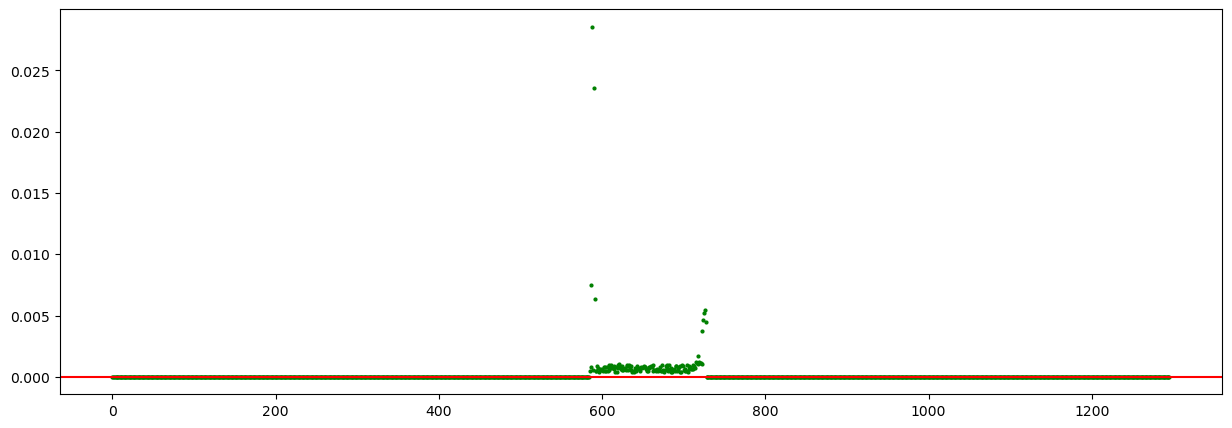

0:  1153
1: 143
---------- Type: 1 ----------
Epoch: [0 / 500], Loss: [0.255443246414264] Val score: [1.0]
--------------------
Loss: [0.255443246414264] Val score: [1.0]
--------------------
Loss: [0.0643424882243077] Val score: [1.0]
--------------------
Loss: [0.04218417499214411] Val score: [1.0]
--------------------
Loss: [0.03654577241589626] Val score: [1.0]
--------------------
Loss: [0.03063512220978737] Val score: [1.0]
--------------------
Loss: [0.029886746158202488] Val score: [1.0]
--------------------
Loss: [0.027572001640995342] Val score: [1.0]
--------------------
Loss: [0.027005143153170746] Val score: [1.0]
--------------------
Loss: [0.025658112950623035] Val score: [1.0]
Epoch: [10 / 500], Loss: [0.02086772055675586] Val score: [1.0]
--------------------
Loss: [0.02086772055675586] Val score: [1.0]
--------------------
Loss: [0.016062141085664432] Val score: [1.0]
--------------------
Loss: [0.007212791824713349] Val score: [1.0]
--------------------
Loss: [0.0021

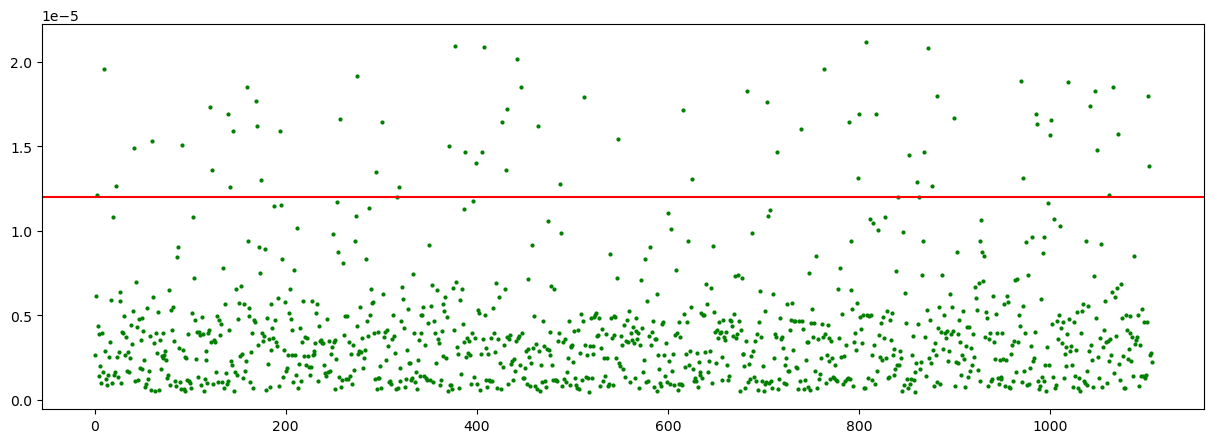

0:  1034
1: 73
---------- Type: 2 ----------
Epoch: [0 / 500], Loss: [0.546102836728096] Val score: [1.0]
--------------------
Loss: [0.546102836728096] Val score: [1.0]
--------------------
Loss: [0.1195587379237016] Val score: [1.0]
--------------------
Loss: [0.0537380917618672] Val score: [1.0]
--------------------
Loss: [0.043423193506896496] Val score: [1.0]
--------------------
Loss: [0.03483687558521827] Val score: [1.0]
--------------------
Loss: [0.03255302117516597] Val score: [1.0]
--------------------
Loss: [0.028694941351811092] Val score: [1.0]
--------------------
Loss: [0.02838853405167659] Val score: [1.0]
--------------------
Loss: [0.027630944425861042] Val score: [1.0]
Epoch: [10 / 500], Loss: [0.027249629919727642] Val score: [1.0]
--------------------
Loss: [0.027249629919727642] Val score: [1.0]
--------------------
Loss: [0.027085181636114914] Val score: [1.0]
--------------------
Loss: [0.02605289686471224] Val score: [1.0]
--------------------
Loss: [0.025151

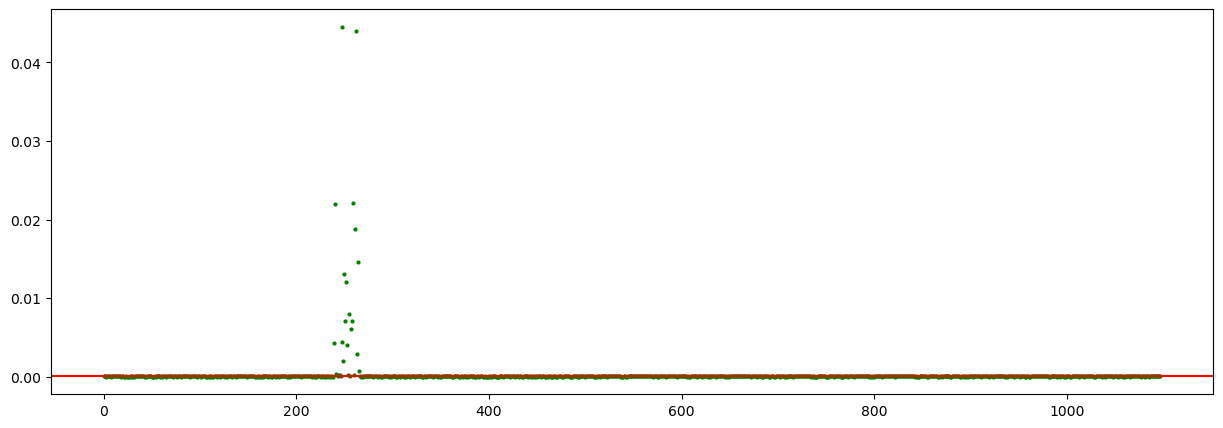

0:  1073
1: 25
---------- Type: 3 ----------
Epoch: [0 / 500], Loss: [1.3349751472473144] Val score: [1.0]
--------------------
Loss: [0.5395619034767151] Val score: [1.0]
--------------------
Loss: [0.19713682159781457] Val score: [1.0]
--------------------
Loss: [0.08824600875377656] Val score: [1.0]
--------------------
Loss: [0.051783645153045656] Val score: [1.0]
--------------------
Loss: [0.04452869184315204] Val score: [1.0]
--------------------
Loss: [0.04254458621144295] Val score: [1.0]
--------------------
Loss: [0.03879979699850082] Val score: [1.0]
Epoch: [10 / 500], Loss: [0.04025259166955948] Val score: [1.0]
--------------------
Loss: [0.0380193904042244] Val score: [1.0]
--------------------
Loss: [0.03779690414667129] Val score: [1.0]
--------------------
Loss: [0.0375773124396801] Val score: [1.0]
--------------------
Loss: [0.03728065602481365] Val score: [1.0]
--------------------
Loss: [0.0354417409747839] Val score: [1.0]
--------------------
Loss: [0.0332819540

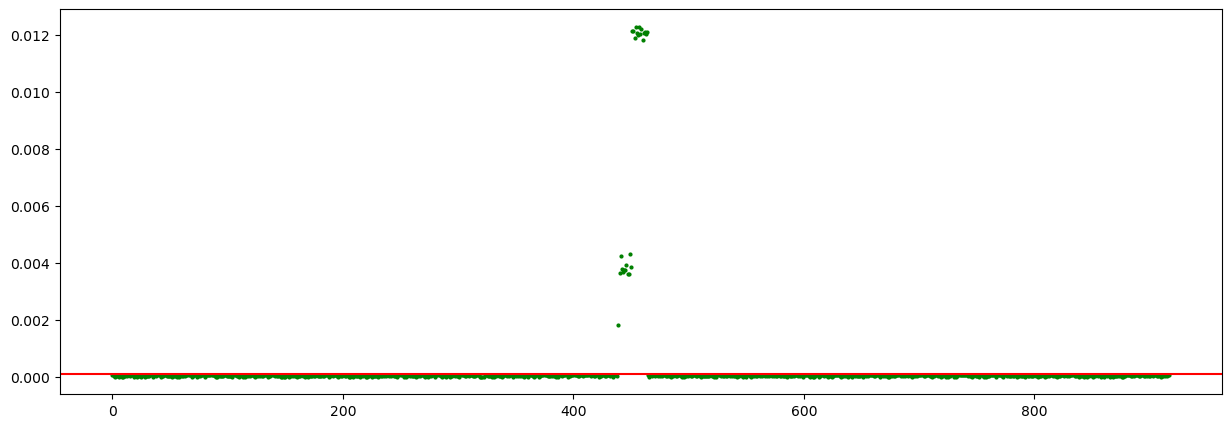

0:  892
1: 26
---------- Type: 4 ----------
Epoch: [0 / 500], Loss: [2.0487162113189696] Val score: [1.0]
--------------------
Loss: [0.2531560204923153] Val score: [1.0]
--------------------
Loss: [0.12950224056839943] Val score: [1.0]
--------------------
Loss: [0.1210403174161911] Val score: [1.0]
--------------------
Loss: [0.039401374757289886] Val score: [1.0]
--------------------
Loss: [0.03166709654033184] Val score: [1.0]
Epoch: [10 / 500], Loss: [0.032297127321362494] Val score: [1.0]
--------------------
Loss: [0.029926158860325812] Val score: [1.0]
--------------------
Loss: [0.029631919413805007] Val score: [1.0]
--------------------
Loss: [0.02951848804950714] Val score: [1.0]
Epoch: [20 / 500], Loss: [0.029664623737335204] Val score: [1.0]
--------------------
Loss: [0.029486718028783797] Val score: [1.0]
Epoch: [30 / 500], Loss: [0.029680359363555908] Val score: [1.0]
--------------------
Loss: [0.02940914183855057] Val score: [1.0]
--------------------
Loss: [0.0291785

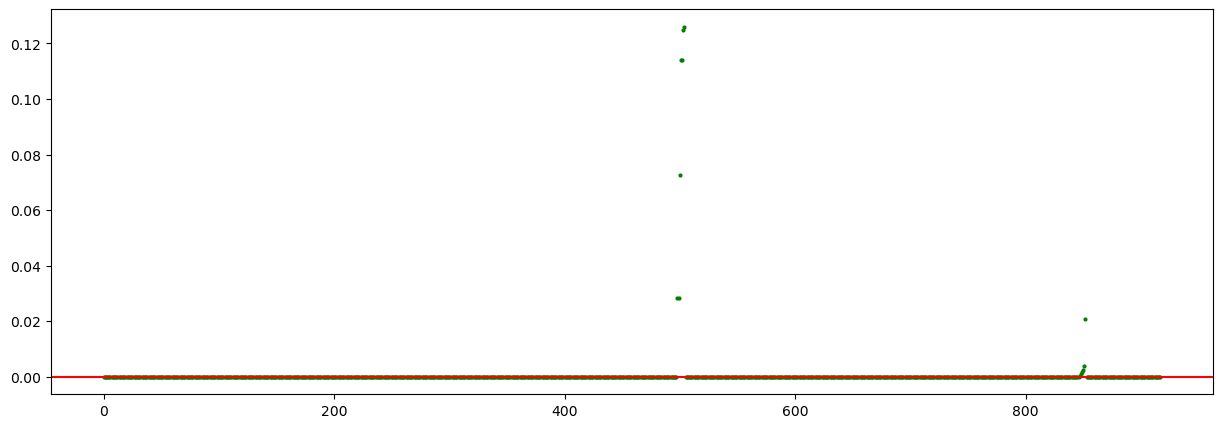

0:  901
1: 17
---------- Type: 5 ----------
Epoch: [0 / 500], Loss: [3.1265674233436584] Val score: [1.0]
--------------------
Loss: [0.7059928998351097] Val score: [1.0]
--------------------
Loss: [0.08836291171610355] Val score: [1.0]
--------------------
Loss: [0.04500074312090874] Val score: [1.0]
Epoch: [10 / 500], Loss: [0.03379733907058835] Val score: [1.0]
--------------------
Loss: [0.03379733907058835] Val score: [1.0]
--------------------
Loss: [0.03319630632176995] Val score: [1.0]
--------------------
Loss: [0.03140117507427931] Val score: [1.0]
--------------------
Loss: [0.03113874513655901] Val score: [1.0]
Epoch: [20 / 500], Loss: [0.03133413381874561] Val score: [1.0]
--------------------
Loss: [0.03104758122935891] Val score: [1.0]
--------------------
Loss: [0.031030515674501657] Val score: [1.0]
--------------------
Loss: [0.030967821832746267] Val score: [1.0]
--------------------
Loss: [0.030960573814809322] Val score: [1.0]
--------------------
Loss: [0.03094916

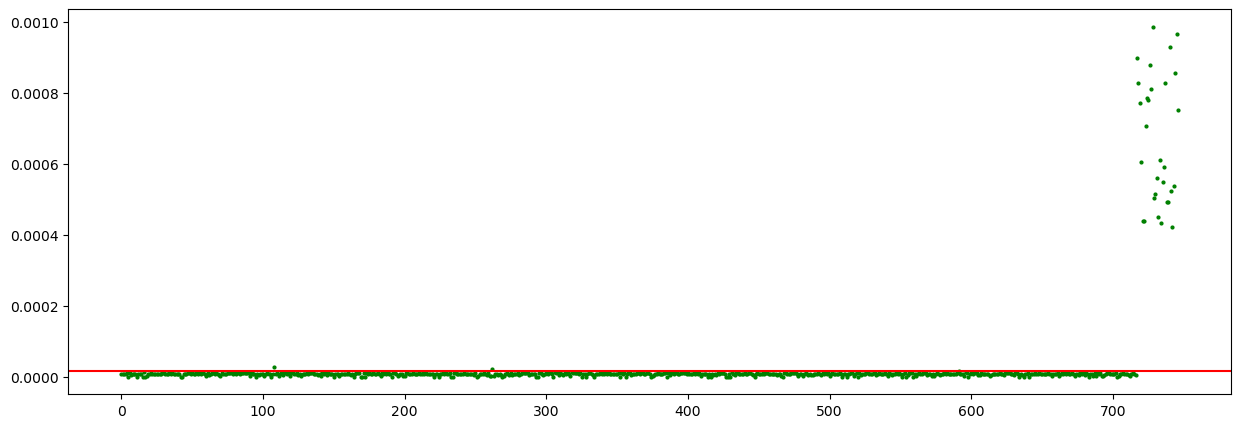

0:  715
1: 32
---------- Type: 6 ----------
Epoch: [0 / 500], Loss: [4.404201030731201] Val score: [1.0]
--------------------
Loss: [0.307120175100863] Val score: [1.0]
--------------------
Loss: [0.21964442543685436] Val score: [1.0]
--------------------
Loss: [0.08173167426139116] Val score: [1.0]
--------------------
Loss: [0.05613458622246981] Val score: [1.0]
Epoch: [10 / 500], Loss: [0.03874267730861902] Val score: [1.0]
--------------------
Loss: [0.03874267730861902] Val score: [1.0]
--------------------
Loss: [0.03559809550642967] Val score: [1.0]
--------------------
Loss: [0.03413458354771137] Val score: [1.0]
--------------------
Loss: [0.03125129034742713] Val score: [1.0]
--------------------
Loss: [0.030641965568065643] Val score: [1.0]
--------------------
Loss: [0.03021013829857111] Val score: [1.0]
--------------------
Loss: [0.029723366256803274] Val score: [1.0]
--------------------
Loss: [0.02967067575082183] Val score: [1.0]
Epoch: [20 / 500], Loss: [0.02973534585

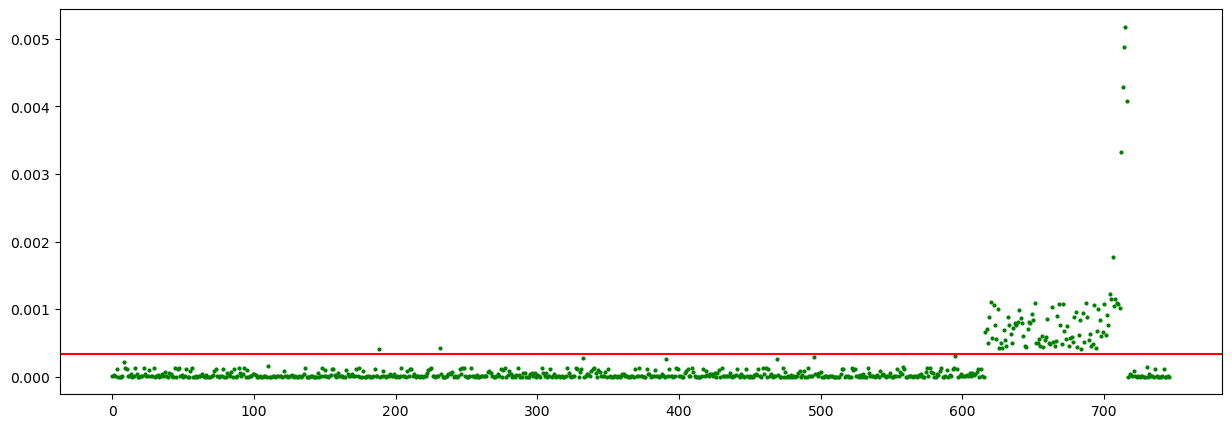

0:  644
1: 103
---------- Type: 7 ----------
Epoch: [0 / 500], Loss: [6.174799124399821] Val score: [1.0]
--------------------
Loss: [0.7057227243979772] Val score: [1.0]
--------------------
Loss: [0.1249089166522026] Val score: [1.0]
--------------------
Loss: [0.07910574227571487] Val score: [1.0]
Epoch: [10 / 500], Loss: [0.06627516448497772] Val score: [1.0]
--------------------
Loss: [0.06627516448497772] Val score: [1.0]
--------------------
Loss: [0.060741014778614044] Val score: [1.0]
--------------------
Loss: [0.04693662871917089] Val score: [1.0]
--------------------
Loss: [0.04046612481276194] Val score: [1.0]
--------------------
Loss: [0.03714435547590256] Val score: [1.0]
--------------------
Loss: [0.03652620315551758] Val score: [1.0]
Epoch: [20 / 500], Loss: [0.03421555086970329] Val score: [1.0]
--------------------
Loss: [0.03421555086970329] Val score: [1.0]
--------------------
Loss: [0.03389352808396021] Val score: [1.0]
--------------------
Loss: [0.03334242540

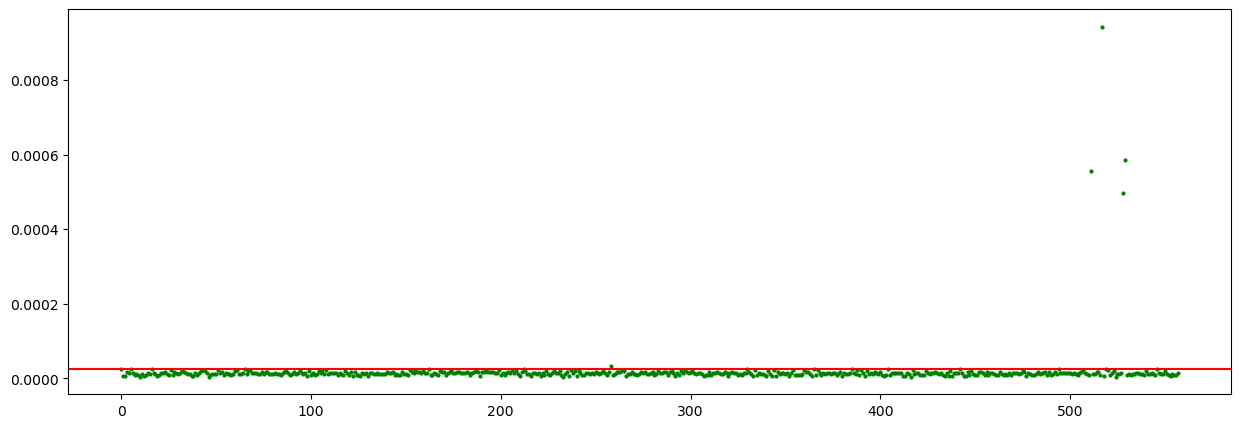

0:  553
1: 5
********** N_Training 1 **********
---------- Type: 0 ----------
Epoch: [0 / 500], Loss: [0.09147599246352911] Val score: [1.0]
--------------------
Loss: [0.09147599246352911] Val score: [1.0]
--------------------
Loss: [0.03321398598038488] Val score: [1.0]
--------------------
Loss: [0.0308849240342776] Val score: [1.0]
--------------------
Loss: [0.025319265201687813] Val score: [1.0]
--------------------
Loss: [0.004581530833901424] Val score: [1.0]
--------------------
Loss: [0.00035717565414314676] Val score: [1.0]
--------------------
Loss: [0.00025591719612647366] Val score: [1.0]
--------------------
Loss: [7.044793892418966e-05] Val score: [1.0]
--------------------
Loss: [3.842560125930403e-05] Val score: [1.0]
--------------------
Loss: [1.646001970180401e-05] Val score: [1.0]
Epoch: [10 / 500], Loss: [4.420573652118441e-06] Val score: [1.0]
--------------------
Loss: [4.420573652118441e-06] Val score: [1.0]
--------------------
Loss: [1.2992363988612649e-06] 

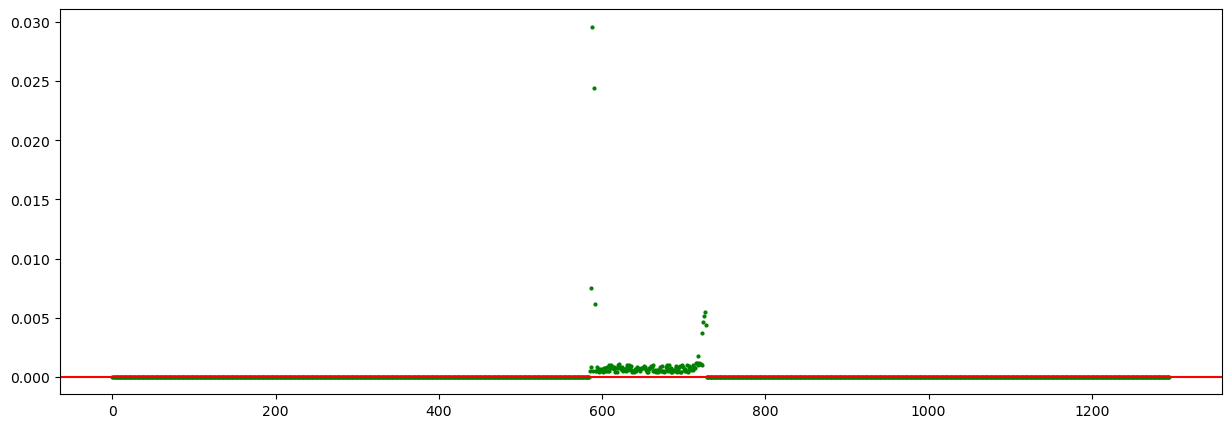

0:  1153
1: 143
---------- Type: 1 ----------
Epoch: [0 / 500], Loss: [0.12211525407345857] Val score: [1.0]
--------------------
Loss: [0.12211525407345857] Val score: [1.0]
--------------------
Loss: [0.03349729189101387] Val score: [1.0]
--------------------
Loss: [0.02933061692644568] Val score: [1.0]
--------------------
Loss: [0.02868011188419426] Val score: [1.0]
--------------------
Loss: [0.026604648898629582] Val score: [1.0]
--------------------
Loss: [0.011878000736674842] Val score: [1.0]
--------------------
Loss: [0.0011224765518871957] Val score: [1.0]
--------------------
Loss: [0.00014696995554806883] Val score: [1.0]
--------------------
Loss: [5.4154726165185875e-05] Val score: [1.0]
--------------------
Loss: [3.395092046369374e-05] Val score: [1.0]
Epoch: [10 / 500], Loss: [2.731935600262231e-05] Val score: [1.0]
--------------------
Loss: [2.731935600262231e-05] Val score: [1.0]
--------------------
Loss: [2.4749483533442425e-05] Val score: [1.0]
----------------

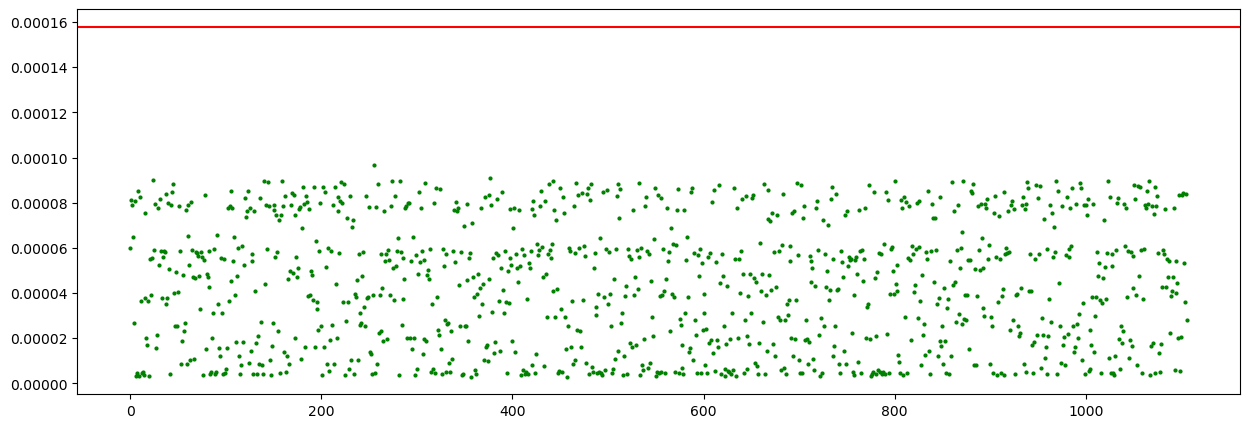

0:  1107
1: 0
---------- Type: 2 ----------
Epoch: [0 / 500], Loss: [0.25091147116001916] Val score: [1.0]
--------------------
Loss: [0.25091147116001916] Val score: [1.0]
--------------------
Loss: [0.043125990559073055] Val score: [1.0]
--------------------
Loss: [0.029502029256785616] Val score: [1.0]
--------------------
Loss: [0.02792113000417457] Val score: [1.0]
--------------------
Loss: [0.027608995599781767] Val score: [1.0]
--------------------
Loss: [0.027109990334686113] Val score: [1.0]
--------------------
Loss: [0.021734565715579426] Val score: [1.0]
--------------------
Loss: [0.003507924553773859] Val score: [1.0]
Epoch: [10 / 500], Loss: [0.0005046596013605321] Val score: [1.0]
--------------------
Loss: [0.0005046596013605321] Val score: [1.0]
--------------------
Loss: [9.205809970701332e-05] Val score: [1.0]
--------------------
Loss: [2.0772960076154797e-05] Val score: [1.0]
--------------------
Loss: [6.538435694464544e-06] Val score: [1.0]
--------------------

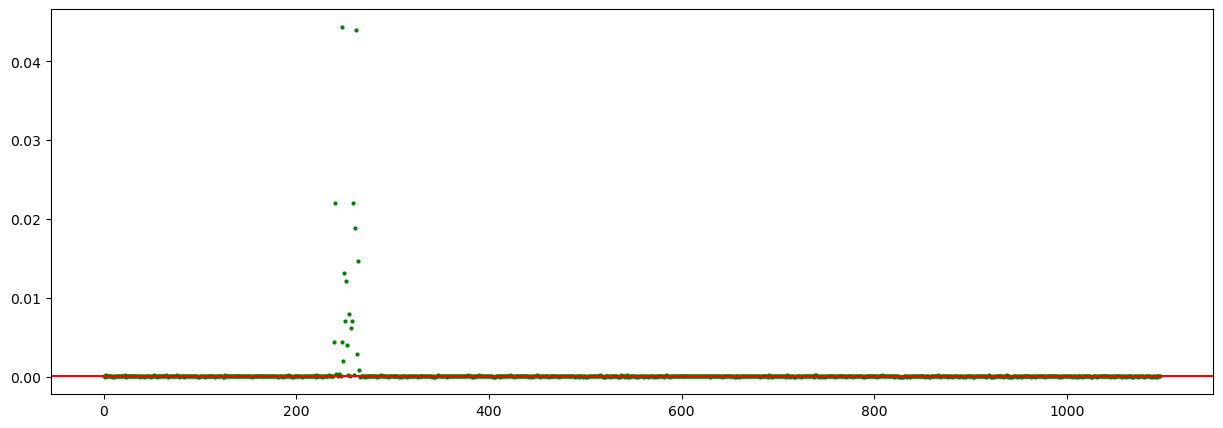

0:  1024
1: 74
---------- Type: 3 ----------
Epoch: [0 / 500], Loss: [0.6791094173987706] Val score: [1.0]
--------------------
Loss: [0.6791094173987706] Val score: [1.0]
--------------------
Loss: [0.08339799493551255] Val score: [1.0]
--------------------
Loss: [0.04654036437471708] Val score: [1.0]
--------------------
Loss: [0.039165372898181276] Val score: [1.0]
--------------------
Loss: [0.038135119279225665] Val score: [1.0]
--------------------
Loss: [0.03796147219836712] Val score: [1.0]
--------------------
Loss: [0.03543128184974194] Val score: [1.0]
--------------------
Loss: [0.029535696531335514] Val score: [1.0]
--------------------
Loss: [0.007050588494166732] Val score: [1.0]
--------------------
Loss: [0.001495958761855339] Val score: [1.0]
Epoch: [10 / 500], Loss: [0.00044760652914798506] Val score: [1.0]
--------------------
Loss: [0.00044760652914798506] Val score: [1.0]
--------------------
Loss: [0.00010455461670062504] Val score: [1.0]
--------------------
Los

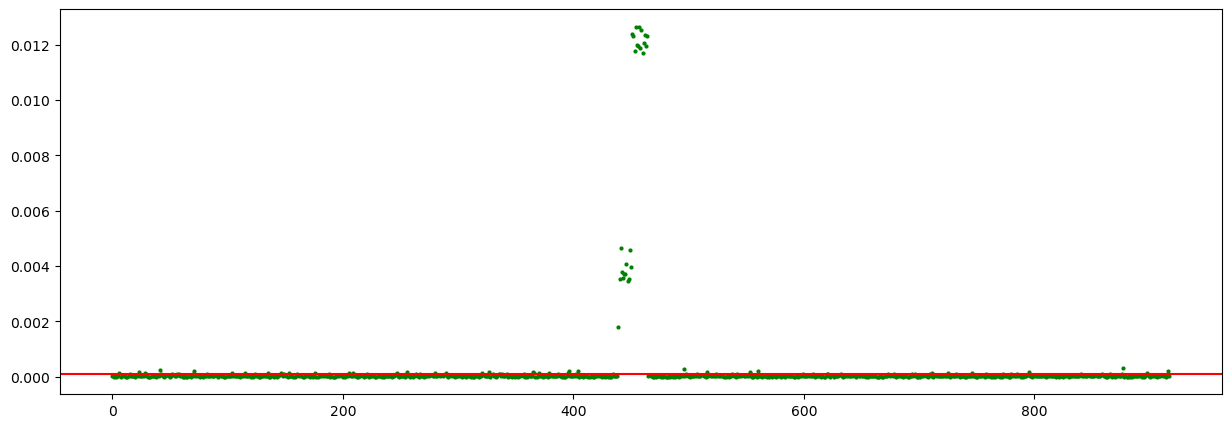

0:  843
1: 75
---------- Type: 4 ----------
Epoch: [0 / 500], Loss: [1.158130051692327] Val score: [1.0]
--------------------
Loss: [0.10262838080525398] Val score: [1.0]
--------------------
Loss: [0.04439643820126851] Val score: [1.0]
--------------------
Loss: [0.03207973937193553] Val score: [1.0]
--------------------
Loss: [0.03052958957850933] Val score: [1.0]
--------------------
Loss: [0.030099848036964735] Val score: [1.0]
--------------------
Loss: [0.029846376553177834] Val score: [1.0]
--------------------
Loss: [0.029550097261865933] Val score: [1.0]
--------------------
Loss: [0.029279895375172296] Val score: [1.0]
--------------------
Loss: [0.02846510025362174] Val score: [1.0]
Epoch: [10 / 500], Loss: [0.020838015899062156] Val score: [1.0]
--------------------
Loss: [0.020838015899062156] Val score: [1.0]
--------------------
Loss: [0.003491291271833082] Val score: [1.0]
--------------------
Loss: [0.0006633678819828977] Val score: [1.0]
--------------------
Loss: [0.

In [ ]:
ntr = 0
pick_ntr = 1 # 1 2 3
y_predictions = []
ntr_test_data = pd.DataFrame(columns = train_data.columns)
while True:
    print('*'*10, f'N_Training {ntr}', '*'*10)
    y_preds = []
    
    type_groups = {}
    for in_type in train_data['type'].unique():
        temp = train_data.loc[train_data['type'] == in_type]
        type_groups[f'{in_type}'] = temp

    type_groups_t = {}
    for in_type in test_data['type'].unique():
        temp = test_data.loc[test_data['type'] == in_type]
        type_groups_t[f'{in_type}'] = temp
    
    for idx in type_groups.keys():
        print('-'*10, f'Type: {idx}', '-'*10)
        
        train_data_ = type_groups[f'{idx}']
        test_data_ = type_groups_t[f'{idx}']

        train_data_ = train_data_.values
        test_data_ = test_data_.values

        train_data_ = train_data_.astype('float32')
        test_data_ = test_data_.astype('float32')

        num_epochs = 500
        batch_size = 64 #32 10
        learning_rate = 1e-3#0.001 1e-4 3e-4 1e-3 0.0002
        input_dim = 8
        # AutoEncoder의 hidden layer의 크기는 입력 크기보다 크거나 같아야하며, 보통 일반적으로 입력 크기의 2배 또는 4배 정도로 설정합니다. 따라서 input_size가 8이므로 hidden size는 16 또는 32 정도가 적당함
        # 그러나 모델의 구조와 학습 데이터의 복잡도 등 여러가지 요소에 따라 적절한 hidden size를 찾는 것이 중요. 따라서 hidden layer를 시도해보고 최적의 hidden size를 찾아내도록
        hidden_dim = [1024, 512, 256, 128, 64, 32, 16]
        dropout_rate = 0.25
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        #gan = GAN(input_dim, [16, 32, 64, 128, 256])
        #optimizer = torch.optim.Adam(gan.parameters(), lr=0.0001)
        #criterion = nn.BCELoss()
        #train_gan(gan, train_data_, 100, criterion, optimizer, device)
        #num_samples = 1000 #type_counts[int(idx)] train_data_.shape[0]//2
        #noise = torch.randn(num_samples, input_dim)
        #generated_data = gan.generator(noise)
        #generated_data = generated_data.detach().numpy()
        #train_data_ = np.concatenate((train_data_, generated_data), axis = 0)
        
        train_loader = DataLoader(train_data_, batch_size = batch_size, shuffle = True)
        test_loader = DataLoader(test_data_, batch_size = 1, shuffle = False)

        autoencoder = AutoEncoder(input_dim, hidden_dim, dropout_rate) # nn.DataParallel()
        optimizer = torch.optim.AdamW(autoencoder.parameters(), lr = learning_rate)
        #optimizer = Lion(gan.parameters(), lr = learning_rate, betas = (0.9, 0.99), weight_decay = 0.0) 
        #optimizer = torch.optim.RMSprop(autoencoder.parameters(), lr = learning_rate)
        #optimizer = torch.optim.SGD(autoencoder.parameters(), lr = learning_rate)
        
        criterion = nn.MSELoss()
        #criterion = nn.L1Loss()

        autoencoder = train_autoencoder(autoencoder, train_loader, num_epochs, criterion, optimizer, device)
        
        torch.save(autoencoder.state_dict(), f'type{idx}_autoencoder_weights.pth')
        #torch.save(gan.state_dict(), f'type{idx}_gan_weights.pth')
        
        y_pred = evaluate_autoencoder(autoencoder, test_loader, criterion, device)        

        y_preds.append(y_pred)    
    y_preds = list(itertools.chain(*y_preds))
    true_index = list(filter(lambda x: y_preds[x] == 0, range(len(y_preds))))
    #ntr_test_data.append(test_data.iloc[true_index])
    
    train_data = pd.concat([train_data, test_data.iloc[true_index]], axis = 0)
    train_data = train_data.drop_duplicates(keep = 'first')
    
    #if ntr <= pick_ntr - 1:
    #    ntr_test_data = ntr_test_data.drop_duplicates(keep = 'first')
    #    train_data = pd.concat([train_data, ntr_test_data], axis = 0)
    
    if ntr == pick_ntr:
        y_predictions.append(y_preds)
        break
        
    ntr += 1

answer_sample['label'] = y_predictions[0]
print(answer_sample.label.value_counts())
answer_sample.to_csv('autoencoder_type_iqr.csv',index = False)

---------- Type: 0 ----------
[1/300] Discriminator Loss: 0.693, Generator Loss: 0.693
[11/300] Discriminator Loss: 0.693, Generator Loss: 0.693
[21/300] Discriminator Loss: 0.693, Generator Loss: 0.693
[31/300] Discriminator Loss: 0.693, Generator Loss: 0.693
[41/300] Discriminator Loss: 0.693, Generator Loss: 0.693
[51/300] Discriminator Loss: 0.693, Generator Loss: 0.693
[61/300] Discriminator Loss: 0.693, Generator Loss: 0.693
[71/300] Discriminator Loss: 0.693, Generator Loss: 0.693
[81/300] Discriminator Loss: 0.693, Generator Loss: 0.693
[91/300] Discriminator Loss: 0.693, Generator Loss: 0.693
[101/300] Discriminator Loss: 0.693, Generator Loss: 0.693
[111/300] Discriminator Loss: 0.693, Generator Loss: 0.693
[121/300] Discriminator Loss: 0.693, Generator Loss: 0.693
[131/300] Discriminator Loss: 0.693, Generator Loss: 0.693
[141/300] Discriminator Loss: 0.693, Generator Loss: 0.693
[151/300] Discriminator Loss: 0.693, Generator Loss: 0.693
[161/300] Discriminator Loss: 0.693, 

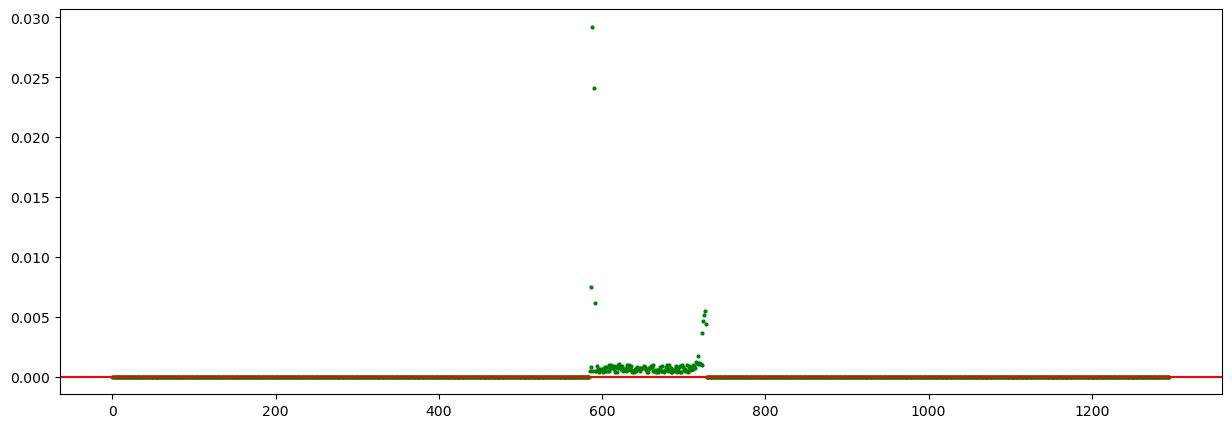

0:  1153
1: 143
---------- Type: 1 ----------
[1/300] Discriminator Loss: 0.685, Generator Loss: 0.704
[11/300] Discriminator Loss: 0.689, Generator Loss: 0.698
[21/300] Discriminator Loss: 0.692, Generator Loss: 0.694
[31/300] Discriminator Loss: 0.686, Generator Loss: 0.701
[41/300] Discriminator Loss: 0.693, Generator Loss: 0.694
[51/300] Discriminator Loss: 0.693, Generator Loss: 0.694
[61/300] Discriminator Loss: 0.692, Generator Loss: 0.694
[71/300] Discriminator Loss: 0.692, Generator Loss: 0.694
[81/300] Discriminator Loss: 0.693, Generator Loss: 0.693
[91/300] Discriminator Loss: 0.693, Generator Loss: 0.694
[101/300] Discriminator Loss: 0.691, Generator Loss: 0.696
[111/300] Discriminator Loss: 0.693, Generator Loss: 0.693
[121/300] Discriminator Loss: 0.693, Generator Loss: 0.693
[131/300] Discriminator Loss: 0.693, Generator Loss: 0.693
[141/300] Discriminator Loss: 0.693, Generator Loss: 0.693
[151/300] Discriminator Loss: 0.693, Generator Loss: 0.693
[161/300] Discriminat

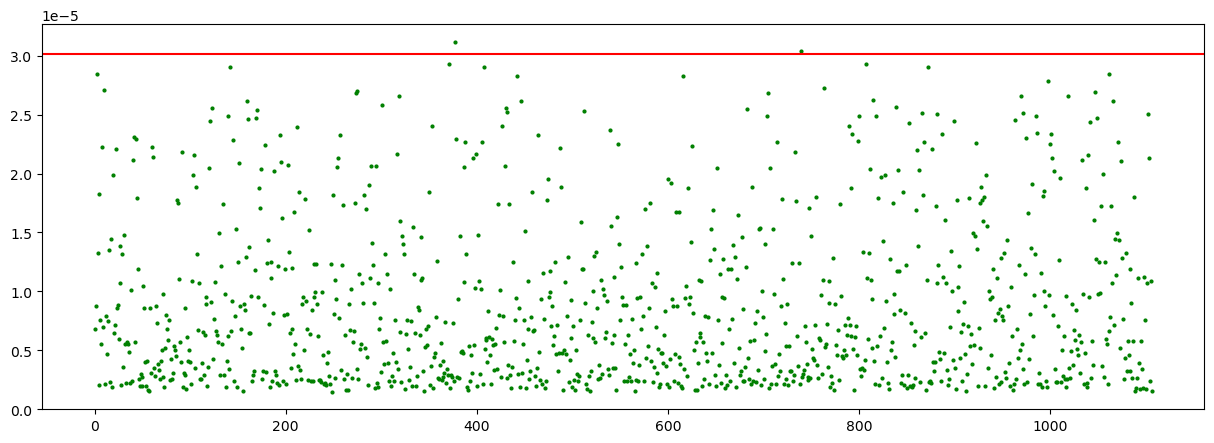

0:  1105
1: 2
---------- Type: 2 ----------
[1/300] Discriminator Loss: 0.698, Generator Loss: 0.689
[11/300] Discriminator Loss: 0.693, Generator Loss: 0.693
[21/300] Discriminator Loss: 0.693, Generator Loss: 0.693
[31/300] Discriminator Loss: 0.693, Generator Loss: 0.693
[41/300] Discriminator Loss: 0.693, Generator Loss: 0.693
[51/300] Discriminator Loss: 0.693, Generator Loss: 0.693
[61/300] Discriminator Loss: 0.693, Generator Loss: 0.693
[71/300] Discriminator Loss: 0.693, Generator Loss: 0.693
[81/300] Discriminator Loss: 0.693, Generator Loss: 0.693
[91/300] Discriminator Loss: 0.693, Generator Loss: 0.693
[101/300] Discriminator Loss: 0.693, Generator Loss: 0.693
[111/300] Discriminator Loss: 0.693, Generator Loss: 0.693
[121/300] Discriminator Loss: 100.693, Generator Loss: 0.693
[131/300] Discriminator Loss: 100.693, Generator Loss: 0.693
[141/300] Discriminator Loss: 0.693, Generator Loss: 0.693
[151/300] Discriminator Loss: 0.693, Generator Loss: 0.693
[161/300] Discrimin

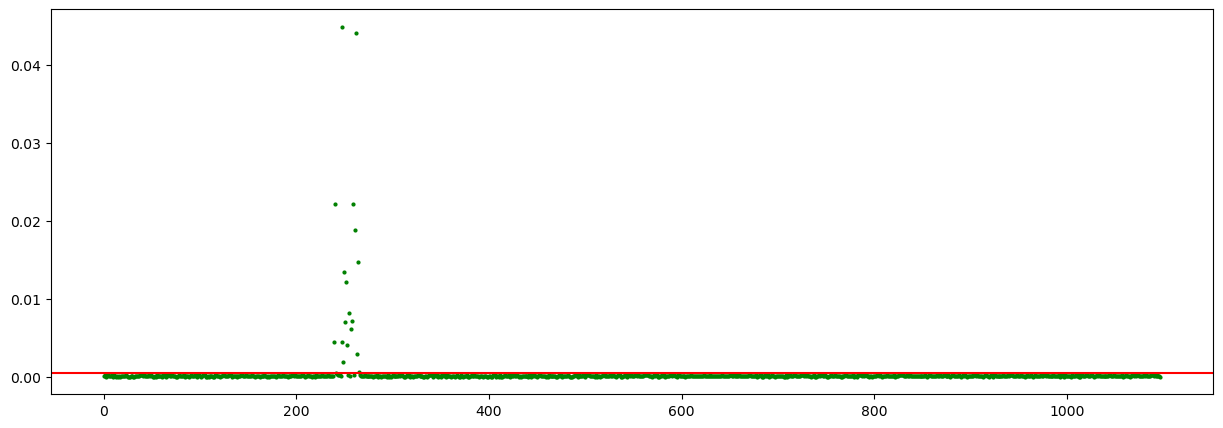

0:  1079
1: 19
---------- Type: 3 ----------
[1/300] Discriminator Loss: 0.702, Generator Loss: 0.685
[11/300] Discriminator Loss: 0.694, Generator Loss: 0.693
[21/300] Discriminator Loss: 0.694, Generator Loss: 0.693
[31/300] Discriminator Loss: 0.693, Generator Loss: 0.693
[41/300] Discriminator Loss: 0.693, Generator Loss: 0.693
[51/300] Discriminator Loss: 0.693, Generator Loss: 0.693
[61/300] Discriminator Loss: 0.694, Generator Loss: 0.693
[71/300] Discriminator Loss: 100.693, Generator Loss: 0.693
[81/300] Discriminator Loss: 100.693, Generator Loss: 0.693
[91/300] Discriminator Loss: 0.694, Generator Loss: 0.692
[101/300] Discriminator Loss: 0.694, Generator Loss: 0.692
[111/300] Discriminator Loss: 0.693, Generator Loss: 0.693
[121/300] Discriminator Loss: 0.694, Generator Loss: 0.692
[131/300] Discriminator Loss: 0.693, Generator Loss: 0.693
[141/300] Discriminator Loss: 0.693, Generator Loss: 0.693
[151/300] Discriminator Loss: 0.693, Generator Loss: 0.693
[161/300] Discrimi

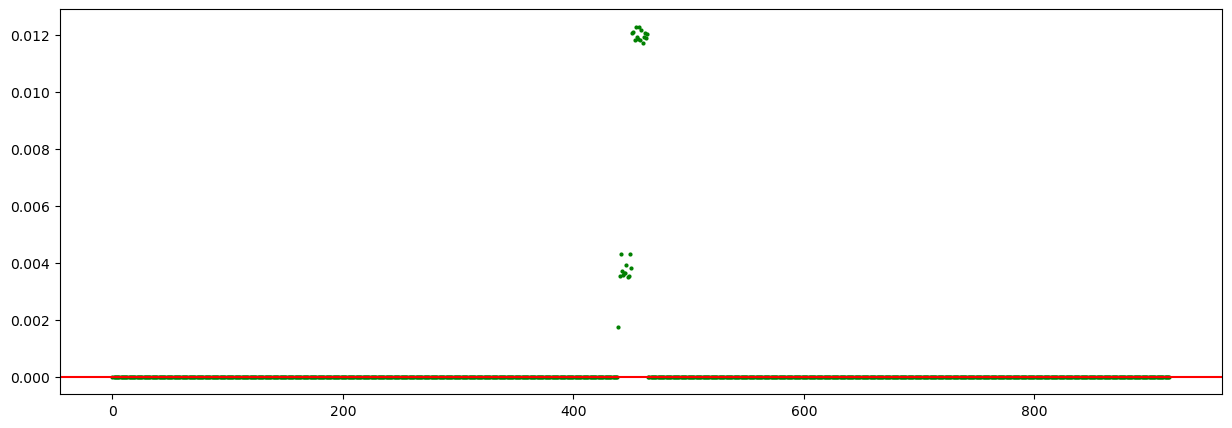

0:  892
1: 26
---------- Type: 4 ----------
[1/300] Discriminator Loss: 0.703, Generator Loss: 0.684
[11/300] Discriminator Loss: 0.694, Generator Loss: 0.692
[21/300] Discriminator Loss: 0.694, Generator Loss: 0.692
[31/300] Discriminator Loss: 0.694, Generator Loss: 0.692
[41/300] Discriminator Loss: 0.694, Generator Loss: 0.692
[51/300] Discriminator Loss: 0.694, Generator Loss: 0.693
[61/300] Discriminator Loss: 0.694, Generator Loss: 0.693
[71/300] Discriminator Loss: 0.694, Generator Loss: 0.693
[81/300] Discriminator Loss: 0.694, Generator Loss: 0.693
[91/300] Discriminator Loss: 0.694, Generator Loss: 0.693
[101/300] Discriminator Loss: 0.694, Generator Loss: 0.693
[111/300] Discriminator Loss: 0.694, Generator Loss: 0.693
[121/300] Discriminator Loss: 0.694, Generator Loss: 0.693
[131/300] Discriminator Loss: 0.694, Generator Loss: 0.693
[141/300] Discriminator Loss: 0.694, Generator Loss: 0.693
[151/300] Discriminator Loss: 0.694, Generator Loss: 0.693
[161/300] Discriminator

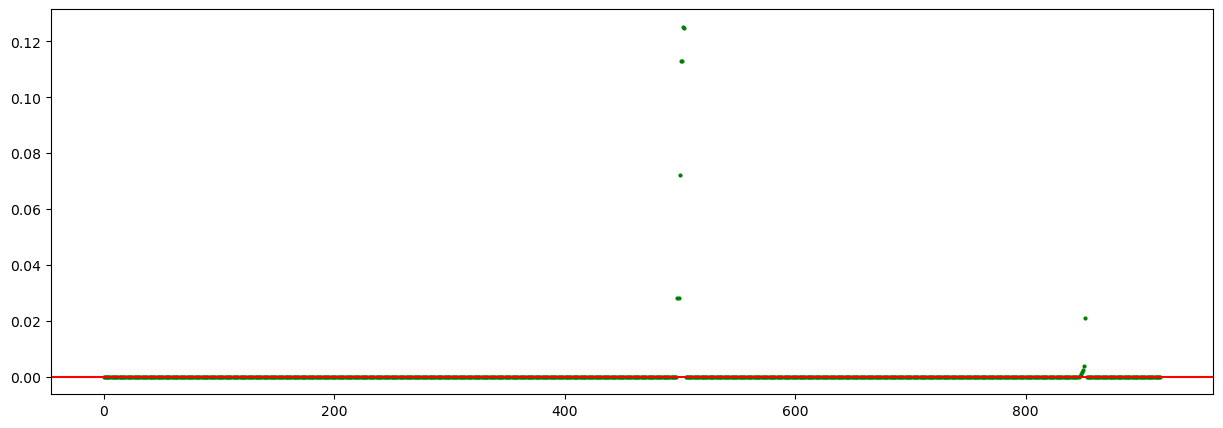

0:  901
1: 17
---------- Type: 5 ----------
[1/300] Discriminator Loss: 0.703, Generator Loss: 0.684
[11/300] Discriminator Loss: 0.694, Generator Loss: 0.692
[21/300] Discriminator Loss: 0.694, Generator Loss: 0.692
[31/300] Discriminator Loss: 0.694, Generator Loss: 0.692
[41/300] Discriminator Loss: 0.694, Generator Loss: 0.693
[51/300] Discriminator Loss: 0.702, Generator Loss: 0.685
[61/300] Discriminator Loss: 0.695, Generator Loss: 0.692
[71/300] Discriminator Loss: 0.694, Generator Loss: 0.693
[81/300] Discriminator Loss: 0.696, Generator Loss: 0.691
[91/300] Discriminator Loss: 0.694, Generator Loss: 0.692
[101/300] Discriminator Loss: 0.694, Generator Loss: 0.693
[111/300] Discriminator Loss: 0.694, Generator Loss: 0.693
[121/300] Discriminator Loss: 0.694, Generator Loss: 0.692
[131/300] Discriminator Loss: 0.694, Generator Loss: 0.693
[141/300] Discriminator Loss: 0.694, Generator Loss: 0.693
[151/300] Discriminator Loss: 0.693, Generator Loss: 0.693
[161/300] Discriminator

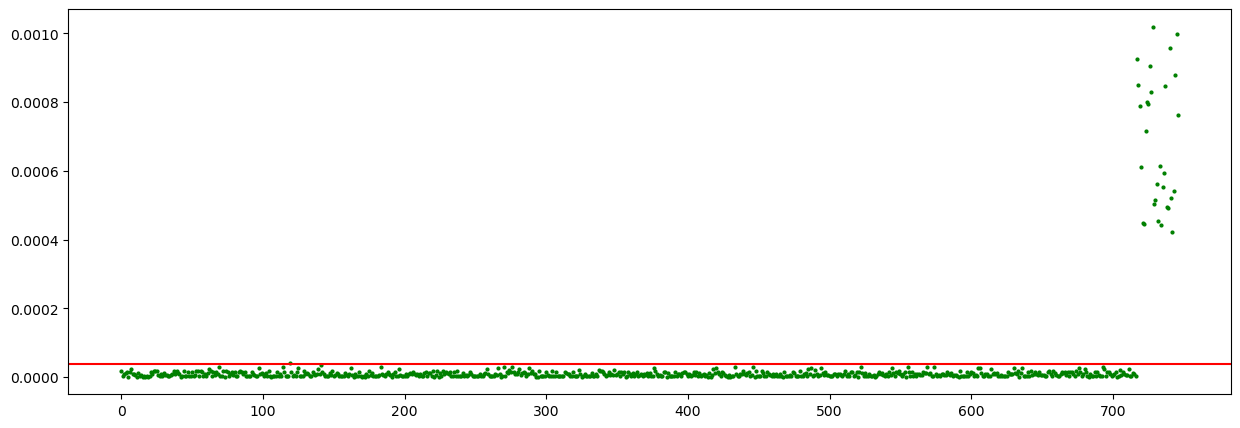

0:  716
1: 31
---------- Type: 6 ----------
[1/300] Discriminator Loss: 0.704, Generator Loss: 0.684
[11/300] Discriminator Loss: 0.694, Generator Loss: 0.692
[21/300] Discriminator Loss: 0.696, Generator Loss: 0.690
[31/300] Discriminator Loss: 0.694, Generator Loss: 0.693
[41/300] Discriminator Loss: 0.694, Generator Loss: 0.693
[51/300] Discriminator Loss: 0.694, Generator Loss: 0.693
[61/300] Discriminator Loss: 0.694, Generator Loss: 0.692
[71/300] Discriminator Loss: 0.694, Generator Loss: 0.693
[81/300] Discriminator Loss: 0.694, Generator Loss: 0.693
[91/300] Discriminator Loss: 0.694, Generator Loss: 0.693
[101/300] Discriminator Loss: 0.693, Generator Loss: 0.693
[111/300] Discriminator Loss: 0.693, Generator Loss: 0.693
[121/300] Discriminator Loss: 0.693, Generator Loss: 0.693
[131/300] Discriminator Loss: 0.693, Generator Loss: 0.693
[141/300] Discriminator Loss: 0.693, Generator Loss: 0.693
[151/300] Discriminator Loss: 0.693, Generator Loss: 0.693
[161/300] Discriminator

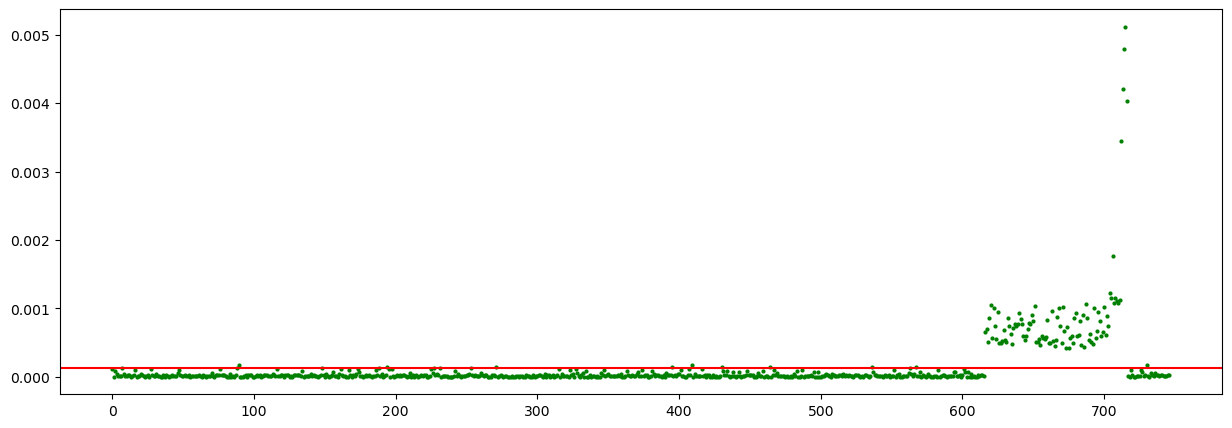

0:  633
1: 114
---------- Type: 7 ----------
[1/300] Discriminator Loss: 0.705, Generator Loss: 0.683
[11/300] Discriminator Loss: 0.699, Generator Loss: 0.688
[21/300] Discriminator Loss: 0.695, Generator Loss: 0.691
[31/300] Discriminator Loss: 0.696, Generator Loss: 0.691
[41/300] Discriminator Loss: 0.694, Generator Loss: 0.692
[51/300] Discriminator Loss: 0.694, Generator Loss: 0.692
[61/300] Discriminator Loss: 0.694, Generator Loss: 0.693
[71/300] Discriminator Loss: 0.694, Generator Loss: 0.693
[81/300] Discriminator Loss: 0.694, Generator Loss: 0.692
[91/300] Discriminator Loss: 0.694, Generator Loss: 0.692
[101/300] Discriminator Loss: 0.694, Generator Loss: 0.693
[111/300] Discriminator Loss: 0.694, Generator Loss: 0.693
[121/300] Discriminator Loss: 0.694, Generator Loss: 0.693
[131/300] Discriminator Loss: 0.694, Generator Loss: 0.693
[141/300] Discriminator Loss: 0.694, Generator Loss: 0.693
[151/300] Discriminator Loss: 0.694, Generator Loss: 0.693
[161/300] Discriminato

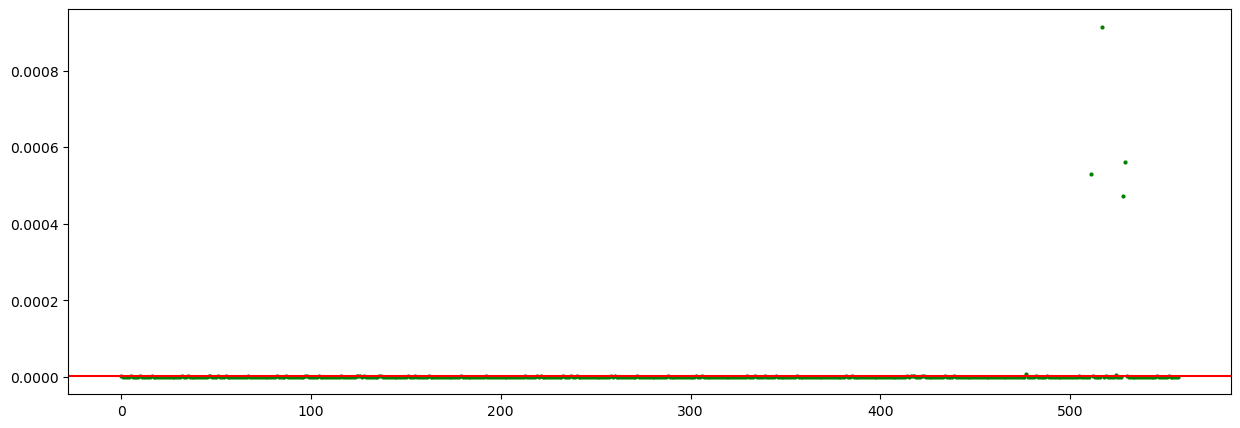

0:  543
1: 15
0    6970
1     419
Name: label, dtype: int64


In [87]:
y_preds = []
    
type_groups = {}
for in_type in train_data['type'].unique():
    temp = train_data.loc[train_data['type'] == in_type]
    type_groups[f'{in_type}'] = temp

type_groups_t = {}
for in_type in test_data['type'].unique():
    temp = test_data.loc[test_data['type'] == in_type]
    type_groups_t[f'{in_type}'] = temp
    
for idx in type_groups.keys():
    print('-'*10, f'Type: {idx}', '-'*10)
        
    train_data_ = type_groups[f'{idx}']
    test_data_ = type_groups_t[f'{idx}']

    train_data_ = train_data_.values
    test_data_ = test_data_.values
        
    train_data_ = train_data_.astype('float32')
    test_data_ = test_data_.astype('float32')

    num_epochs = 500
    batch_size = 64 #32 10
    learning_rate = 0.001 #0.001 1e-4 3e-4 1e-3 0.0002
    input_dim = 8
    # AutoEncoder의 hidden layer의 크기는 입력 크기보다 크거나 같아야하며, 보통 일반적으로 입력 크기의 2배 또는 4배 정도로 설정합니다. 따라서 input_size가 8이므로 hidden size는 16 또는 32 정도가 적당함
    # 그러나 모델의 구조와 학습 데이터의 복잡도 등 여러가지 요소에 따라 적절한 hidden size를 찾는 것이 중요. 따라서 hidden layer를 시도해보고 최적의 hidden size를 찾아내도록
    hidden_dim = [1024, 512, 256, 128, 64, 32, 16]
    dropout_rate = 0.25
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    gan = GAN(input_dim, [16, 32, 64, 128, 256, 512, 1024])
    #lr = 0.0002
    #num_epochs = 200
    optimizer = torch.optim.AdamW(gan.parameters(), lr=learning_rate, betas = (0.9, 0.999))
    criterion = nn.BCELoss()
    train_gan(gan, train_data_, 300, criterion, optimizer, device)
    num_samples = 1000 #type_counts[int(idx)] train_data_.shape[0]//2
    noise = torch.randn(num_samples, input_dim)
    generated_data = gan.generator(noise)
    generated_data = generated_data.detach().numpy()
    train_data_ = np.concatenate((train_data_, generated_data), axis = 0)
        
    train_loader = DataLoader(train_data_, batch_size = batch_size, shuffle = True)
    test_loader = DataLoader(test_data_, batch_size = 1, shuffle = False)

    autoencoder = AutoEncoder(input_dim, hidden_dim, dropout_rate) # nn.DataParallel()
    optimizer = torch.optim.AdamW(autoencoder.parameters(), lr = learning_rate)
    #optimizer = Lion(gan.parameters(), lr = learning_rate, betas = (0.9, 0.99), weight_decay = 0.0) 
    #optimizer = torch.optim.RMSprop(autoencoder.parameters(), lr = learning_rate)
    #optimizer = torch.optim.SGD(autoencoder.parameters(), lr = learning_rate)
        
    #criterion = nn.MSELoss()
    criterion = nn.L1Loss()

    autoencoder = train_autoencoder(autoencoder, train_loader, num_epochs, criterion, optimizer, device)
        
    torch.save(autoencoder.state_dict(), f'type{idx}_autoencoder1_weights.pth')
    torch.save(gan.state_dict(), f'type{idx}_gan1_weights.pth')
        
    y_pred = evaluate_autoencoder(autoencoder, test_loader, criterion, device)        

    y_preds.append(y_pred)    
y_preds = list(itertools.chain(*y_preds))
true_index = list(filter(lambda x: y_preds[x] == 0, range(len(y_preds))))

answer_sample['label'] = y_preds
print(answer_sample.label.value_counts())
answer_sample.to_csv('ganautoencode1_type_iqr.csv',index = False)

비지도 학습으로 신용카드 사기 검출 문제를 해결하는 방법 중 하나는 생성 적대 신경망(GAN, Generative Adversarial Networks)을 사용하는 것입니다. GAN은 생성자와 판별자 두 개의 신경망으로 이루어져 있으며, 생성자는 진짜와 구분하기 어려운 가짜 데이터를 생성하고, 판별자는 그것이 진짜인지 가짜인지 판별합니다. 생성자와 판별자가 서로 대립하며 학습을 진행하며, 결과적으로 생성자는 진짜와 구분하기 어려운 가짜 데이터를 생성할 수 있게 되고, 판별자는 진짜와 가짜를 구분하는 능력을 강화합니다.

GAN을 사용하여 신용카드 사기 검출 문제를 해결하는 방법 중 하나는, 생성자가 가짜 신용카드 거래를 생성하고, 판별자가 이를 판별하여 신용카드 사기 거래를 감지하는 것입니다. 이를 위해 데이터셋을 학습용 데이터와 테스트용 데이터로 나누고, 생성자와 판별자를 학습시킵니다. 그 다음, 학습된 생성자를 사용하여 가짜 신용카드 거래를 생성하고, 판별자를 사용하여 이를 판별합니다. 이를 반복하여 생성자가 더욱 실제와 유사한 가짜 신용카드 거래를 생성할 수 있게 하고, 판별자가 더욱 정확하게 신용카드 사기 거래를 감지할 수 있게 합니다.

GAN을 사용하여 신용카드 사기 검출 문제를 해결하는 코드는 다음과 같은 순서로 진행될 수 있습니다.

데이터셋을 다운로드하고 전처리합니다.
생성자와 판별자 모델을 구현하고 학습합니다.
생성자를 사용하여 가짜 신용카드 거래를 생성하고, 판별자를 사용하여 이를 판별합니다.
학습을 반복하며 생성자와 판별자를 개선합니다.

- VAE
- AnoGAN
- CGAN
- WGAN
- WCGAN

### **GAN Augmentation AutoEncoder**

신용카드 사기검출 문제고
학습 데이터는 정상 데이터만 존재하며
테스트 데이터는 정상 데이터와 비정상 데이터를 포함합니다.
하지만 라벨은 주어지지 않았습니다. input_dim은 8입니다.
GAN, AutoEncoder, PCA 모델을 앙상블하고 비지도학습으로 비정상 데이터를 검출하는 코드를 pytorch로 작성해주세요.

credit card fraud detection
Only normal data exists as training data.
Test data includes normal and abnormal data.
But no label was given. input_dim is 8.
Write a code using pytorch to ensemble GAN, AutoEncoder, and PCA models and detect abnormal data through unsupervised learning.

In [83]:
class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Generator, self).__init__()
        self.hidden_layer = nn.ModuleList()
        input_size = input_dim
        for idx, hidden_size in enumerate(hidden_dim):
            self.hidden_layer.append(nn.Linear(input_size, hidden_size))
            self.hidden_layer.append(nn.ReLU(inplace = True))
            input_size = hidden_size
        self.hidden_layer.append(nn.Linear(input_size, input_dim))
        self.hidden_layer.append(nn.Tanh())
        
    def forward(self, x):
        x = nn.Sequential(*self.hidden_layer)(x)
        return x
    
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Discriminator, self).__init__()
        self.hidden_layer = nn.ModuleList()
        input_size = input_dim
        for hidden_size in reversed(hidden_dim):
            self.hidden_layer.append(nn.Linear(input_size, hidden_size))
            self.hidden_layer.append(nn.ReLU())
            input_size = hidden_size
        self.hidden_layer.append(nn.Linear(input_size, 1))
        self.hidden_layer.append(nn.Sigmoid())
        
    def forward(self, x):
        x = nn.Sequential(*self.hidden_layer)(x)
        return x
    
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout_rate):
        super(AutoEncoder, self).__init__()
        self.encoder_layers = nn.ModuleList()
        
        input_size = input_dim
        for idx, hidden_size in enumerate(hidden_dim):
            self.encoder_layers.append(nn.Linear(input_size, hidden_size))
            self.encoder_layers.append(nn.ReLU(inplace = True))
            input_size = hidden_size
        
        self.decoder_layers = nn.ModuleList()
        input_size = hidden_dim[-1]
        for hidden_size in reversed(hidden_dim[:-1]):
            self.decoder_layers.append(nn.Linear(input_size, hidden_size))
            self.decoder_layers.append(nn.ReLU(inplace = True))
            input_size = hidden_size
        self.decoder_layers.append(nn.Linear(input_size, input_dim))
        
    def forward(self, x):
        encoded = x
        for layer in self.encoder_layers:
            encoded = layer(encoded)
            
        decoded = encoded
        for layer in self.decoder_layers:
            decoded = layer(decoded)
        
        return decoded

**번역결과**

물론입니다. 제가 도와드릴 수 있습니다! 관련된 단계에 대한 대략적인 개요는 다음과 같습니다.


학습 데이터(일반 데이터만)를 PyTorch 텐서에 로드합니다.


일반 데이터의 기본 분포를 학습하기 위해 GAN(Generative Adversarial Network)을 정의하고 훈련합니다. GAN은 Generator와 Discriminator 네트워크로 구성됩니다. 생성기 네트워크는 임의의 노이즈를 입력으로 받아 가짜 데이터를 생성하는 반면, 판별기 네트워크는 가짜 데이터와 실제 데이터를 구별하려고 합니다. GAN은 discriminator가 둘을 구별하는 능력을 최소화하도록 훈련되었습니다.


Autoencoder(AE)를 정의하고 훈련하여 일반 데이터의 압축된 표현을 학습합니다. AE는 인코더 네트워크와 디코더 네트워크로 구성됩니다. 인코더 네트워크는 입력 데이터를 저차원 표현에 매핑하는 반면 디코더 네트워크는 저차원 표현을 원래 데이터에 다시 매핑합니다. AE는 입력 데이터와 출력 데이터 간의 재구성 오류를 최소화하도록 훈련됩니다.


PCA(Principal Component Analysis)를 사용하여 일반 데이터의 차원을 줄입니다. PCA는 데이터의 가장 중요한 특징이나 구성 요소를 찾는 기술입니다. 데이터 공분산 행렬의 고유 벡터와 고유 값을 찾은 다음 데이터를 주성분에 투영하여 이를 수행합니다.


학습된 GAN, AE 및 PCA 모델을 사용하여 테스트 데이터에서 비정상적인 데이터를 감지합니다. 테스트 데이터의 각 데이터 요소에 대해 다음을 수행합니다.


ㅏ. GAN을 사용하여 무작위 노이즈에서 가짜 데이터 포인트를 생성합니다.


비. AE를 사용하여 실제 및 가짜 데이터 포인트를 저차원 표현으로 인코딩합니다.


씨. PCA를 사용하여 실제 및 가짜 데이터 포인트를 주성분에 투영합니다.


디. 실제 데이터 포인트와 가짜 데이터 포인트 모두에 대해 원본 데이터와 AE의 출력 데이터 간의 재구성 오류를 계산합니다.


이자형. 주성분과 PCA의 고유값을 사용하여 투영된 실제 데이터 점과 투영된 가짜 데이터 점 사이의 Mahalanobis 거리를 계산합니다.


에프. 일부 가중 조합을 사용하여 재구성 오류와 Mahalanobis 거리를 단일 이상 점수로 결합합니다.


g. 이상 점수가 특정 임계값을 초과하면 데이터 포인트를 비정상으로 플래그 지정합니다.

Mahalanobis distance는 비지도 학습에서 이상치 탐지에 자주 사용되는 기법 중 하나이며, autoencoder, GAN, PCA 등을 앙상블한 모델에서 anomaly score로 사용할 수 있습니다.

Mahalanobis distance를 anomaly score로 사용하는 것은 일반적으로 좋은 결과를 얻을 수 있습니다. 이는 Mahalanobis distance가 데이터의 공분산을 고려하여 거리를 계산하기 때문에, 이상치에 대해 더 민감한 거리 척도가 되기 때문입니다.

하지만 Mahalanobis distance 외에도 여러 다른 거리 계산 방법이 있습니다. 예를 들어, Euclidean distance, Manhattan distance, Chebyshev distance, Cosine distance 등이 있습니다. 이러한 거리 계산 방법은 각각 데이터의 특성에 따라 더 나은 결과를 얻을 수 있습니다.

따라서, Mahalanobis distance 외에도 다양한 거리 계산 방법을 비교하여 가장 적합한 방법을 선택하는 것이 좋습니다. 또한, 앙상블 모델에서 다른 기법을 결합하여 사용할 수 있으며, 이 경우 여러 기법을 결합한 이상치 탐지 모델의 성능을 최적화하는 것이 중요합니다.

Q: 사기 검출 문제에서 비지도 학습 오토인코더로 학습하고 평가했을때 재구성오차가 낮으면 이상치가 아니지?

재구성 오차는 오토인코더 모델이 입력 데이터를 얼마나 정확하게 재구성할 수 있는지를 나타내는 지표입니다. 비지도 학습 오토인코더로 학습한 모델을 사용하여 사기 검출 문제를 해결할 때, 일반적으로 이상치로 판단되는 데이터의 재구성 오차가 높게 나타납니다. 따라서, 재구성 오차가 낮다면 해당 데이터가 정상적인 데이터일 가능성이 높아집니다.

하지만 재구성 오차가 낮다고 반드시 해당 데이터가 정상적인 데이터일 가능성이 높다는 것은 아닙니다. 사기 검출 문제에서는 정상적인 데이터와 이상치인 사기 데이터의 차이가 크기 때문에, 이상치로 판단되는 데이터의 재구성 오차가 정상적인 데이터의 재구성 오차보다 높아질 수 있습니다. 또한, 사기 검출 문제에서는 이상치가 극히 일부분이기 때문에 재구성 오차만으로 이상치를 검출하는 것이 어렵습니다.

따라서, 사기 검출 문제에서는 재구성 오차 외에도 다른 지표를 사용하여 모델의 성능을 평가해야 합니다. 예를 들어, 이상치 검출 문제에서는 Precision, Recall, F1-Score 등의 지표를 사용하여 모델의 성능을 평가할 수 있습니다. 이러한 지표를 사용하여 모델의 성능을 평가하면 재구성 오차만으로는 놓치기 쉬운 이상치를 더 정확하게 검출할 수 있습니다.

# **H2O.AutoEncoder**

In [219]:
import h2o
from h2o.estimators.deeplearning import H2OAutoEncoderEstimator, H2ODeepLearningEstimator
from pylab import rcParams

In [220]:
h2o.init(max_mem_size = 2) # h2o 서버 초기화 
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,56 mins 48 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.2
H2O_cluster_version_age:,1 month and 6 days
H2O_cluster_name:,H2O_from_python_unknownUser_oleaoi
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.871 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [221]:
anomaly_model = H2ODeepLearningEstimator(activation = "tanh",
                                hidden = [1024, 512, 256, 128, 64, 32, 16],
                                epochs = 500,
                                stopping_metric = 'MSE', 
                                loss = 'automatic',
                                shuffle_training_data = True,     
                                autoencoder = True,
                                seed = SEED)
                    
# anomaly_model = H2OAutoEncoderEstimator(activation="Tanh", 
#                                 hidden=[100, 20], 
#                                 l1=1e-5, 
#                                 ignore_const_cols=False, 
#                                 autoencoder=True,
#                                 epochs=500)

In [222]:
train_data

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,type
0,0.213198,0.267681,0.0,0.221235,0.203046,0.259444,0.248705,0
1,0.446701,0.813190,0.0,0.481503,0.821489,0.766469,0.461140,0
2,0.267343,0.395703,0.0,0.282406,0.348139,0.378395,0.297927,0
3,0.345178,0.575947,0.0,0.368337,0.552453,0.545738,0.367876,0
4,0.265651,0.393315,0.0,0.281241,0.345601,0.376210,0.297927,0
...,...,...,...,...,...,...,...,...
2458,0.329949,0.542226,0.0,0.352316,0.514382,0.514518,0.354922,7
2459,0.289340,0.444942,0.0,0.305855,0.403976,0.423978,0.318653,7
2460,0.145516,0.110713,0.0,0.146373,0.024958,0.113331,0.189119,7
2461,0.148900,0.118472,0.0,0.150015,0.033841,0.120512,0.191710,7


********** N_Training 0 **********
---------- Type: 0 ----------
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
deeplearning Model Build progress: |

/opt/conda/lib/python3.7/site-packages/h2o/estimators/estimator_base.py:193: RuntimeWarning: Dropping bad and constant columns: [out_pressure]
  warnings.warn(mesg["message"], RuntimeWarning)


█████████████████████████████████████████████| (done) 100%


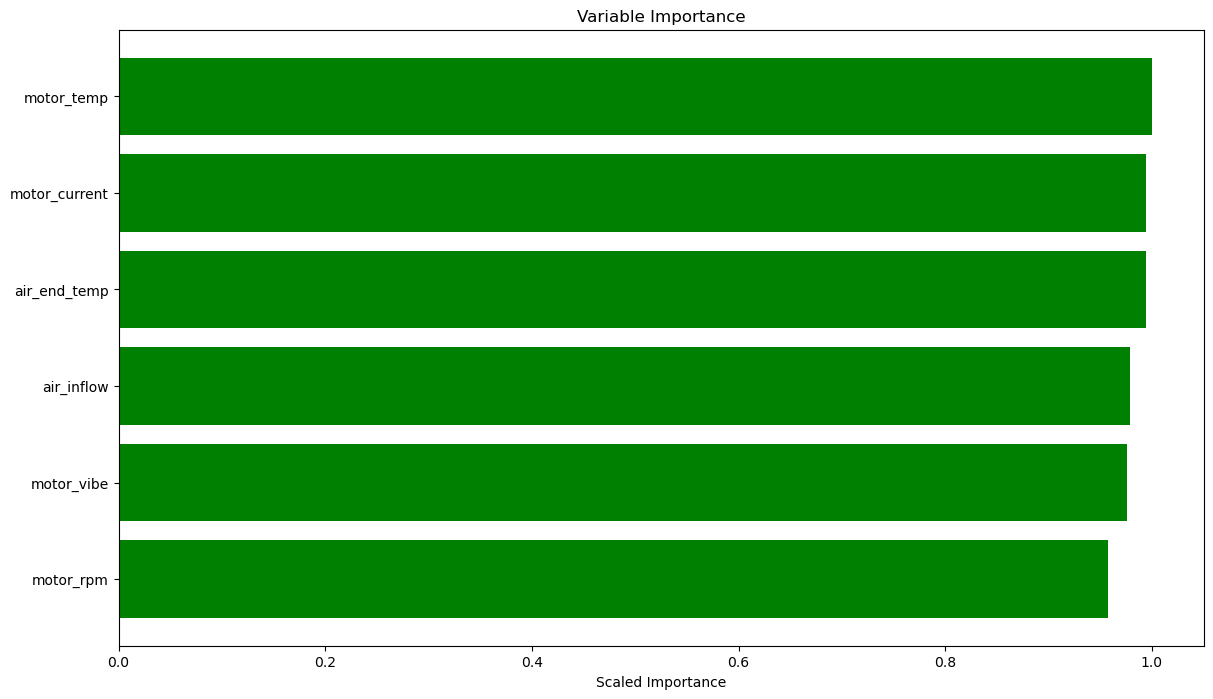

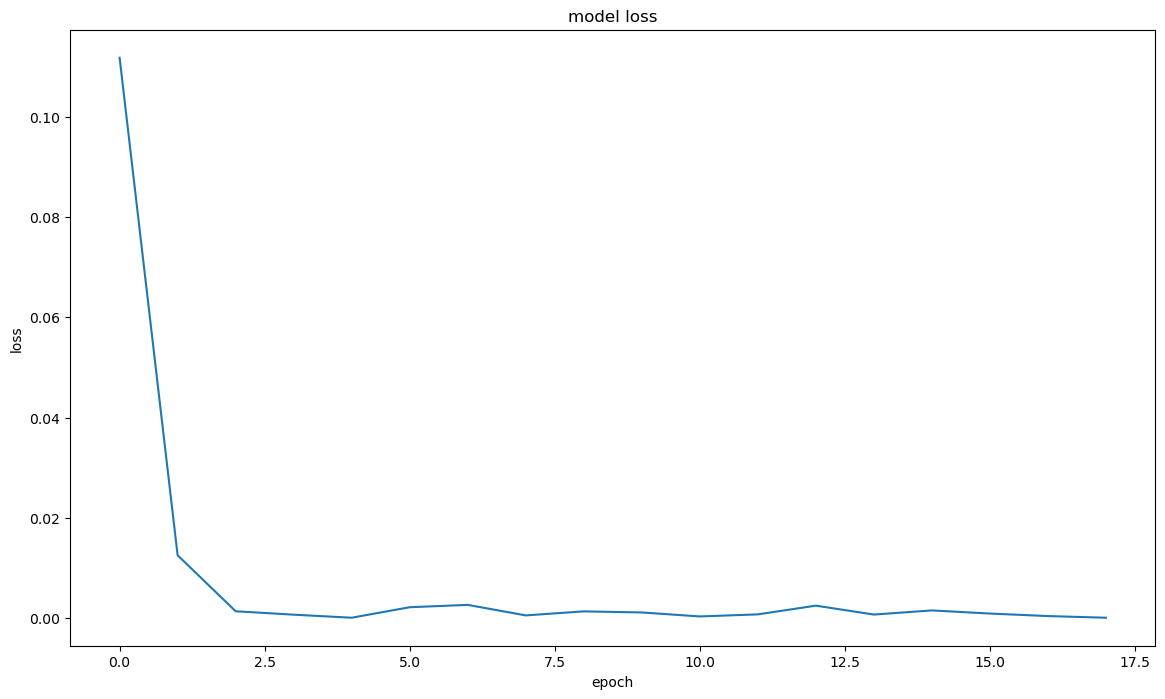

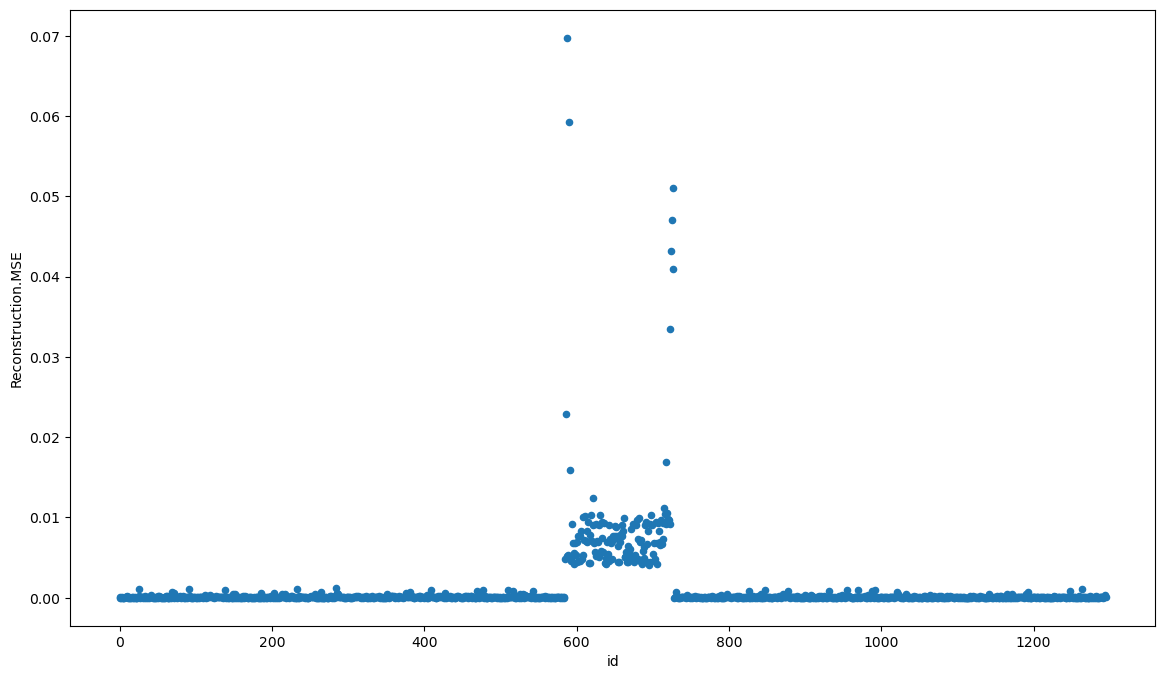

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


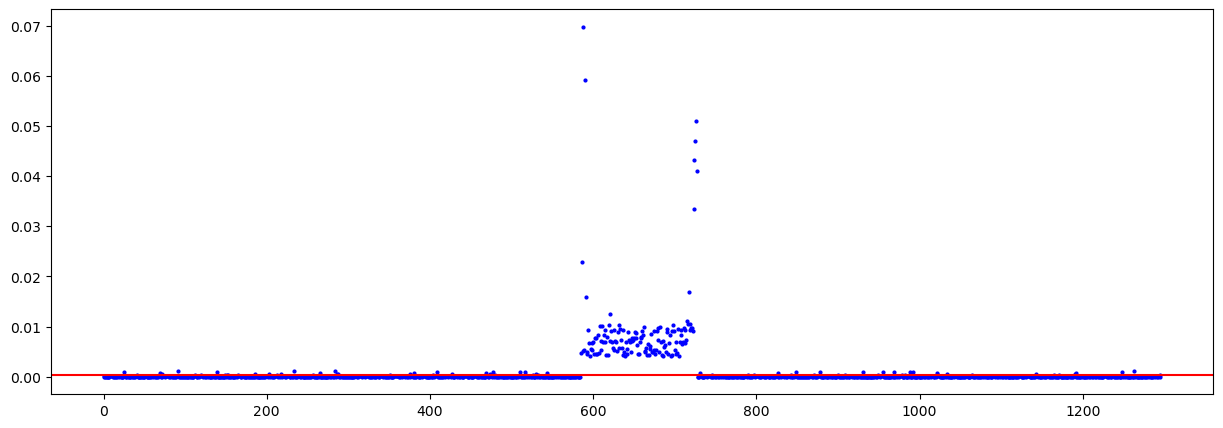

0:  1082
1: 214
---------- Type: 1 ----------
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%


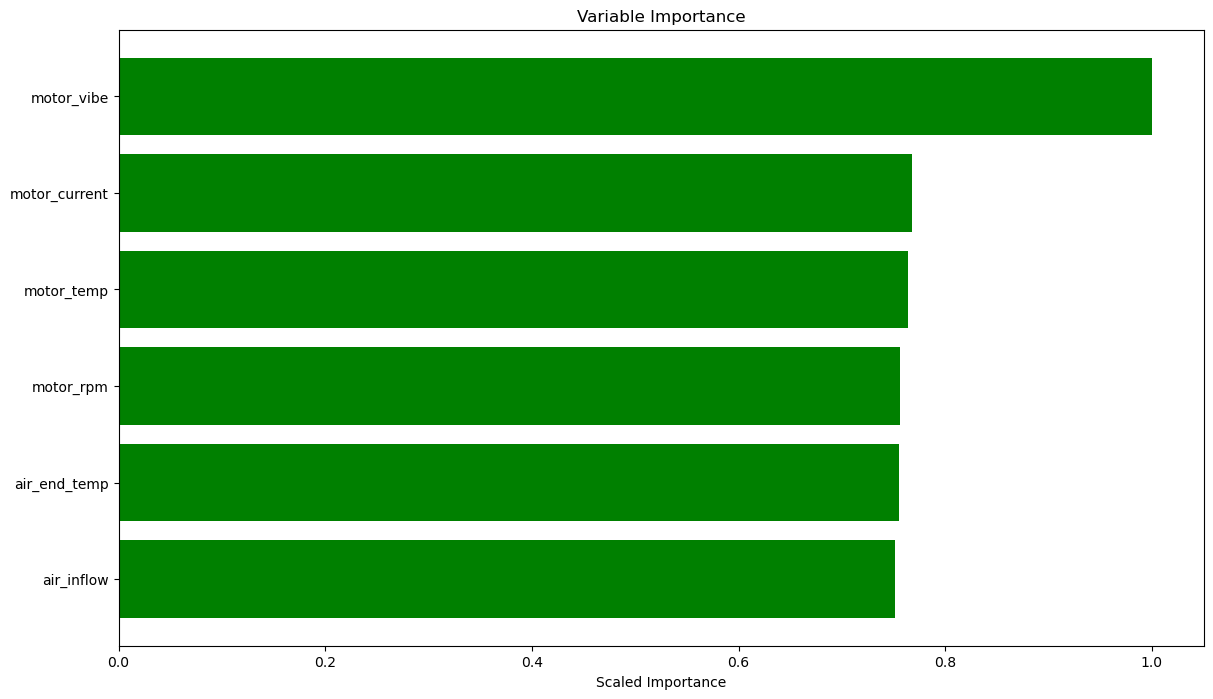

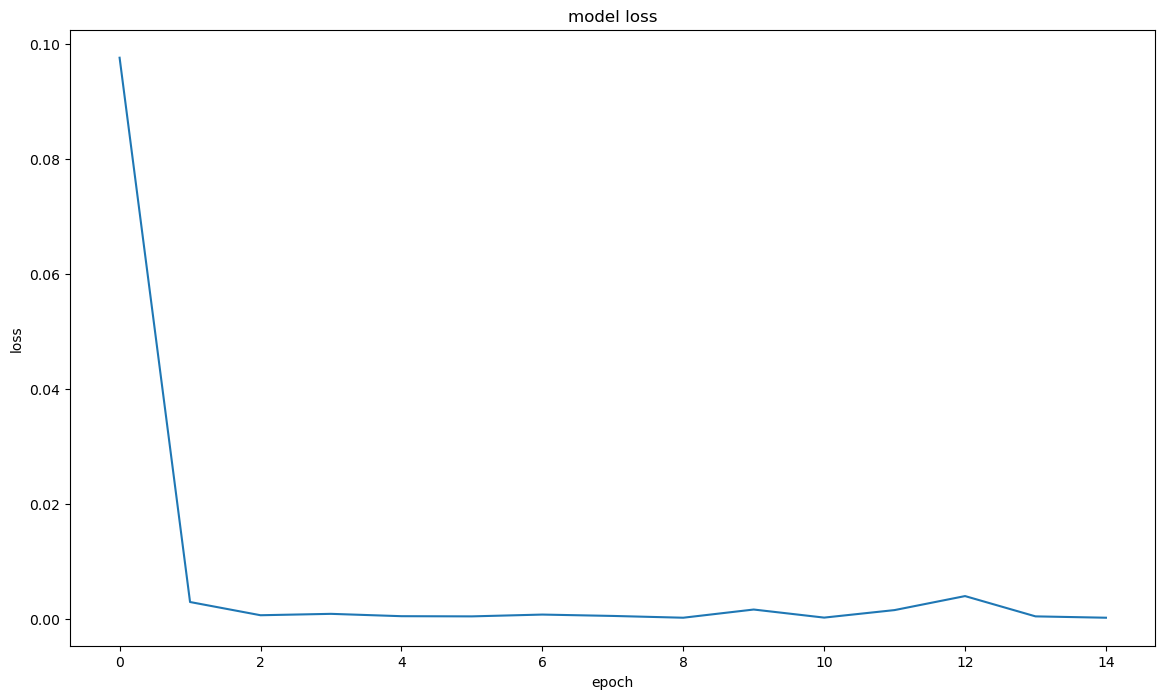

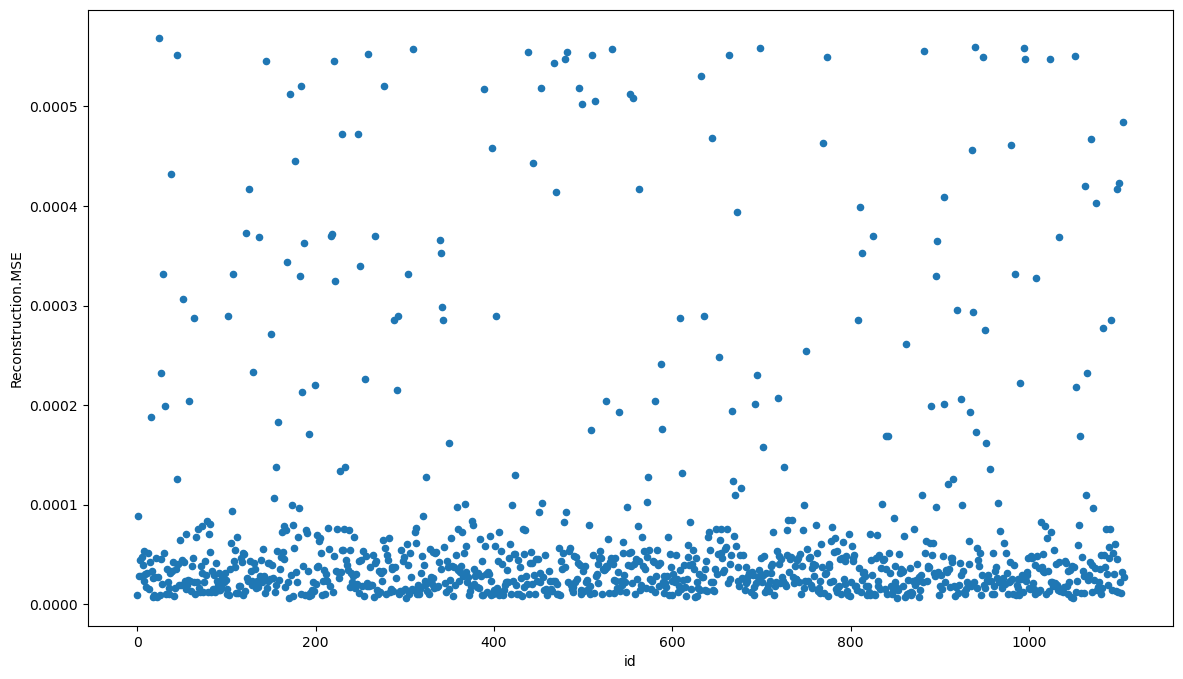

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


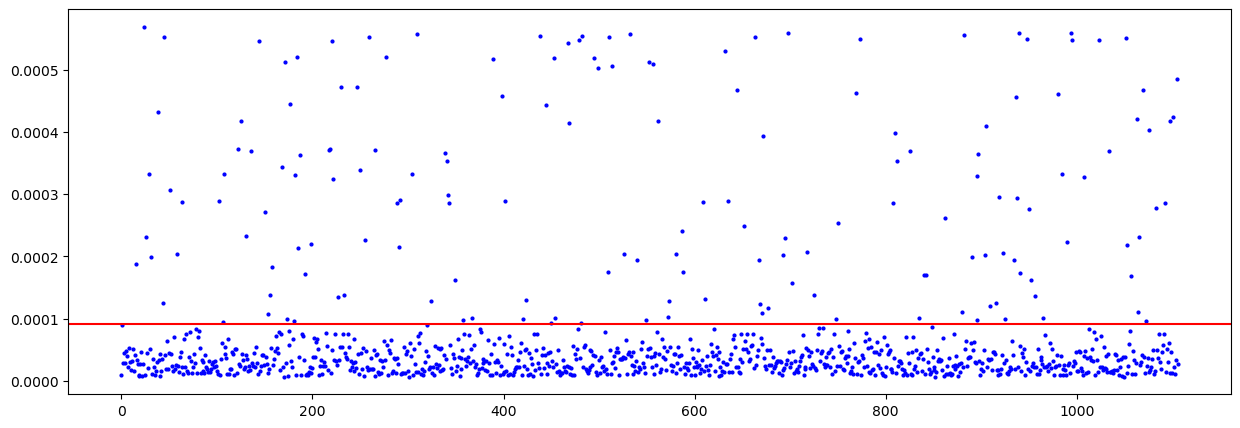

0:  940
1: 167
---------- Type: 2 ----------
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%


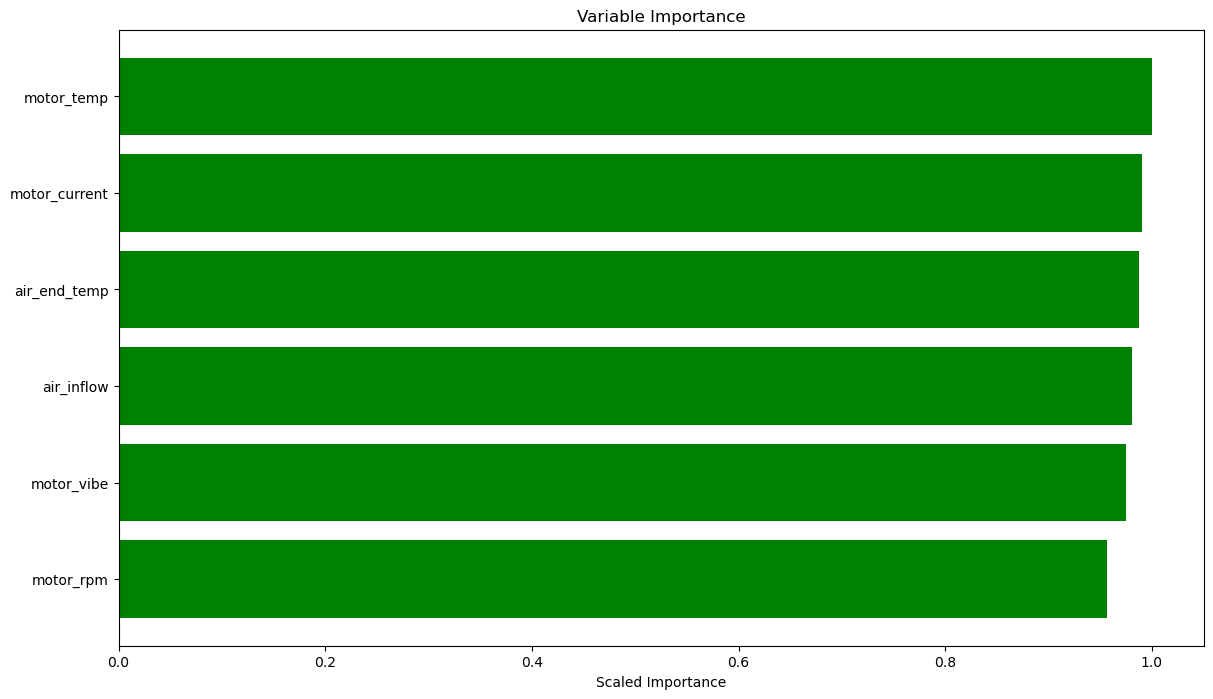

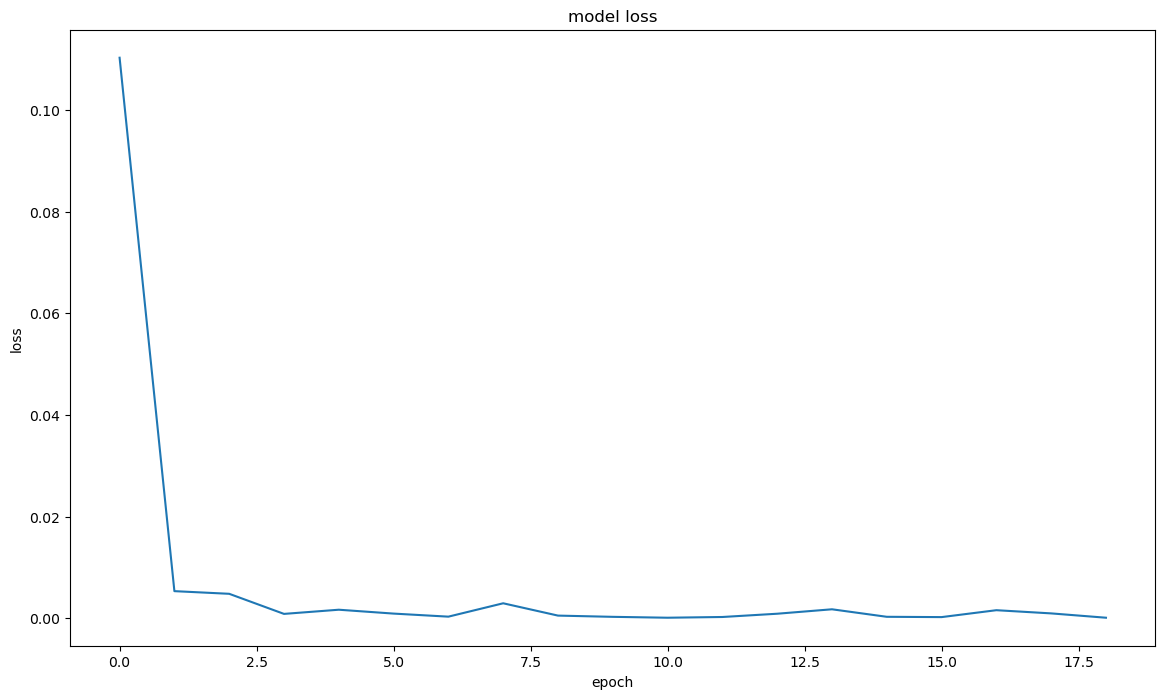

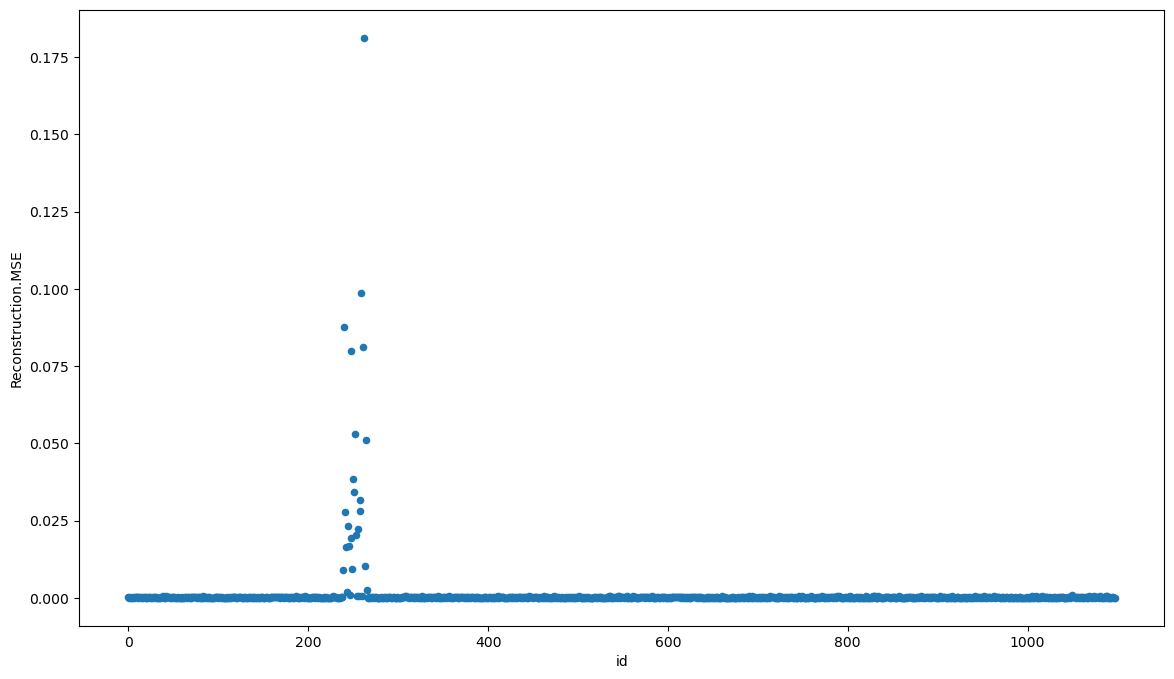

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


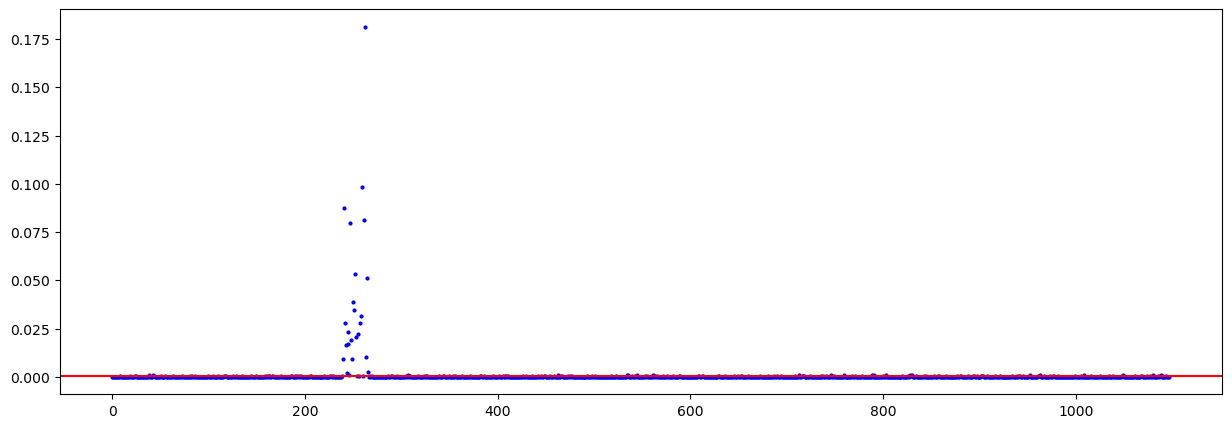

0:  984
1: 114
---------- Type: 3 ----------
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%


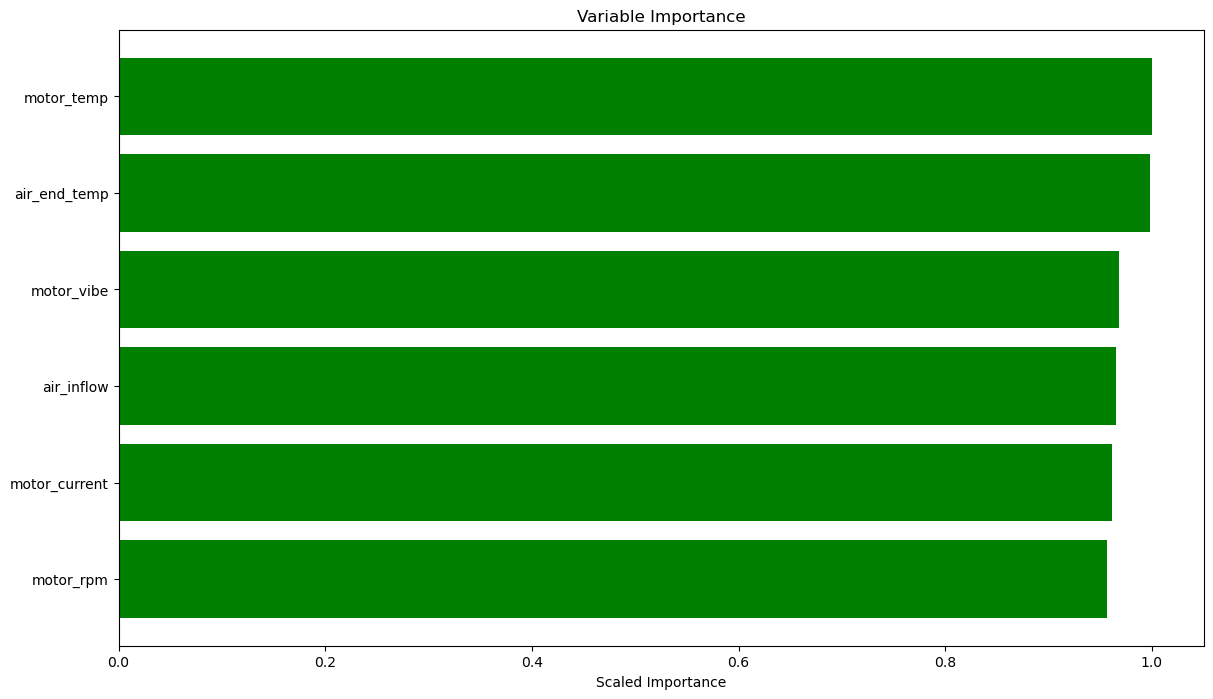

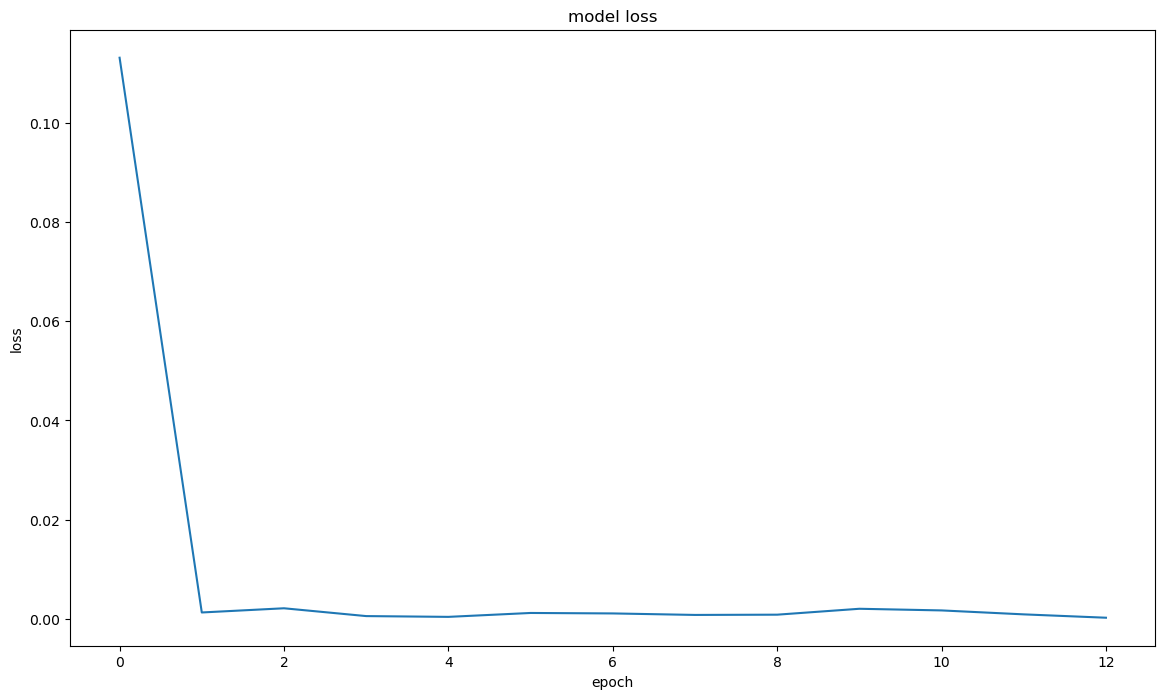

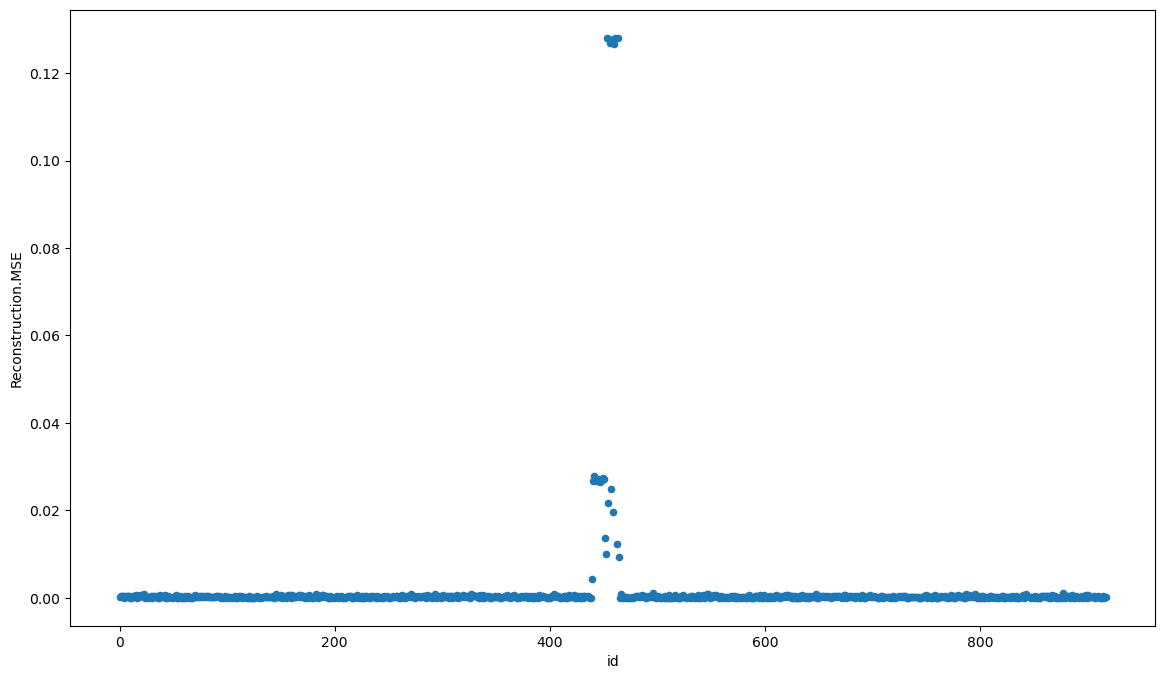

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


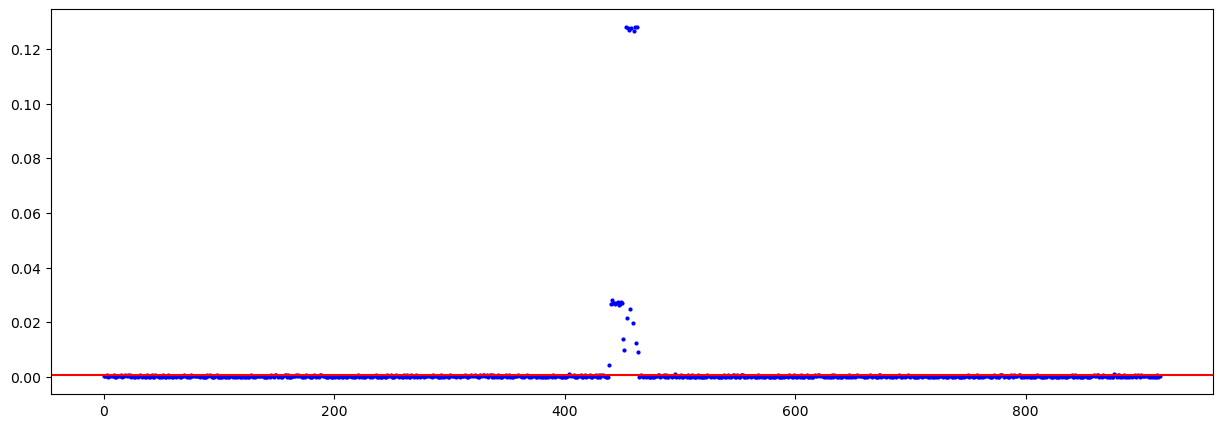

0:  876
1: 42
---------- Type: 4 ----------
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%


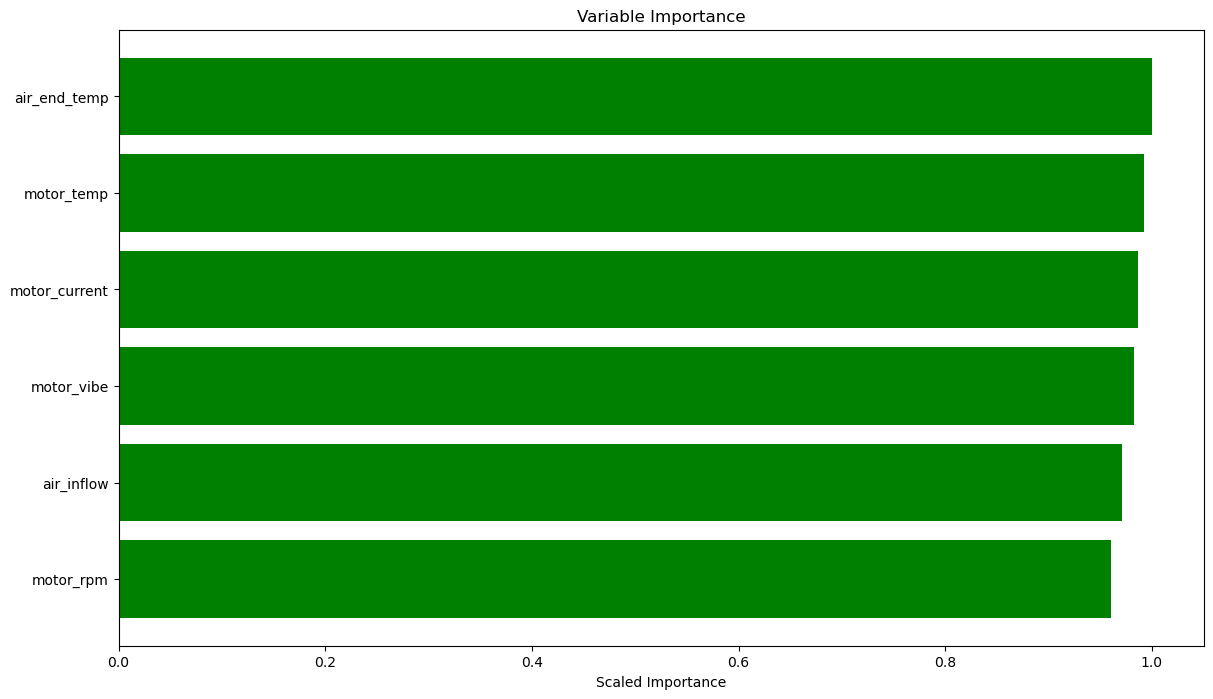

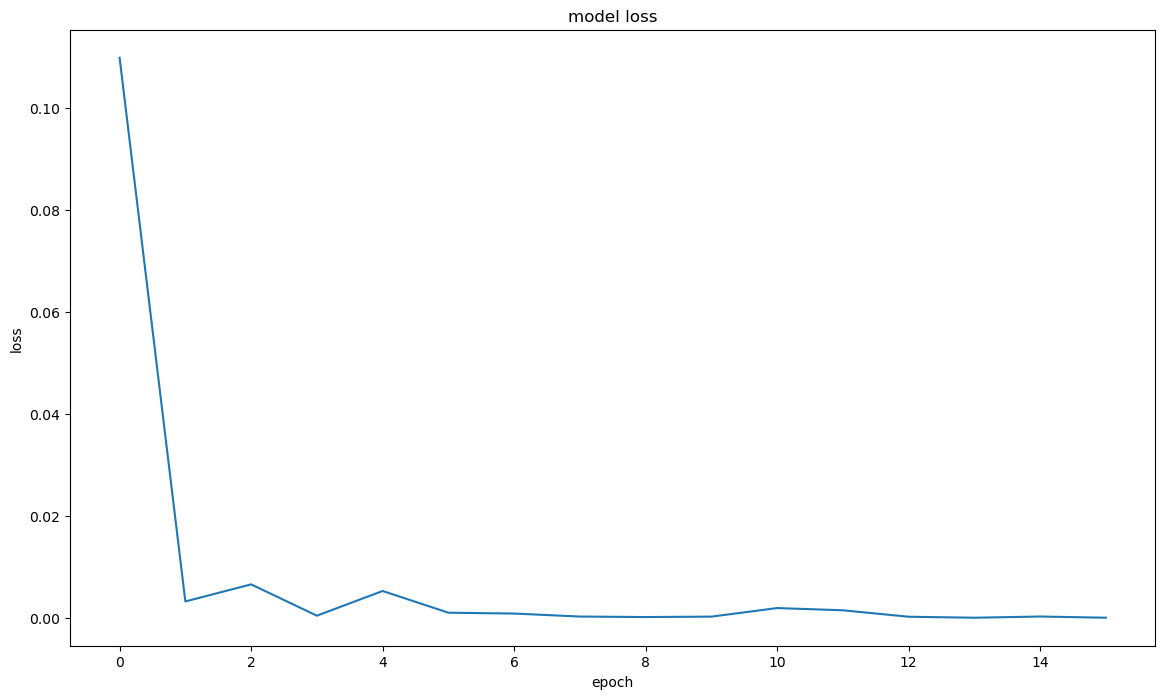

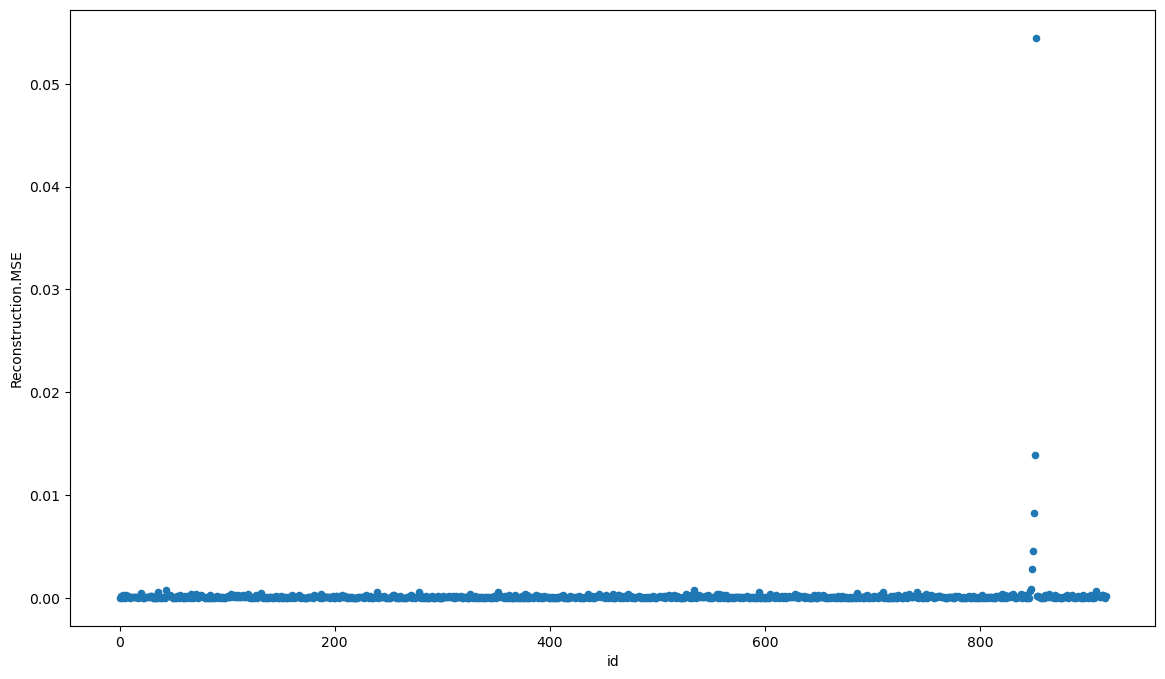

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


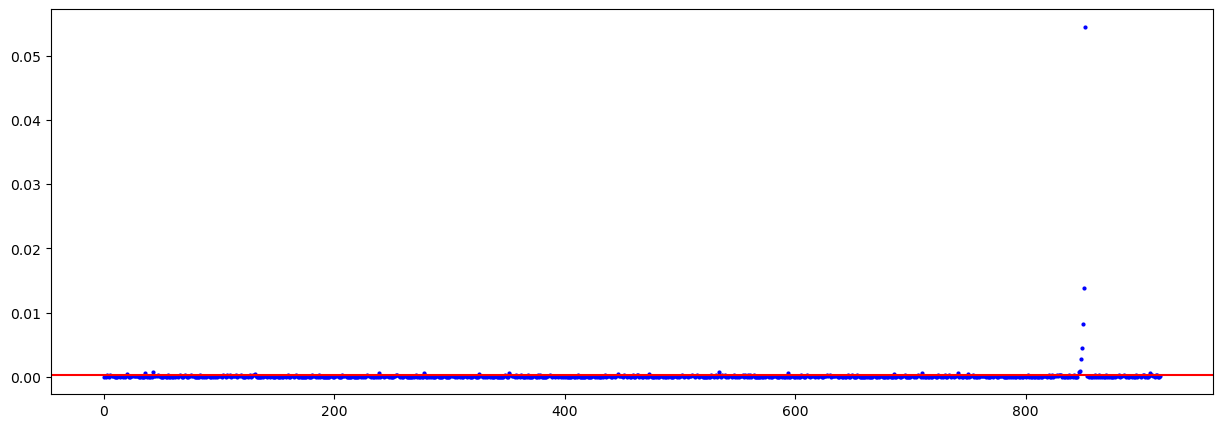

0:  816
1: 102
---------- Type: 5 ----------
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%


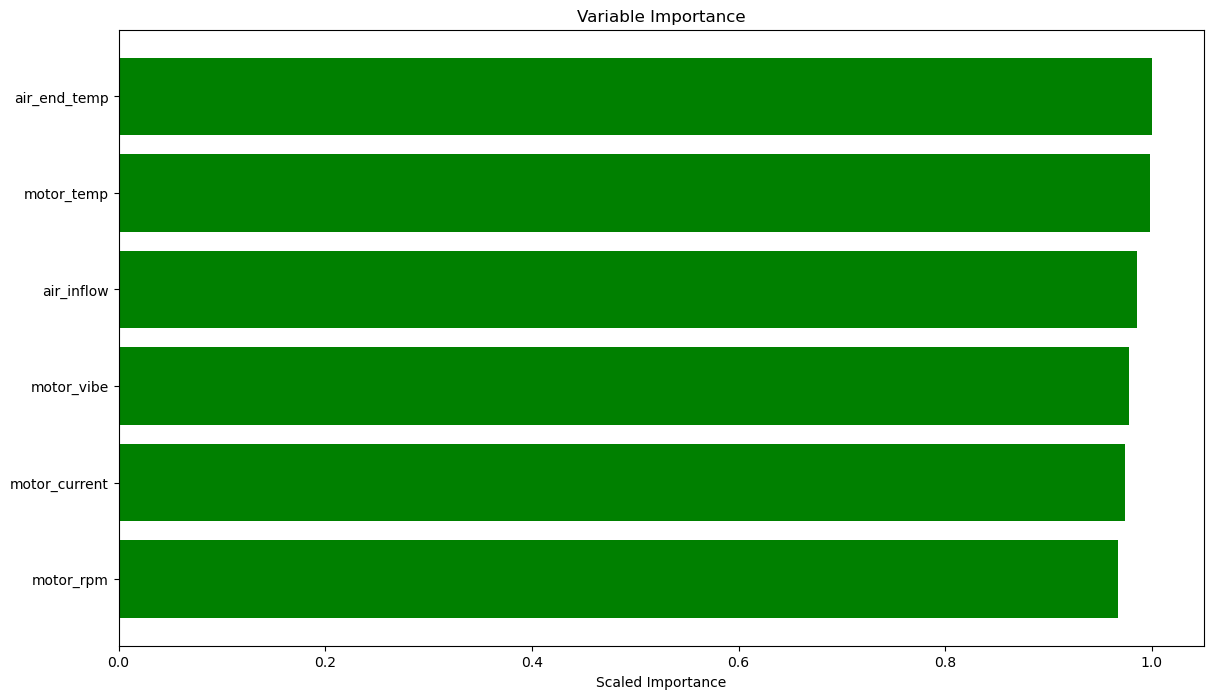

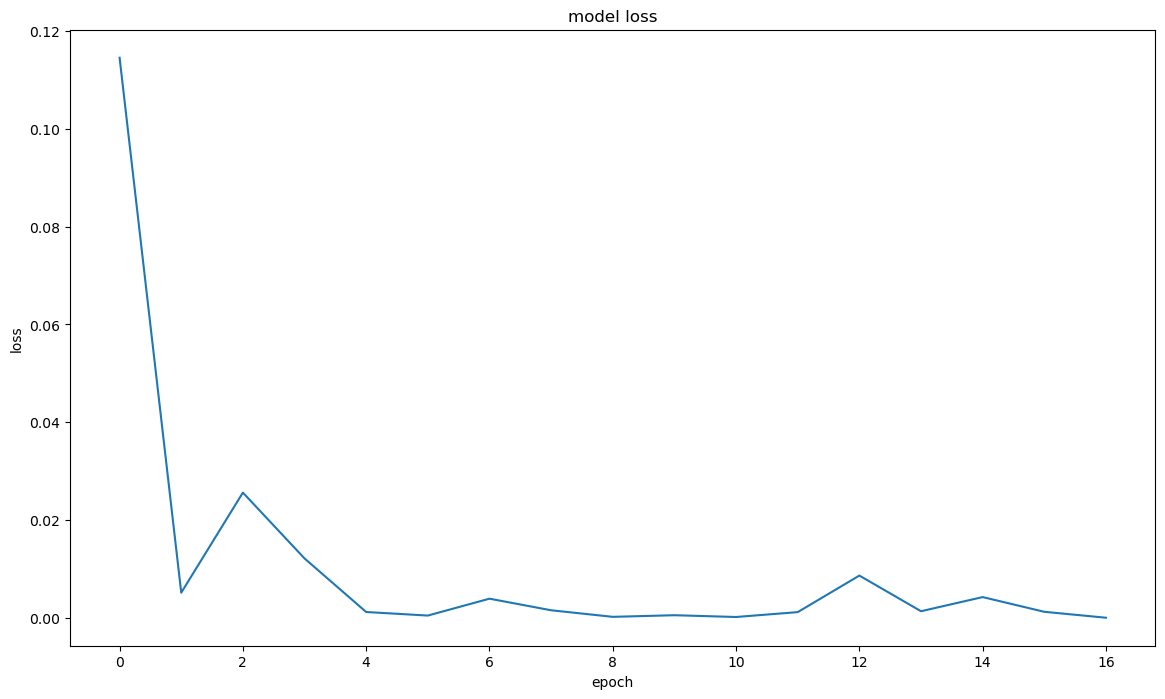

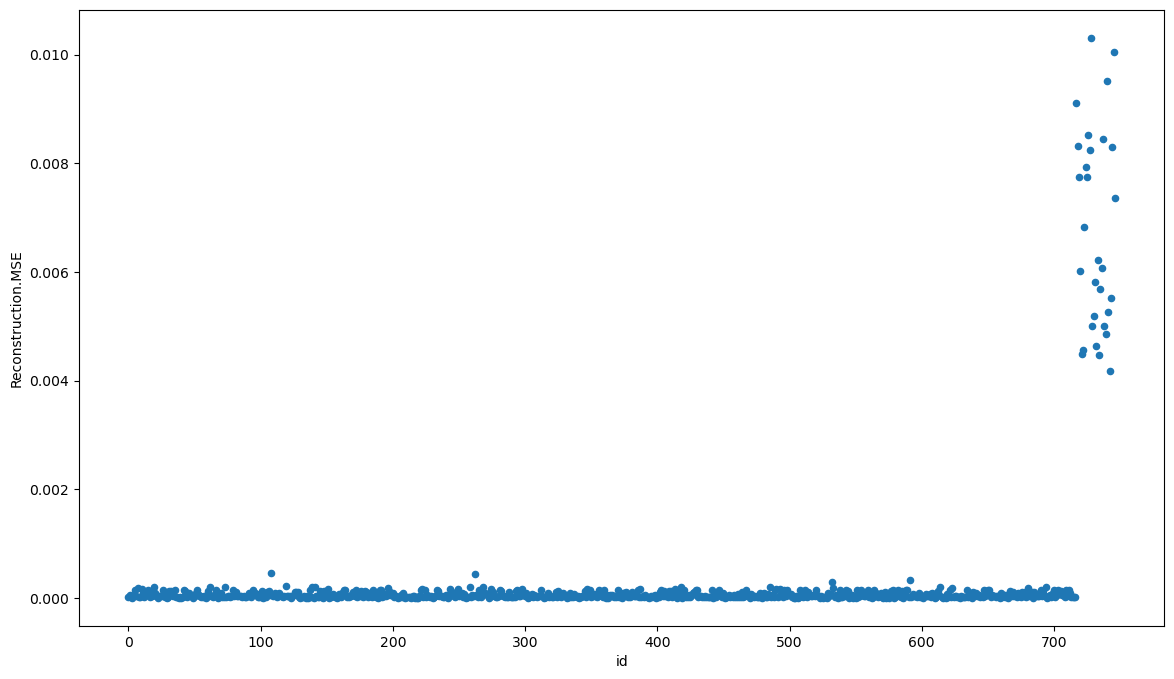

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


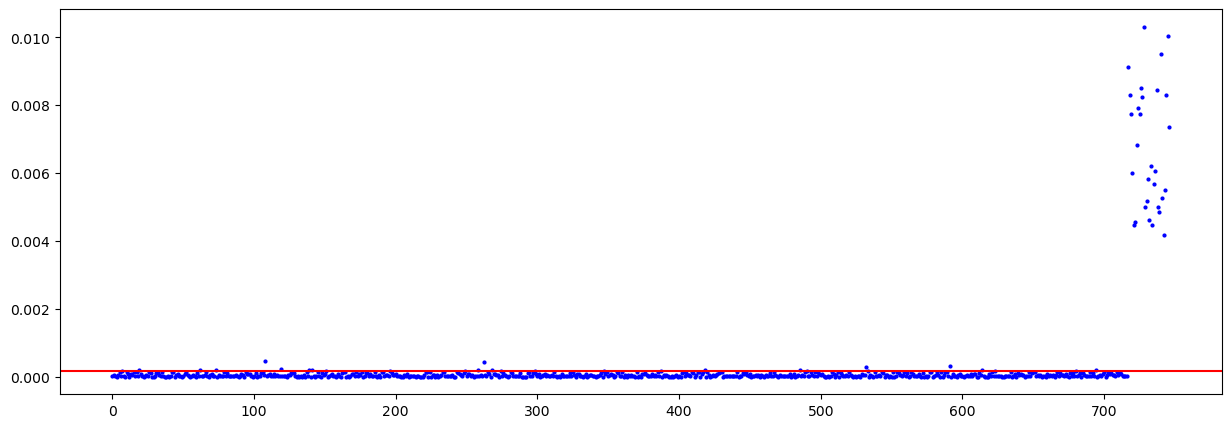

0:  697
1: 50
---------- Type: 6 ----------
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%


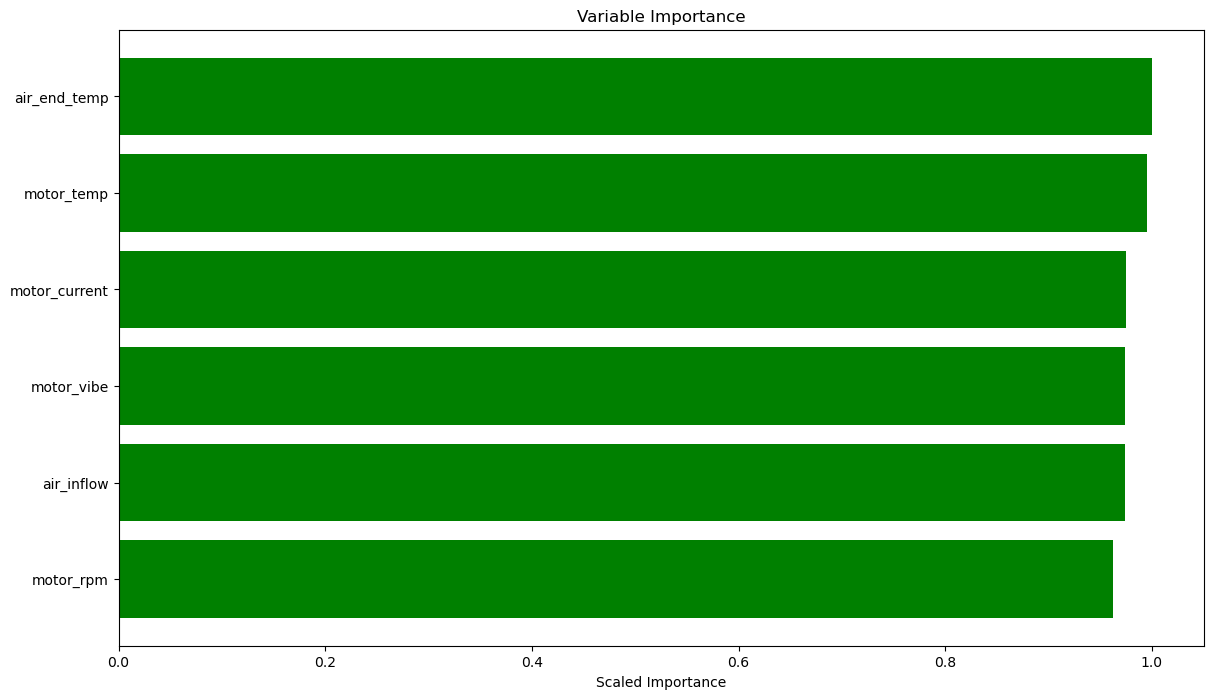

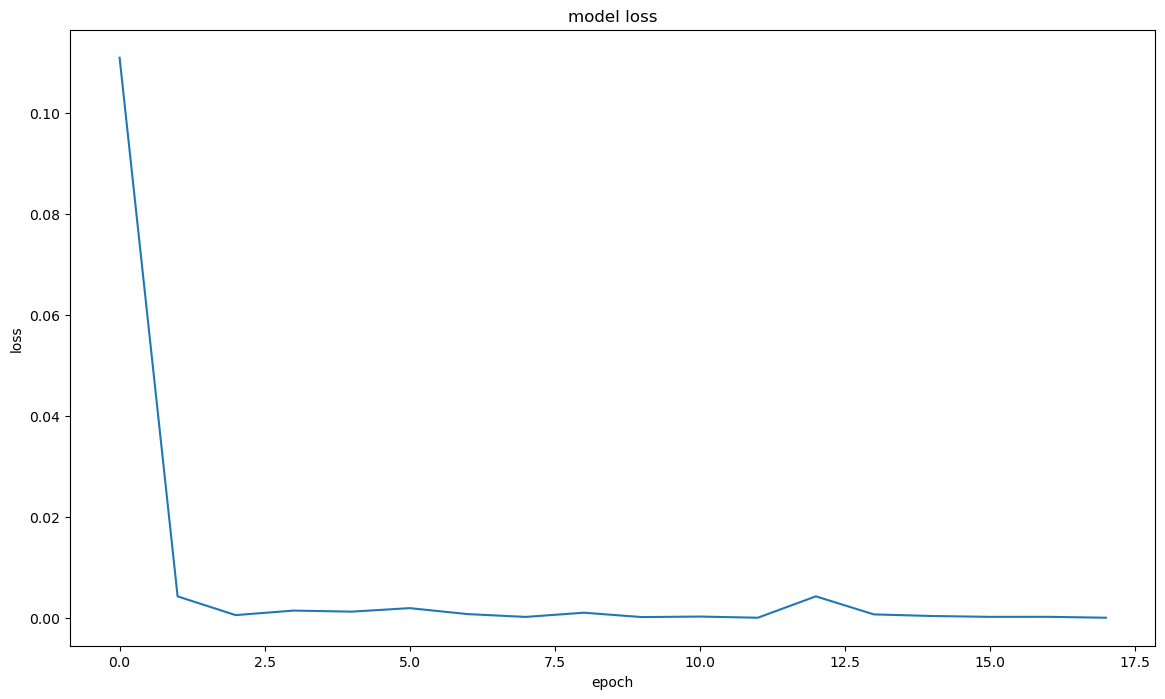

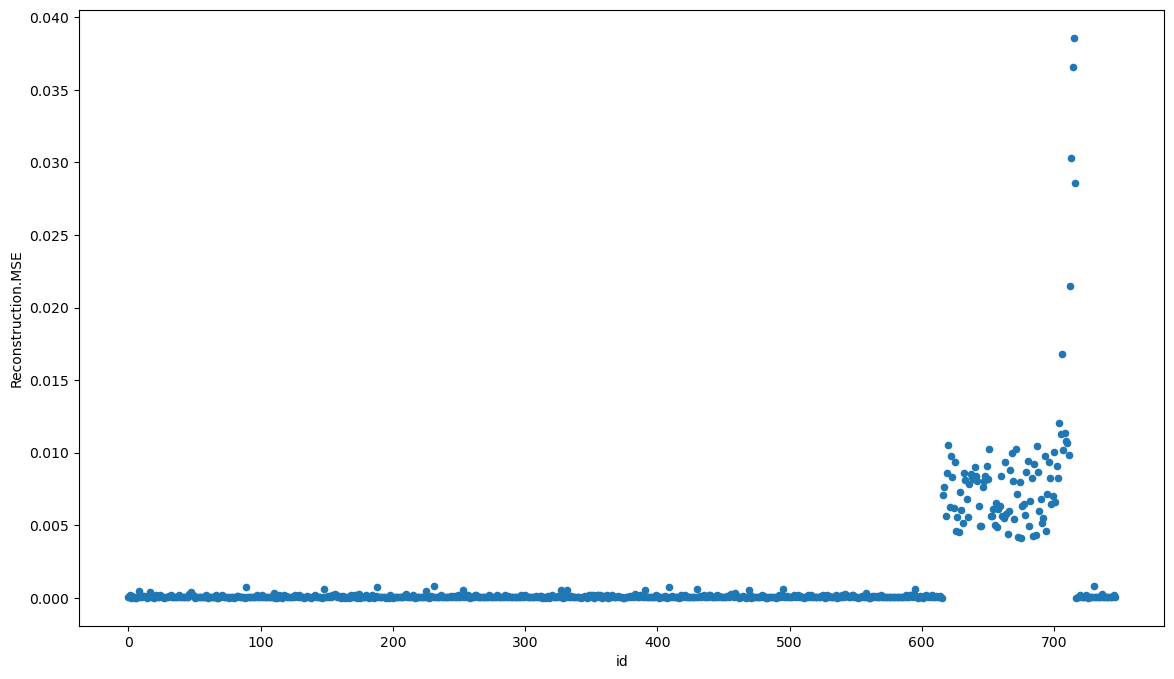

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


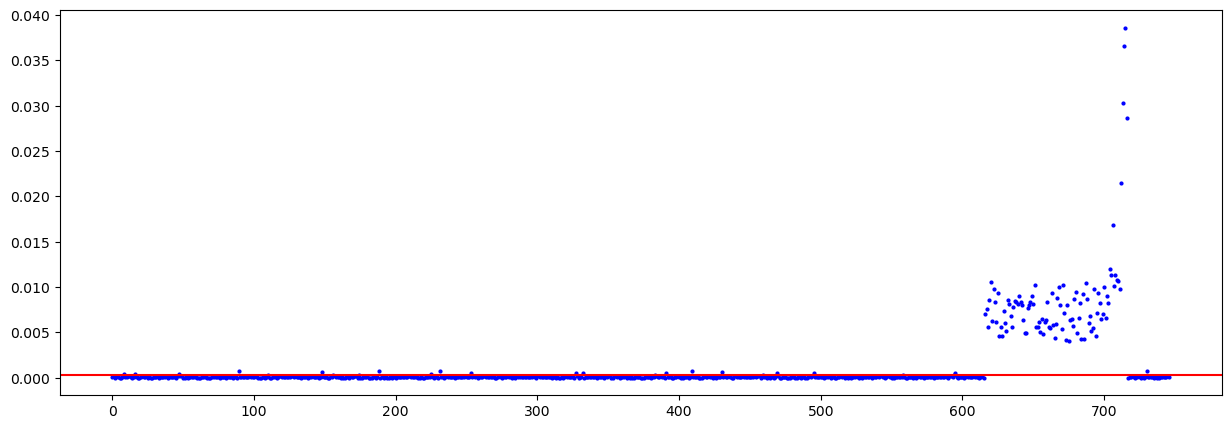

0:  625
1: 122
---------- Type: 7 ----------
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%


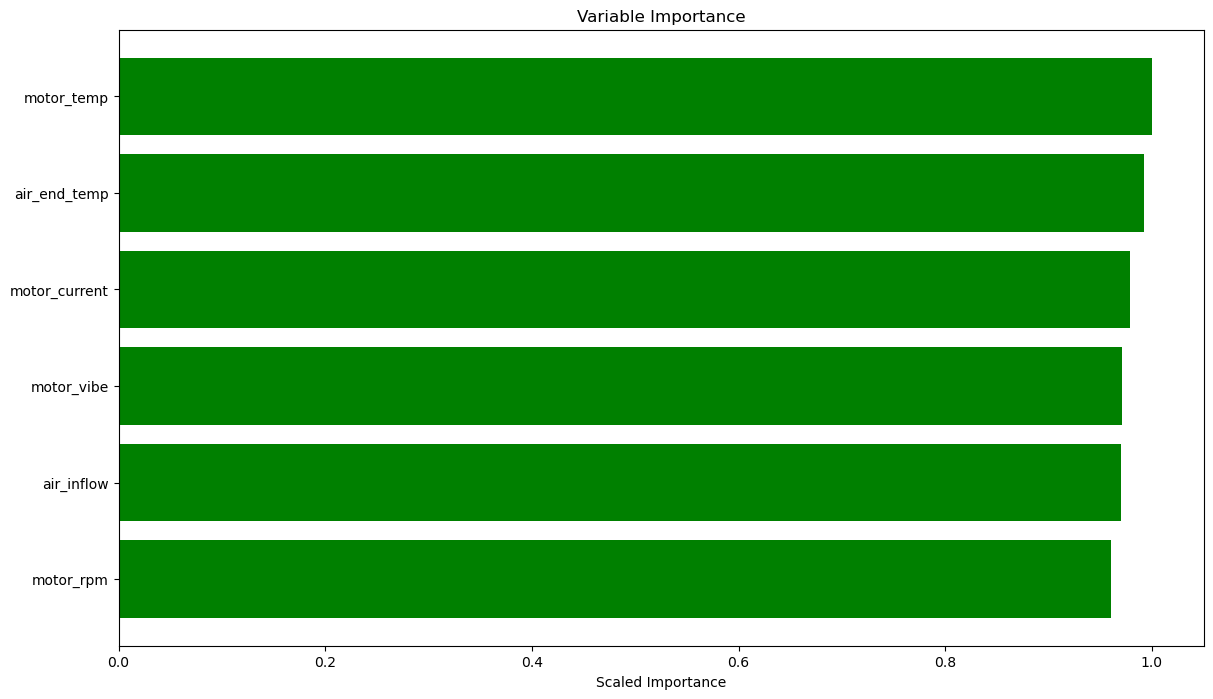

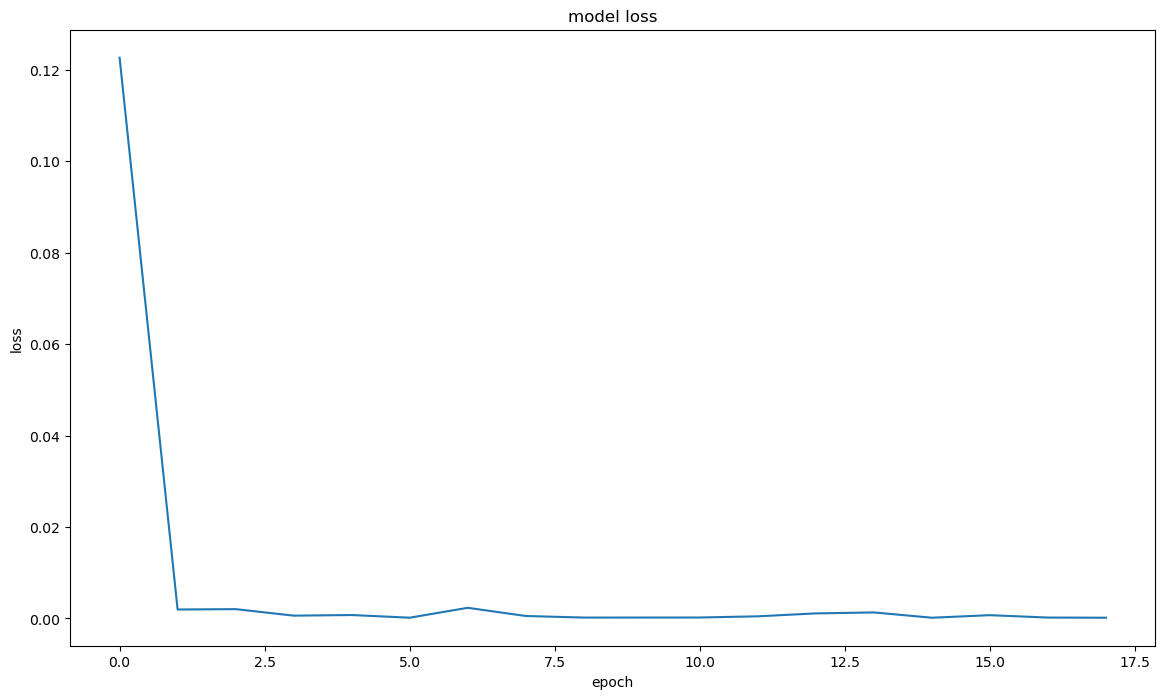

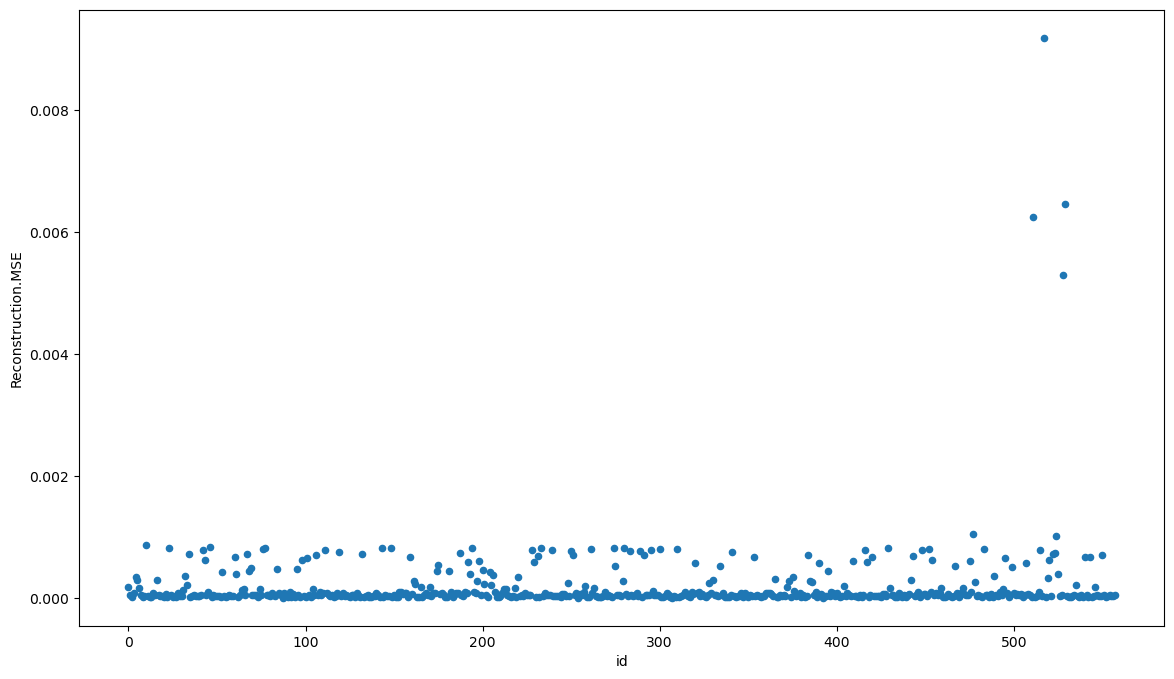

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


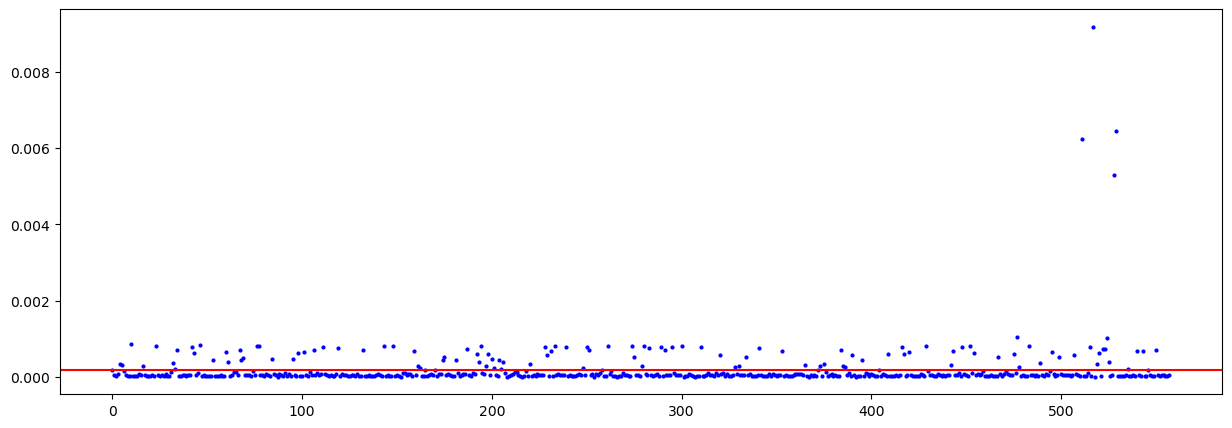

0:  439
1: 119


IndexError: positional indexers are out-of-bounds

In [223]:
ntr = 0
pick_ntr = 3
y_predictions = []
ntr_test_data = pd.DataFrame(columns = train_data.columns)
while True:
    print('*'*10, f'N_Training {ntr}', '*'*10)
    y_preds = []
    
    type_groups = {}
    for in_type in train_data['type'].unique():
        temp = train_data.loc[train_data['type'] == in_type]
        type_groups[f'{in_type}'] = temp

    type_groups_t = {}
    for in_type in test_data['type'].unique():
        temp = test_data.loc[test_data['type'] == in_type]
        type_groups_t[f'{in_type}'] = temp
    
    for idx in type_groups.keys():
        print('-'*10, f'Type: {idx}', '-'*10)
        
        train_data = type_groups[f'{idx}']
        test_data = type_groups_t[f'{idx}']
    
        train_data_ = h2o.H2OFrame(train_data)
        #train_data_ = train_data_.drop('type', axis = 1)
        h2o_columns = train_data_.columns[:-1]
        test_data_ = h2o.H2OFrame(test_data)
        #test_data_ = test_data_.drop('type', axis = 1)

        anomaly_model.train(x = h2o_columns, training_frame = train_data_)

        anomaly_model._model_json['output']['variable_importances'].as_data_frame()
        # plotting the variable importance
        rcParams['figure.figsize'] = 14, 8
        #plt.rcdefaults()
        fig, ax = plt.subplots()

        variables = anomaly_model._model_json['output']['variable_importances']['variable']
        var = variables[0:15]
        y_pos = np.arange(len(var))

        scaled_importance = anomaly_model._model_json['output']['variable_importances']['scaled_importance']
        sc = scaled_importance[0:15]

        ax.barh(y_pos, sc, align='center', color='green', ecolor='black')
        ax.set_yticks(y_pos)
        ax.set_yticklabels(variables)
        ax.invert_yaxis()
        ax.set_xlabel('Scaled Importance')
        ax.set_title('Variable Importance')
        plt.show()

        # plotting the loss
        scoring_history = anomaly_model.score_history()
        %matplotlib inline
        rcParams['figure.figsize'] = 14, 8
        plt.plot(scoring_history['training_mse'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.show()

        test_rec_error = anomaly_model.anomaly(test_data_) 
        # anomaly is a H2O function which calculates the error for the dataset
        # converting to pandas dataframe
        test_rec_error_df = test_rec_error.as_data_frame()
        # plotting the testing dataset against the error
        test_rec_error_df['id']=test_rec_error_df.index
        rcParams['figure.figsize'] = 14, 8
        test_rec_error_df.plot(kind="scatter", x='id', y="Reconstruction.MSE")
        plt.show()

        predictions = anomaly_model.predict(test_data_)

        Q1 = np.percentile(test_rec_error_df['Reconstruction.MSE'], 25)
        Q3 = np.percentile(test_rec_error_df['Reconstruction.MSE'], 75)
        IQR = Q3 - Q1
        IQR_weighted = IQR * 1.5
        threshold = Q3 + IQR
        #threshold = Q3 + IQR_weighted

        plt.figure(figsize = (15, 5))
        plt.plot(test_rec_error_df['Reconstruction.MSE'], 'bo', markersize = 2)
        plt.axhline(threshold, color = 'r')
        plt.show()

        y_pred = np.where(test_rec_error_df['Reconstruction.MSE'] > threshold, 1, 0)
        print('0: ', len(y_pred[y_pred == 0]))
        print('1:', len(y_pred[y_pred != 0]))

        error_df = pd.DataFrame({'reconstruction_error': test_rec_error_df['Reconstruction.MSE']})
        y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]

        y_preds.append(y_pred)

    y_preds = list(itertools.chain(*y_preds))
    true_index = list(filter(lambda x: y_preds[x] == 0, range(len(y_preds))))
    ntr_test_data.append(test_data.iloc[true_index])
    
    #train_data = pd.concat([train_data, test_data.iloc[true_index]], axis = 0)
    #train_data = train_data.drop_duplicates(keep = 'first')
    
    if ntr == pick_ntr - 1:
        ntr_test_data = ntr_test_data.drop_duplicates(keep = 'first')
        train_data = pd.concat([train_data, ntr_test_data], axis = 0)
    
    if ntr == pick_ntr:        
        y_predictions.append(y_preds)
        break
        
    ntr += 1

answer_sample['label'] = y_preds
print(answer_sample.label.value_counts())
answer_sample.to_csv('h2oDeeplearning.csv',index = False)